### Import packages

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
from collections import defaultdict
import folium 
from folium.plugins import StripePattern
import warnings
warnings.filterwarnings('ignore')

temp = pd.read_csv("stage3.csv")

In [110]:
#Organzied by State and time

temp = temp.sort_values(by=['state', "date"])

temp = temp.drop(columns=["incident_url", "address", "source_url", "incident_url_fields_missing", "incident_characteristics", "location_description", "notes", "sources", "state_house_district",
            "state_senate_district", "participant_name", "congressional_district", "city_or_county"])

#### Description of variables used

In [257]:
temp.head(n=5)

incident_id        date    state  n_killed  n_injured gun_stolen  \
127       490395  2013-07-06  Alabama         0          4        NaN   
272       496668  2013-12-28  Alabama         3          5        NaN   
296        92342  2014-01-01  Alabama         1          0        NaN   
315        94194  2014-01-01  Alabama         0          3        NaN   
320        92337  2014-01-01  Alabama         1          0        NaN   

    gun_type  latitude  longitude  n_guns_involved  \
127      NaN   34.7982   -87.6854              NaN   
272      NaN   32.3719   -86.2952              NaN   
296      NaN   34.7663   -86.6028              NaN   
315      NaN   33.2482   -87.5670              NaN   
320      NaN   31.7839   -86.1926              NaN   

                                       participant_age  \
127                                              4::22   
272  0::21||1::22||2::20||3::20||4::23||5::20||6::2...   
296                                       0::21||1::24   
315                         3::17||4::19||5::19||6::19   
320                                       0::18||1::19   

                                 participant_age_group  \
127                                       4::Adult 18+   
272  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
296                         0::Adult 18+||1::Adult 18+   
315  3::Teen 12-17||4::Adult 18+||5::Adult 18+||6::...   
320                         0::Adult 18+||1::Adult 18+   

                                    participant_gender  \
127                                          4::Female   
272  0::Female||1::Male||2::Male||3::Male||4::Male|...   
296                                 0::Female||1::Male   
315  0::Male||1::Male||2::Female||3::Male||4::Male|...   
320                                 0::Female||1::Male   

              participant_relationship  \
127                                NaN   
272  9::Mass shooting - Random victims   
296                                NaN   
315                                NaN   
320                                NaN   

                                    participant_status  \
127  0::Injured||1::Injured||2::Injured||3::Injured...   
272  0::Killed||1::Killed||2::Injured||3::Injured||...   
296                             0::Killed||1::Unharmed   
315  0::Injured||1::Injured||2::Injured||3::Unharme...   
320                             0::Killed||1::Unharmed   

                                      participant_type  
127  0::Victim||1::Victim||2::Victim||3::Victim||4:...  
272  0::Victim||1::Victim||2::Victim||3::Victim||4:...  
296                      0::Victim||1::Subject-Suspect  
315  0::Victim||1::Victim||2::Victim||3::Subject-Su...  
320                      0::Victim||1::Subject-Suspect

* incident_id	- ID of shooting incident
* date - date of incident
* state - state where the incident occured	
* n_killed - number of people killed in the incident
* n_injured - number of people injured in the incident
* gun_stolen - guns stolen, unknown, or not stolen for the incident
* gun_type - type of gun involved in the incident
* latitude - the latitude coordinate of the incident
* longitude - the longitude coordinate of the incident
* n_guns_involved	- number of guns involved in the incident
* participant_age	- participants age, killed, injured, or assailant in the incident
* participant_age_group - age group of participants in the incident
* participant_gender	- gender of participants in the incident
* participant_relationship - participant relationships to other participants in the incident
* participant_status - participant status: 'Arrested', 'Killed', 'Injured', or 'Unharmed' in the incident
* participant_type - particpant type:  'Victim' or 'Subject-Suspect in the incident

## Data cleaning process

Mass shooting is definied as 3/4 or more killings. Becuase of this, we will first remove the row that have number of killed greater than or equal to 3. 

In [125]:
temp = temp[temp['n_killed']>= 3]

In [126]:
## Checking the data type of columns

temp.dtypes

temp.info(verbose=True)

##  re-indexing the dataframe

temp = temp.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 272 to 223588
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   incident_id               802 non-null    int64         
 1   date                      802 non-null    datetime64[ns]
 2   state                     802 non-null    object        
 3   n_killed                  802 non-null    int64         
 4   n_injured                 802 non-null    int64         
 5   gun_stolen                538 non-null    object        
 6   gun_type                  538 non-null    object        
 7   latitude                  776 non-null    float64       
 8   longitude                 776 non-null    float64       
 9   n_guns_involved           538 non-null    float64       
 10  participant_age           775 non-null    object        
 11  participant_age_group     797 non-null    object        
 12  participant_gende

In [127]:
## making the date column a datetime column

temp['date'] = pd.to_datetime(temp['date'])

## double-checking that the data types are correct

temp.dtypes

incident_id                          int64
date                        datetime64[ns]
state                               object
n_killed                             int64
n_injured                            int64
gun_stolen                          object
gun_type                            object
latitude                           float64
longitude                          float64
n_guns_involved                    float64
participant_age                     object
participant_age_group               object
participant_gender                  object
participant_relationship            object
participant_status                  object
participant_type                    object
dtype: object

In [128]:
# ## Note gun_stolen column values is a string, but with inner and outer separators, according to James' Gun Violence data repo

## But let's make sure that it is in a string format

temp1 = temp.astype({'gun_stolen':str})

## Now create a recursive function to take care of || and :: ....

text_list = [] 
def extract(x):
    """This is a recursive function to extract text separated by ||"""
    ch = '|'
    if ch not in x:
        for i in range(len(x)):
            if x[i] == ":" and x[i+1] == ":":
                text = x[i+2:]
                text_list.append(text)
                return text_list
    else:
        for i in range(len(x)):
            if x[i] == '|' and x[i+1] == '|':
                first_text = x[0:i]
                for j in range(len(first_text)):
                    if first_text[j] == ":" and first_text[j+1] == ":":
                        better_text = first_text[j+2:]
                        text_list.append(better_text)
                        break
                newtext = x[i+2:]
                extract(newtext)
                break
        return text_list


In [129]:
## Now apply extract function to gun_stolen column

for i in range(len(temp1)):
    stats = temp1.loc[i, 'gun_stolen']
    text_list = []
    complete_list = extract(stats)
    temp1.at[i, 'gun_stolen'] = complete_list
    

In [130]:
temp1.sample(5)

incident_id       date       state  n_killed  n_injured  \
208      1077257 2018-03-25     Florida         3          0   
90        446738 2015-11-12  California         3          2   
355       757697 2017-01-22   Louisiana         3          0   
440       624485 2016-08-08    Missouri         3          0   
447       862301 2017-06-07    Missouri         3          0   

             gun_stolen                gun_type  latitude  longitude  \
208           [Unknown]              0::Unknown   26.4626   -80.0863   
90                 None                     NaN   33.9154  -118.3390   
355           [Unknown]              0::Unknown   29.9761   -90.2178   
440  [Unknown, Unknown]  0::Handgun||1::Handgun       NaN        NaN   
447           [Unknown]              0::Unknown   39.0424   -94.5416   

     n_guns_involved             participant_age  \
208              1.0         0::43||1::41||2::44   
90               NaN                3::62||4::64   
355              1.0  0::16||1::25||2::24||3::31   
440              2.0         0::53||1::20||2::21   
447              1.0         0::34||1::28||2::28   

                                 participant_age_group  \
208           0::Adult 18+||1::Adult 18+||2::Adult 18+   
90   0::Adult 18+||2::Adult 18+||3::Adult 18+||4::A...   
355  0::Teen 12-17||1::Adult 18+||2::Adult 18+||3::...   
440           0::Adult 18+||1::Adult 18+||2::Adult 18+   
447           0::Adult 18+||1::Adult 18+||2::Adult 18+   

                                participant_gender  \
208                  0::Female||1::Female||2::Male   
90   0::Male||1::Male||2::Male||3::Female||4::Male   
355         0::Female||1::Male||2::Female||3::Male   
440                      0::Male||1::Male||2::Male   
447                      0::Male||1::Male||2::Male   

                      participant_relationship  \
208  2::Significant others - current or former   
90                                         NaN   
355                                 3::Friends   
440       2::Home Invasion - Perp Knows Victim   
447                                        NaN   

                                    participant_status  \
208                    0::Killed||1::Killed||2::Killed   
90   0::Killed||1::Injured||2::Injured||3::Killed||...   
355  0::Killed||1::Killed||2::Killed||3::Unharmed, ...   
440                    0::Killed||1::Killed||2::Killed   
447                    0::Killed||1::Killed||2::Killed   

                                      participant_type  
208           0::Victim||1::Victim||2::Subject-Suspect  
90   0::Victim||1::Victim||2::Victim||3::Victim||4:...  
355  0::Victim||1::Victim||2::Victim||3::Subject-Su...  
440           0::Victim||1::Victim||2::Subject-Suspect  
447                    0::Victim||1::Victim||2::Victim

In [131]:
## Replacing Null/NA values with "Unknown"

maximum = 0
for i in range(len(temp1)):
    l = temp1.loc[i, 'gun_stolen']
    if not l:
        l = ["Unknown"]
        temp1.at[i, 'gun_stolen'] = l
    

In [132]:
# Let's expand the dataframe to include three more columns

temp1[["Number_Unknown_Guns", "Number_Stolen_Guns", "Number_Not_Stolen_Guns"]] = None

In [133]:
temp1.head(5)

incident_id       date    state  n_killed  n_injured gun_stolen  gun_type  \
0       496668 2013-12-28  Alabama         3          5  [Unknown]       NaN   
1       187367 2014-09-06  Alabama         3          0  [Unknown]       NaN   
2       195207 2014-09-23  Alabama         3          0  [Unknown]       NaN   
3       261048 2014-12-04  Alabama         3          0  [Unknown]       NaN   
4       308861 2015-03-15  Alabama         3          1  [Unknown]  0::Rifle   

   latitude  longitude  n_guns_involved  \
0   32.3719   -86.2952              NaN   
1   33.4905   -86.9639              NaN   
2   33.5683   -86.7649              NaN   
3   30.6911   -88.0999              NaN   
4   31.0878   -85.3250              1.0   

                                     participant_age  \
0  0::21||1::22||2::20||3::20||4::23||5::20||6::2...   
1                                       0::29||2::32   
2                                0::33||1::46||2::45   
3                                0::43||1::67||2::56   
4                                0::43||2::74||3::45   

                               participant_age_group  \
0  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
1          0::Adult 18+||1::Child 0-11||2::Adult 18+   
2           0::Adult 18+||1::Adult 18+||2::Adult 18+   
3           0::Adult 18+||1::Adult 18+||2::Adult 18+   
4  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   

                                  participant_gender  \
0  0::Female||1::Male||2::Male||3::Male||4::Male|...   
1                        0::Female||1::Male||2::Male   
2                          0::Male||1::Male||2::Male   
3                        0::Male||1::Female||2::Male   
4               0::Female||1::Male||2::Male||3::Male   

            participant_relationship  \
0  9::Mass shooting - Random victims   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

                                  participant_status  \
0  0::Killed||1::Killed||2::Injured||3::Injured||...   
1                    0::Killed||1::Killed||2::Killed   
2                    0::Killed||1::Killed||2::Killed   
3                    0::Killed||1::Killed||2::Killed   
4        0::Killed||1::Killed||2::Injured||3::Killed   

                                    participant_type Number_Unknown_Guns  \
0  0::Victim||1::Victim||2::Victim||3::Victim||4:...                None   
1           0::Victim||1::Victim||2::Subject-Suspect                None   
2           0::Victim||1::Victim||2::Subject-Suspect                None   
3           0::Victim||1::Victim||2::Subject-Suspect                None   
4  0::Victim||1::Victim||2::Victim||3::Subject-Su...                None   

  Number_Stolen_Guns Number_Not_Stolen_Guns  
0               None                   None  
1               None                   None  
2               None                   None  
3               None                   None  
4               None                   None

In [134]:
# Rearranging the columns so the newly added columns are next to gun_stolen

temp2 = temp1[['incident_id', 'date', 'state', 'latitude', 'longitude', 'n_killed', 'n_injured', 'gun_stolen', 
'Number_Unknown_Guns', 'Number_Stolen_Guns', 'Number_Not_Stolen_Guns', 'gun_type', 'n_guns_involved', 'participant_age', 'participant_age_group', 
'participant_gender', 'participant_relationship', 'participant_status', 'participant_type']]

#### Extracting the number of guns stolen

In [135]:
# Let's create a dictionary of items in gun_stolen and count them. Then put appropriate numbers in appropriate columns
for i in range(len(temp2)):
    gunstolen_list = temp2.loc[i, 'gun_stolen']
    gunstolen_dict = {}
    for j in gunstolen_list:
        gunstolen_dict[j] = gunstolen_dict.get(j, 0) + 1
    temp2.at[i, 'Number_Unknown_Guns'] = gunstolen_dict.get('Unknown')
    temp2.at[i, 'Number_Stolen_Guns'] = gunstolen_dict.get('Stolen')
    temp2.at[i, 'Number_Not_Stolen_Guns'] = gunstolen_dict.get('Not-Stolen')



In [136]:
temp2.head(5)

incident_id       date    state  latitude  longitude  n_killed  n_injured  \
0       496668 2013-12-28  Alabama   32.3719   -86.2952         3          5   
1       187367 2014-09-06  Alabama   33.4905   -86.9639         3          0   
2       195207 2014-09-23  Alabama   33.5683   -86.7649         3          0   
3       261048 2014-12-04  Alabama   30.6911   -88.0999         3          0   
4       308861 2015-03-15  Alabama   31.0878   -85.3250         3          1   

  gun_stolen Number_Unknown_Guns Number_Stolen_Guns Number_Not_Stolen_Guns  \
0  [Unknown]                   1               None                   None   
1  [Unknown]                   1               None                   None   
2  [Unknown]                   1               None                   None   
3  [Unknown]                   1               None                   None   
4  [Unknown]                   1               None                   None   

   gun_type  n_guns_involved  \
0       NaN              NaN   
1       NaN              NaN   
2       NaN              NaN   
3       NaN              NaN   
4  0::Rifle              1.0   

                                     participant_age  \
0  0::21||1::22||2::20||3::20||4::23||5::20||6::2...   
1                                       0::29||2::32   
2                                0::33||1::46||2::45   
3                                0::43||1::67||2::56   
4                                0::43||2::74||3::45   

                               participant_age_group  \
0  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
1          0::Adult 18+||1::Child 0-11||2::Adult 18+   
2           0::Adult 18+||1::Adult 18+||2::Adult 18+   
3           0::Adult 18+||1::Adult 18+||2::Adult 18+   
4  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   

                                  participant_gender  \
0  0::Female||1::Male||2::Male||3::Male||4::Male|...   
1                        0::Female||1::Male||2::Male   
2                          0::Male||1::Male||2::Male   
3                        0::Male||1::Female||2::Male   
4               0::Female||1::Male||2::Male||3::Male   

            participant_relationship  \
0  9::Mass shooting - Random victims   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

                                  participant_status  \
0  0::Killed||1::Killed||2::Injured||3::Injured||...   
1                    0::Killed||1::Killed||2::Killed   
2                    0::Killed||1::Killed||2::Killed   
3                    0::Killed||1::Killed||2::Killed   
4        0::Killed||1::Killed||2::Injured||3::Killed   

                                    participant_type  
0  0::Victim||1::Victim||2::Victim||3::Victim||4:...  
1           0::Victim||1::Victim||2::Subject-Suspect  
2           0::Victim||1::Victim||2::Subject-Suspect  
3           0::Victim||1::Victim||2::Subject-Suspect  
4  0::Victim||1::Victim||2::Victim||3::Subject-Su...

In [137]:
#Transform None to 0s
target = ['Number_Unknown_Guns', 'Number_Stolen_Guns','Number_Not_Stolen_Guns']
for t in target:
    temp2[t] = temp2[t].fillna(0)
    
temp2.tail(10)

incident_id       date          state  latitude  longitude  n_killed  \
792       679868 2016-10-19  West Virginia   39.2681   -81.5439         3   
793       333750 2015-05-03      Wisconsin   44.2029   -88.4656         4   
794       471715 2015-12-24      Wisconsin   46.5932   -90.8756         3   
795       516691 2016-03-05      Wisconsin   43.0231   -87.9227         3   
796       517474 2016-03-06      Wisconsin   42.9845   -88.0271         3   
797       548991 2016-04-27      Wisconsin   44.3861   -89.8133         3   
798       800363 2017-03-22      Wisconsin   44.8975   -89.6129         5   
799       912653 2017-08-13      Wisconsin   42.6696   -88.0312         3   
800       974997 2017-10-27      Wisconsin   45.2932   -91.6246         3   
801      1009368 2017-12-16      Wisconsin       NaN        NaN         3   

     n_injured          gun_stolen  Number_Unknown_Guns  Number_Stolen_Guns  \
792          0           [Unknown]                    1                   0   
793          1  [Unknown, Unknown]                    2                   0   
794          0           [Unknown]                    1                   0   
795          0           [Unknown]                    1                   0   
796          0           [Unknown]                    1                   0   
797          0           [Unknown]                    1                   0   
798          0  [Unknown, Unknown]                    2                   0   
799          0           [Unknown]                    1                   0   
800          0           [Unknown]                    1                   0   
801          0           [Unknown]                    1                   0   

     Number_Not_Stolen_Guns              gun_type  n_guns_involved  \
792                       0            0::Handgun              1.0   
793                       0    0::9mm||1::Handgun              2.0   
794                       0                   NaN              NaN   
795                       0            0::Unknown              1.0   
796                       0              0::Rifle              1.0   
797                       0            0::Unknown              1.0   
798                       0  0::Rifle||1::Handgun              2.0   
799                       0            0::Unknown              1.0   
800                       0            0::Unknown              1.0   
801                       0            0::Unknown              1.0   

                       participant_age  \
792                0::38||1::28||2::31   
793  0::33||1::11||2::31||3::31||4::27   
794                0::23||1::84||2::54   
795                0::45||1::12||2::41   
796         0::40||1::36||2::32||3::39   
797                  0::5||1::3||2::36   
798  0::67||1::62||2::40||3::43||4::45   
799                0::30||1::30||2::26   
800                0::55||1::17||2::15   
801                0::32||1::32||2::43   

                                 participant_age_group  \
792           0::Adult 18+||1::Adult 18+||2::Adult 18+   
793  0::Adult 18+||1::Child 0-11||2::Adult 18+||3::...   
794           0::Adult 18+||1::Adult 18+||2::Adult 18+   
795          0::Adult 18+||1::Teen 12-17||2::Adult 18+   
796  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
797         0::Child 0-11||1::Child 0-11||2::Adult 18+   
798  0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...   
799           0::Adult 18+||1::Adult 18+||2::Adult 18+   
800         0::Adult 18+||1::Teen 12-17||2::Teen 12-17   
801           0::Adult 18+||1::Adult 18+||2::Adult 18+   

                                    participant_gender  \
792                        0::Male||1::Female||2::Male   
793    0::Male||1::Female||2::Male||3::Female||4::Male   
794                      0::Female||1::Female||2::Male   
795                      0::Female||1::Male||2::Female   
796               0::Male||1::Female||2::Male||3::Male   
797                        0::Female||1::Male||2::Male   
798  0::

#### Let's clean the rest of the columns that has ::

In [138]:
## Gun Type
temp2 = temp2.astype({'gun_type':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'gun_type']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'gun_type'] = complete_list

## Participant_Age
temp2 = temp2.astype({'participant_age':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_age']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_age'] = complete_list

## Participant Age Group
temp2 = temp2.astype({'participant_age_group':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_age_group']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_age_group'] = complete_list

## Participant Gender
temp2 = temp2.astype({'participant_gender':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_gender']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_gender'] = complete_list


## Participant Relationship
temp2 = temp2.astype({'participant_relationship':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_relationship']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_relationship'] = complete_list

## Participant Status

temp2 = temp2.astype({'participant_status':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_status']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_status'] = complete_list

## Participant Type

temp2 = temp2.astype({'participant_type':str})

for i in range(len(temp2)):
    stats = temp2.loc[i, 'participant_type']
    text_list = []
    complete_list = extract(stats)
    temp2.at[i, 'participant_type'] = complete_list

In [139]:
### Finding all unique guns

unique_gun = []

for i in range(len(temp2)):
    guns = temp2.loc[i, 'gun_type']
    if guns:
        for i in guns:
            if i not in unique_gun:
                unique_gun.append(i)

print(f'all unique guns: {unique_gun}')

## Finding all participant ages:

ages = []

for i in range(len(temp2)):
    age = temp2.loc[i, 'participant_age']
    if age:
        for i in age:
            if i not in ages:
                ages.append(i)

print(f'all unique ages: {ages}')

## Finding all participant age groups:

age_groups = []

for i in range(len(temp2)):
    age = temp2.loc[i, 'participant_age_group']
    if age:
        for i in age:
            if i not in age_groups:
                age_groups.append(i)

print(f'all unique age groups: {age_groups}')

## Finding all genders:

genders = []

for i in range(len(temp2)):
    g = temp2.loc[i, 'participant_gender']
    if g:
        for i in g:
            if i not in genders:
                genders.append(i)

print(f'all genders: {genders}')

## Finding all relationships

relationship = []

for i in range(len(temp2)):
    relate = temp2.loc[i, 'participant_relationship']
    if relate:
        for i in relate:
            if i not in relationship:
                relationship.append(i)

print(f'all relationships: {relationship}')


###### Finding all statuses

statuses = []

for i in range(len(temp2)):
    status = temp2.loc[i, 'participant_status']
    if status:
        for i in status:
            if i not in statuses:
                statuses.append(i)

print(f'all statuses: {statuses}')

#### Finding all participant types

types = []

for i in range(len(temp2)):
    participants = temp2.loc[i, 'participant_type']
    if participants:
        for i in participants:
            if i not in types:
                types.append(i)

print(f'all participant types: {types}')

all unique guns: ['Rifle', 'Unknown', 'Shotgun', 'Handgun', '9mm', '12 gauge', '223 Rem [AR-15]', '44 Mag', '45 Auto', '357 Mag', '40 SW', '380 Auto', '7.62 [AK-47]', '22 LR', '410 gauge', '32 Auto', 'Other', '25 Auto', '38 Spl', '308 Win', '30-30 Win', '20 gauge']
all unique ages: ['21', '22', '20', '23', '24', '25', '29', '32', '33', '46', '45', '43', '67', '56', '74', '42', '47', '35', '49', '14', '12', '71', '68', '48', '38', '26', '27', '37', '13', '36', '50', '19', '65', '69', '52', '44', '70', '7', '5', '6', '3', '4', '1', '0', '54', '31', '66', '17', '8', '57', '41', '34', '76', '58', '53', '75', '16', '15', '18', '83', '81', '59', '39', '11', '10', '40', '86', '60', '61', '9', '55', '28', '30', '51', '91', '63', '64', '62', '73', '79', '80', '72', '2', '85', '84', '77', '82', '89', '87', '78', '88', '92', '90', '96', '95']
all unique age groups: ['Adult 18+', 'Child 0-11', 'Teen 12-17']
all genders: ['Female', 'Male']
all relationships: ['Mass shooting - Random victims', 'Fami

#### Extracting gun types

In [140]:
Guns = [ 'Unknown', 'Handgun', 'Shotgun', 'Rifle', 'Automatic', 'Other']

for i in range(len(temp2)):
    gunstype_list = temp2.loc[i, 'gun_type']
    gunstype_dict = {}
    if gunstype_list is None:
        temp2.at[i, 'None'] = None
        temp2.at[i, 'Unknown_Guns'] = None
        temp2.at[i, 'Handgun'] = None
        temp2.at[i, 'Shotgun'] = None
        temp2.at[i, 'Rifle'] = None
        temp2.at[i, 'Other'] = None
        temp2.at[i, 'Automatic'] = None
        pass
    else:
        for j in gunstype_list:
            if j == 'Unknown':
                gunstype_dict['Unknown'] = gunstype_dict.get('Unknown', 0) + 1
            elif j == 'Handgun' or j ==  '38 Spl' or j == '22 LR' or j == '9mm' or j == '40 SW' or j == '10mm' or 'Win' in j:
                gunstype_dict['Handgun'] = gunstype_dict.get('Handgun', 0) + 1
            elif j == 'Shotgun' or 'guage' in j:
                gunstype_dict['Shotgun'] = gunstype_dict.get('Shotgun', 0) + 1
            elif j == 'Rifle':
                gunstype_dict['Rifle'] = gunstype_dict.get('Rifle', 0) + 1
            elif j == 'Other':
                gunstype_dict['Other'] = gunstype_dict.get('Other', 0) + 1
            else:
                gunstype_dict['Automatic'] = gunstype_dict.get('Automatic', 0) + 1
    temp2.at[i, 'None'] = None
    temp2.at[i, 'Unknown_Guns'] = gunstype_dict.get('Unknown')
    temp2.at[i, 'Handgun'] = gunstype_dict.get('Handgun')
    temp2.at[i, 'Shotgun'] = gunstype_dict.get('Shotgun')
    temp2.at[i, 'Rifle'] = gunstype_dict.get('Rifle')
    temp2.at[i, 'Other'] = gunstype_dict.get('Other')
    temp2.at[i, 'Automatic'] = gunstype_dict.get('Automatic')

In [143]:
Guns = ['Unknown_Guns', 'Handgun', 'Shotgun', 'Rifle', 'Automatic', 'Other']
#Transform None to 0s
for g in Guns:
    temp2[g] = temp2[g].fillna(0)
temp2 = temp2.drop(columns = ['None'])
temp2.sample(5)

incident_id       date     state  latitude  longitude  n_killed  \
257       340181 2015-05-13  Illinois   41.6998   -87.6281         3   
11        761471 2017-01-26   Alabama   32.9975   -87.6259         3   
561       376118 2015-07-14      Ohio   41.5290   -81.6083         3   
429       295682 2015-02-20  Missouri   37.0651   -93.2477         3   
242       554578 2016-05-06    Hawaii   19.4664  -154.9170         3   

     n_injured gun_stolen  Number_Unknown_Guns  Number_Stolen_Guns  ...  None  \
257          0  [Unknown]                    1                   0  ...   NaN   
11           0  [Unknown]                    1                   0  ...   NaN   
561          0  [Unknown]                    1                   0  ...   NaN   
429          0  [Unknown]                    1                   0  ...   NaN   
242          0  [Unknown]                    1                   0  ...   NaN   

    Unknown_Guns  Handgun Shotgun Rifle Other Automatic Unknown_Gender Male  \
257          0.0      0.0     0.0   0.0   0.0       0.0            0.0  2.0   
11           1.0      0.0     0.0   0.0   0.0       0.0            0.0  1.0   
561          1.0      0.0     0.0   0.0   0.0       0.0            0.0  2.0   
429          0.0      1.0     0.0   0.0   0.0       0.0            0.0  2.0   
242          0.0      1.0     0.0   0.0   0.0       0.0            0.0  2.0   

     Female  
257     0.0  
11      2.0  
561     2.0  
429     2.0  
242     2.0  

[5 rows x 29 columns]

## Extracting Participant Genders

In [145]:
Genders = [ 'Male', 'Female']

for i in range(len(temp2)):
    gender_list = temp2.loc[i, 'participant_gender']
    gender_dict = {}
    if gender_list is None:
        temp2.at[i, 'Unknown_Gender'] = None
        temp2.at[i, 'Male'] = None
        temp2.at[i, 'Female'] = None
        pass
    else:
        for j in gender_list:
            if j == 'Unknown':
                gender_dict['Unknown'] = gender_dict.get('Unknown', 0) + 1
            elif j == "Male":
                gender_dict['Male'] = gender_dict.get('Male', 0) + 1
            elif j == 'Female':
                gender_dict['Female'] = gender_dict.get('Female', 0) + 1
            else:
                gender_dict['Unknown'] = gender_dict.get('Unknown', 0) + 1
    temp2.at[i, 'Unknown_Gender'] = gender_dict.get('Unknown')
    temp2.at[i, 'Male'] = gender_dict.get('Male')
    temp2.at[i, 'Female'] = gender_dict.get('Female')

In [146]:
Genders = ['Unknown_Gender', 'Male', 'Female']
#Transform None to 0s
for g in Genders:
    temp2[g] = temp2[g].fillna(0)
temp2.sample(5)

incident_id       date     state  latitude  longitude  n_killed  \
444       825022 2017-04-20  Missouri   38.6697   -90.2855         3   
319       177687 2014-08-16  Kentucky   37.8665   -82.5388         3   
585       751998 2017-01-16  Oklahoma   36.1961   -95.9935         3   
254       146641 2014-06-14  Illinois   40.6786   -89.5594         3   
671       494072 2013-11-20     Texas   29.8222   -95.2761         3   

     n_injured gun_stolen  Number_Unknown_Guns  Number_Stolen_Guns  ...  \
444          0  [Unknown]                    1                   0  ...   
319          0  [Unknown]                    1                   0  ...   
585          0  [Unknown]                    1                   0  ...   
254          0  [Unknown]                    1                   0  ...   
671          2  [Unknown]                    1                   0  ...   

                                      participant_type Unknown_Guns  Handgun  \
444                  [Victim, Victim, Subject-Suspect]          1.0      0.0   
319  [Victim, Victim, Victim, Subject-Suspect, Subj...          0.0      0.0   
585          [Victim, Victim, Victim, Subject-Suspect]          1.0      0.0   
254                  [Victim, Victim, Subject-Suspect]          0.0      0.0   
671  [Victim, Victim, Victim, Victim, Victim, Subje...          0.0      0.0   

    Shotgun Rifle Other Automatic Unknown_Gender Male  Female  
444     0.0   0.0   0.0       0.0            0.0  3.0     0.0  
319     0.0   0.0   0.0       0.0            0.0  2.0     3.0  
585     0.0   0.0   0.0       0.0            0.0  3.0     1.0  
254     0.0   0.0   0.0       0.0            0.0  2.0     1.0  
671     0.0   0.0   0.0       0.0            0.0  2.0     2.0  

[5 rows x 28 columns]

## Extracting Participant Age Groups

In [147]:
Age_Groups = [ 'Adult', 'Teen', 'Child']

for i in range(len(temp2)):
    age_list = temp2.loc[i, 'participant_age_group']
    age_dict = {}
    if age_list is None:
        temp2.at[i, 'Unknown_Age'] = None
        temp2.at[i, 'Adult'] = None
        temp2.at[i, 'Teen'] = None
        temp2.at[i, 'Child'] = None
        pass
    else:
        for j in age_list:
            if j == 'Unknown':
                age_dict['Unknown'] = age_dict.get('Unknown', 0) + 1
            elif j == "Adult 18+":
                age_dict['Adult'] = age_dict.get('Adult', 0) + 1
            elif j == 'Teen 12-17':
                age_dict['Teen'] = age_dict.get('Teen', 0) + 1
            elif j == 'Child 0-11':
                age_dict['Child'] = age_dict.get('Child', 0) + 1
            else:
                age_dict['Unknown'] = age_dict.get('Unknown', 0) + 1
    temp2.at[i, 'Unknown_Age'] = age_dict.get('Unknown')
    temp2.at[i, 'Adult'] = age_dict.get('Adult')
    temp2.at[i, 'Teen'] = age_dict.get('Teen')
    temp2.at[i, 'Child'] = age_dict.get('Child')

In [148]:
Ages = ['Unknown_Age', 'Adult', 'Teen', 'Child']
#Transform None to 0s
for a in Ages:
    temp2[a] = temp2[a].fillna(0)
temp2.sample(5)

incident_id       date         state  latitude  longitude  n_killed  \
621       854123 2017-05-28  Pennsylvania   39.9937   -75.1148         3   
208      1077257 2018-03-25       Florida   26.4626   -80.0863         3   
67        142296 2014-05-30    California   37.4511  -120.8490         3   
340       202608 2014-10-07     Louisiana   29.9648   -90.0376         3   
108       789126 2017-03-05    California   32.7865  -115.5790         4   

     n_injured gun_stolen  Number_Unknown_Guns  Number_Stolen_Guns  ...  \
621          0  [Unknown]                    1                   0  ...   
208          0  [Unknown]                    1                   0  ...   
67           0  [Unknown]                    1                   0  ...   
340          0  [Unknown]                    1                   0  ...   
108          0  [Unknown]                    1                   0  ...   

     Rifle Other  Automatic Unknown_Gender Male Female Unknown_Age Adult Teen  \
621    0.0   0.0        0.0            0.0  3.0    1.0         0.0   4.0  0.0   
208    0.0   0.0        0.0            0.0  1.0    2.0         0.0   3.0  0.0   
67     0.0   0.0        0.0            0.0  1.0    2.0         0.0   3.0  0.0   
340    0.0   0.0        0.0            0.0  2.0    1.0         0.0   3.0  0.0   
108    0.0   0.0        0.0            0.0  2.0    2.0         0.0   3.0  0.0   

     Child  
621    0.0  
208    0.0  
67     0.0  
340    0.0  
108    1.0  

[5 rows x 32 columns]

## Extracting Participant Types

In [149]:
types = [ 'Victim', 'Subject-Suspect']

for i in range(len(temp2)):
    type_list = temp2.loc[i, 'participant_type']
    type_dict = {}
    if type_list is None:
        temp2.at[i, 'Unknown_Status'] = None
        temp2.at[i, 'Victim'] = None
        temp2.at[i, 'Suspect'] = None
        pass
    else:
        for j in type_list:
            if j == 'Unknown':
                type_dict['Unknown'] = type_dict.get('Unknown', 0) + 1
            elif j == "Victim":
                type_dict['Victim'] = type_dict.get('Victim', 0) + 1
            elif j == 'Subject-Suspect':
                type_dict['Suspect'] = type_dict.get('Suspect', 0) + 1
            else:
                type_dict['Unknown'] = type_dict.get('Unknown', 0) + 1
    temp2.at[i, 'Unknown_Type'] = type_dict.get('Unknown')
    temp2.at[i, 'Victim'] = type_dict.get('Victim')
    temp2.at[i, 'Suspect'] = type_dict.get('Suspect')

In [150]:
types = ['Unknown_Type', 'Victim', 'Suspect']
#Transform None to 0s
for s in types:
    temp2[s] = temp2[s].fillna(0)
temp2.sample(5)

incident_id       date     state  latitude  longitude  n_killed  \
429       295682 2015-02-20  Missouri   37.0651   -93.2477         3   
709       448419 2015-11-15     Texas       NaN        NaN         5   
195       825633 2017-04-20   Florida   26.6094   -81.6680         3   
150       117242 2014-03-17   Florida   28.5099   -81.2760         3   
366       369372 2015-07-04     Maine   43.8472   -69.6496         3   

     n_injured gun_stolen  Number_Unknown_Guns  Number_Stolen_Guns  ...  \
429          0  [Unknown]                    1                   0  ...   
709          0  [Unknown]                    1                   0  ...   
195          0  [Unknown]                    1                   0  ...   
150          0  [Unknown]                    1                   0  ...   
366          0  [Unknown]                    1                   0  ...   

     Unknown_Gender Male  Female Unknown_Age Adult Teen Child Unknown_Type  \
429             0.0  2.0     2.0         0.0   4.0  0.0   0.0          0.0   
709             0.0  6.0     0.0         0.0   5.0  0.0   1.0          0.0   
195             0.0  1.0     2.0         0.0   3.0  0.0   0.0          0.0   
150             0.0  0.0     0.0         0.0   0.0  0.0   0.0          0.0   
366             0.0  2.0     1.0         0.0   3.0  0.0   0.0          0.0   

    Victim  Suspect  
429    3.0      1.0  
709    5.0      1.0  
195    2.0      1.0  
150    0.0      0.0  
366    2.0      1.0  

[5 rows x 35 columns]

### Exploratory Analysis

#### Description of dataset

In [151]:
gun_df=temp2

In [152]:
gun_df.describe()

incident_id    latitude   longitude    n_killed   n_injured  \
count  8.020000e+02  776.000000  776.000000  802.000000  802.000000   
mean   5.469108e+05   36.411180  -93.052277    3.521197    0.665835   
std    2.887225e+05    5.342968   14.918373    2.152761    2.655511   
min    9.232800e+04   19.466400 -154.917000    3.000000    0.000000   
25%    2.998408e+05   32.783500  -98.296375    3.000000    0.000000   
50%    5.089050e+05   36.190950  -88.495000    3.000000    0.000000   
75%    7.917315e+05   40.060725  -81.684950    4.000000    1.000000   
max    1.080392e+06   64.860000  -69.649600   50.000000   53.000000   

       Number_Unknown_Guns  Number_Stolen_Guns  Number_Not_Stolen_Guns  \
count           802.000000          802.000000                   802.0   
mean              1.165835            0.007481                     0.0   
std               1.731310            0.111483                     0.0   
min               0.000000            0.000000                     0.0   
25%               1.000000            0.000000                     0.0   
50%               1.000000            0.000000                     0.0   
75%               1.000000            0.000000                     0.0   
max              46.000000            2.000000                     0.0   

       n_guns_involved  Unknown_Guns  ...  Unknown_Gender        Male  \
count       538.000000    802.000000  ...           802.0  802.000000   
mean          1.291822      0.517456  ...             0.0    2.756858   
std           2.107530      1.703435  ...             0.0    2.798160   
min           1.000000      0.000000  ...             0.0    0.000000   
25%           1.000000      0.000000  ...             0.0    2.000000   
50%           1.000000      0.000000  ...             0.0    2.000000   
75%           1.000000      1.000000  ...             0.0    3.000000   
max          46.000000     46.000000  ...             0.0   61.000000   

           Female  Unknown_Age      Adult        Teen       Child  \
count  802.000000        802.0  802.00000  802.000000  802.000000   
mean     1.554863          0.0    3.71197    0.266833    0.397756   
std      1.593560          0.0    4.31767    1.126737    0.882707   
min      0.000000          0.0    0.00000    0.000000    0.000000   
25%      1.000000          0.0    2.00000    0.000000    0.000000   
50%      1.000000          0.0    3.00000    0.000000    0.000000   
75%      2.000000          0.0    4.00000    0.000000    0.000000   
max     23.000000          0.0  103.00000   27.000000   11.000000   

       Unknown_Type      Victim     Suspect  
count         802.0  802.000000  802.000000  
mean            0.0    3.594763    0.991272  
std             0.0    4.602461    0.753634  
min             0.0    0.000000    0.000000  
25%             0.0    2.000000    1.000000  
50%             0.0    3.000000    1.000000  
75%             0.0    4.000000    1.000000  
max             0.0  102.000000   11.000000  

[8 rows x 25 columns]

Here we see a description of the dataset with continuous variables. The average number of guns involved, injured, and killed are respectively, 3.52 killed, 0.66 injured, and 2.10 guns. We see that the largest number of guns involved in a shooting was 46, while the largest killing of a shooting was 50 killed. 

In [153]:
"""This code is needed to transform positive longitude (which is not possible for any US state) to negative longitude if needed; it's likely that these 
positive longitude are just missing a negative sign. The initial dataset has oodles of positive longitude, but the condensed dataset of just mass shootings
didn't have any positive longitude, so the following code block is commented out. 
"""

# for i in range(len(gun_df)):
#     longitude = gun_df.loc[i, 'longitude']
#     if longitude >= 0:
#         better_longitude = 0 - longitude
#         gun_df.at[i, 'longitude'] = better_longitude

"This code is needed to transform positive longitude (which is not possible for any US state) to negative longitude if needed; it's likely that these \npositive longitude are just missing a negative sign. The initial dataset has oodles of positive longitude, but the condensed dataset of just mass shootings\ndidn't have any positive longitude, so the following code block is commented out. \n"

In [154]:
""" Uncomment this code block if using the initial dataset to double-check that all longitude values are negative"""

# gun_df.describe()

' Uncomment this code block if using the initial dataset to double-check that all longitude values are negative'

#### Pair plot for by state for variables: number killed, number guns involved, number injured

In [155]:
pair_df = gun_df[['state', 'n_killed', 'n_injured', 'n_guns_involved']]


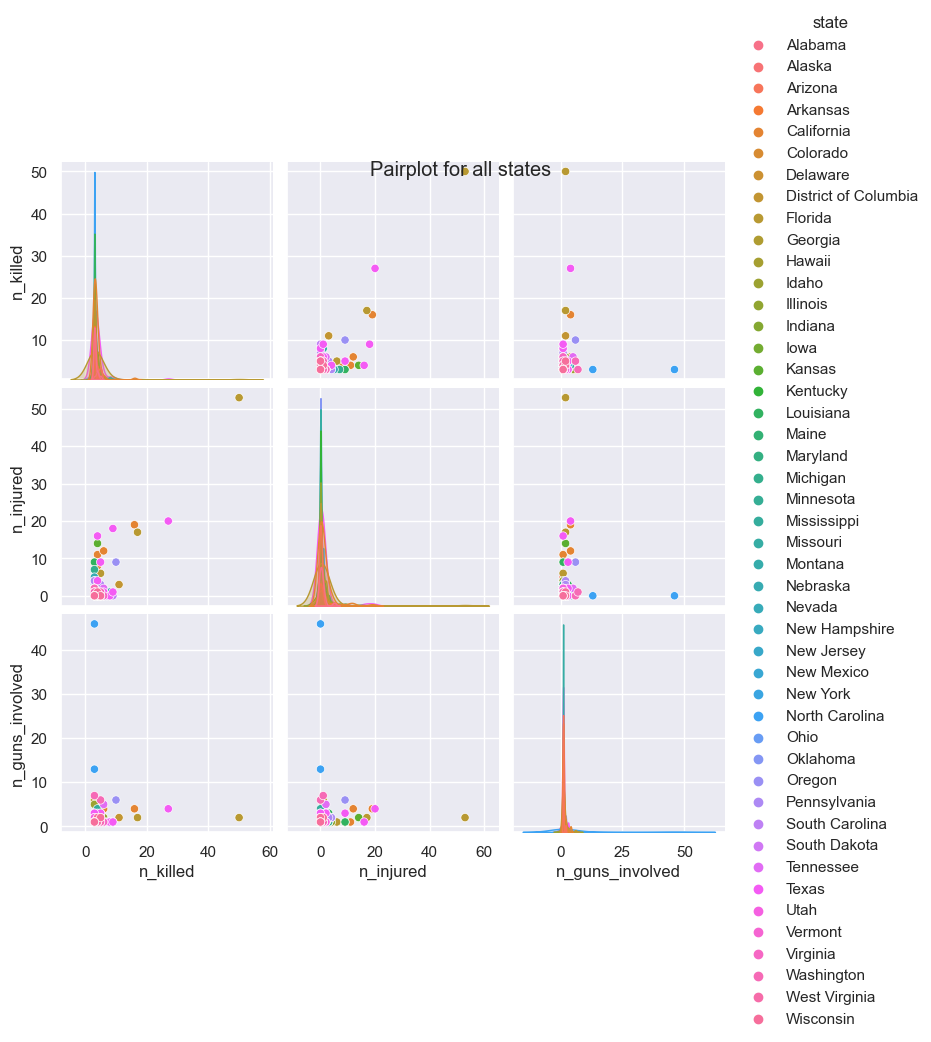

In [287]:
sns.pairplot(pair_df, kind='scatter',hue='state')
plt.suptitle('Pairplot for all states')
plt.show()

### Pair plot by state

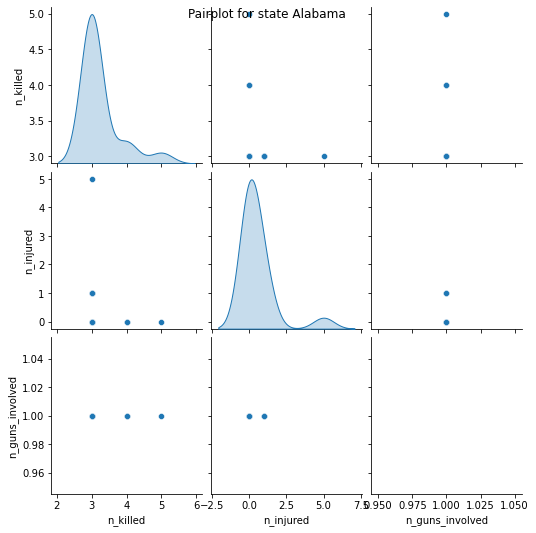

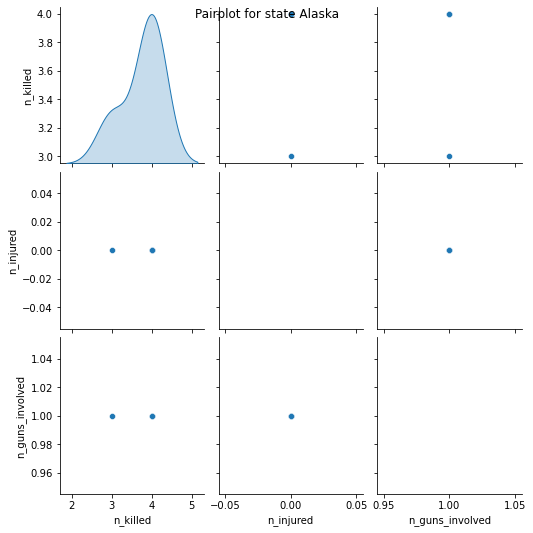

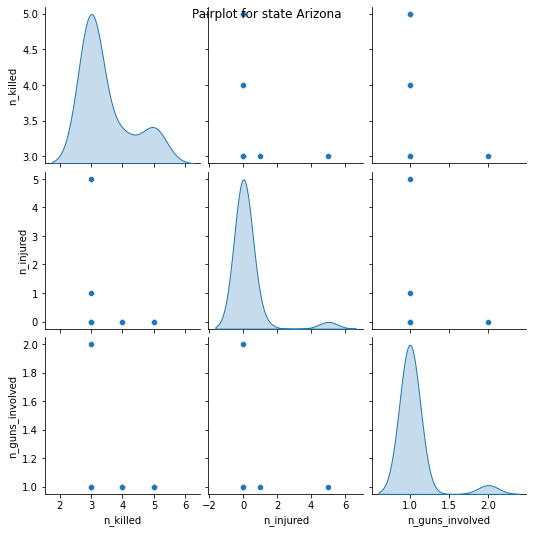

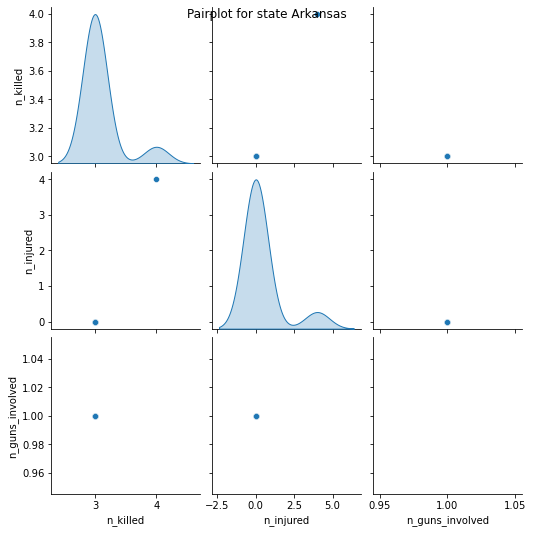

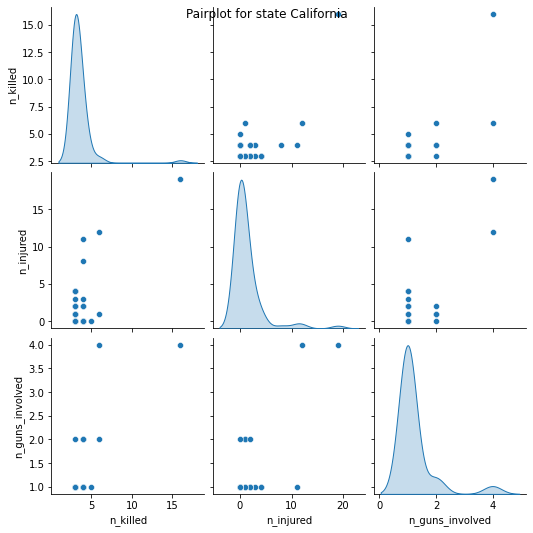

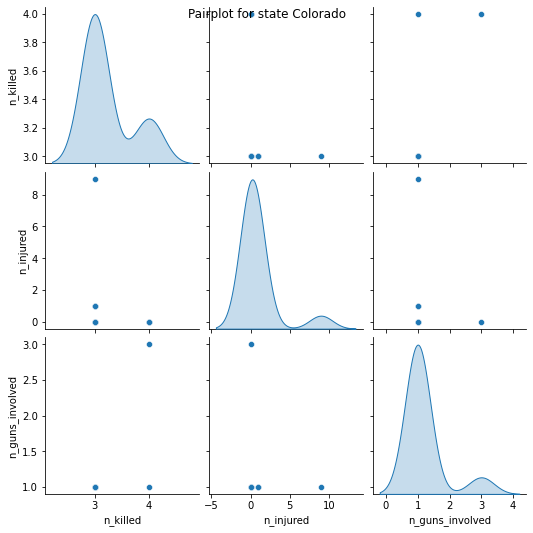

C:\Users\15599\Anaconda\lib\site-packages\seaborn\axisgrid.py:1278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


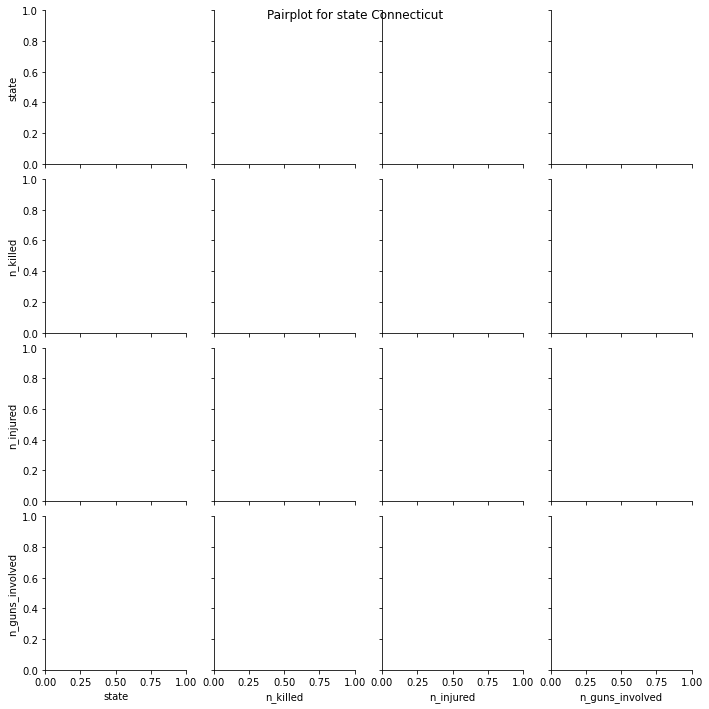

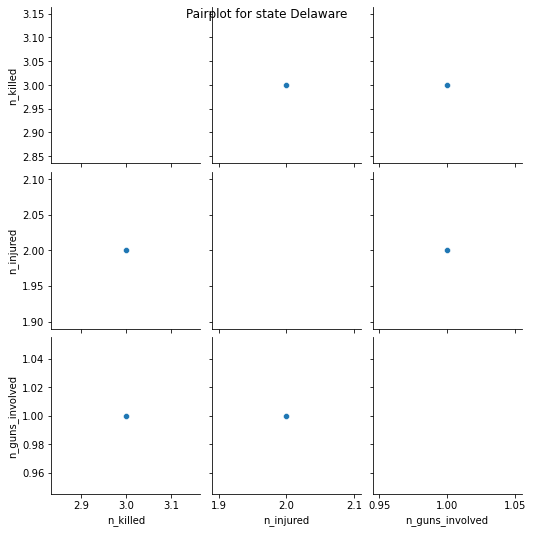

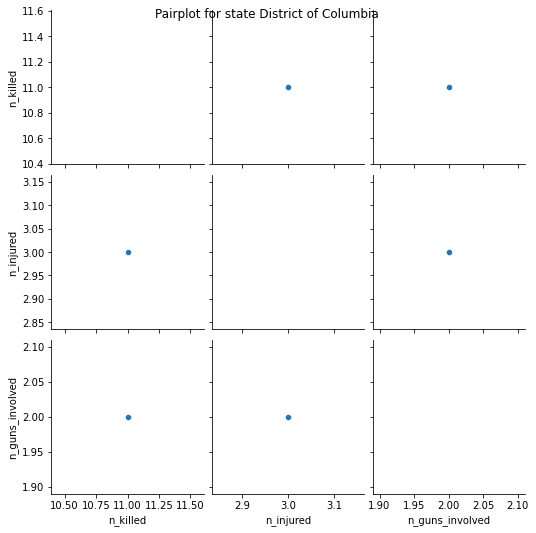

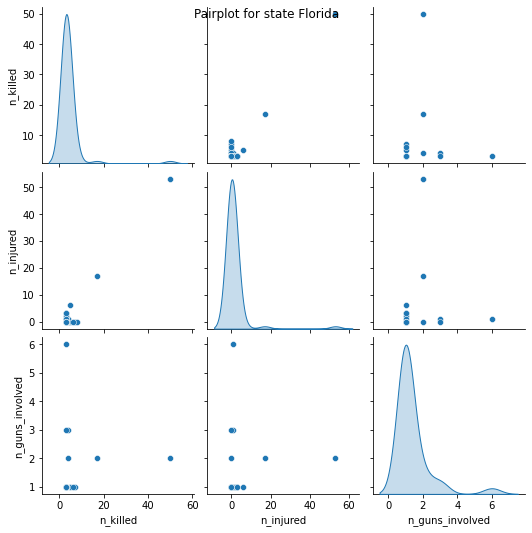

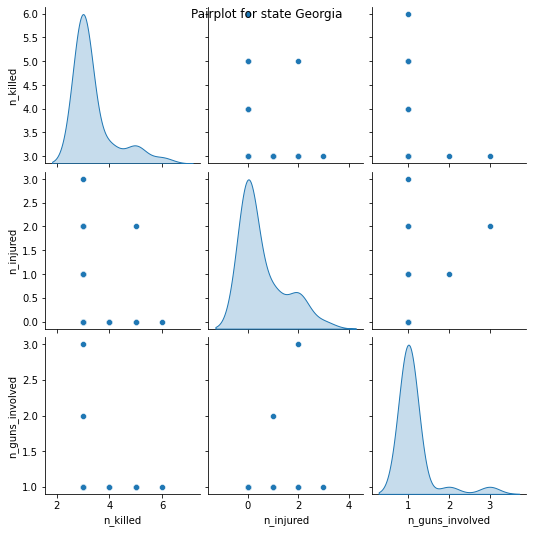

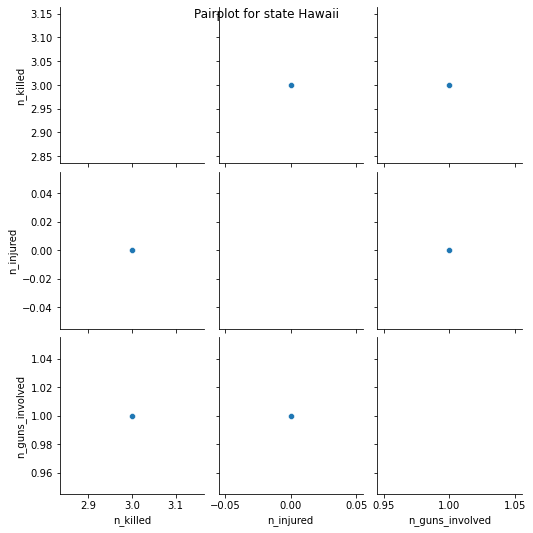

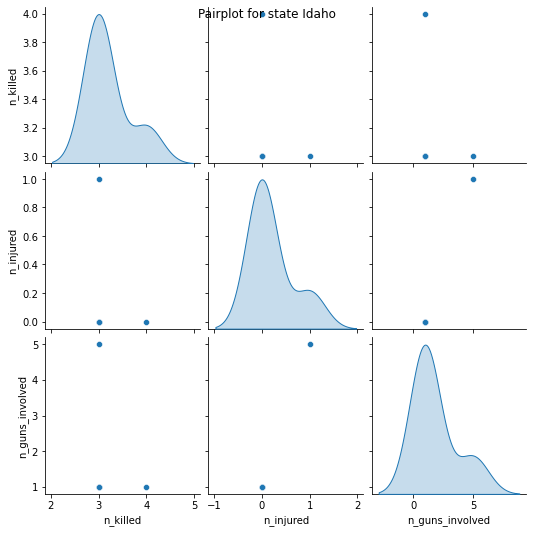

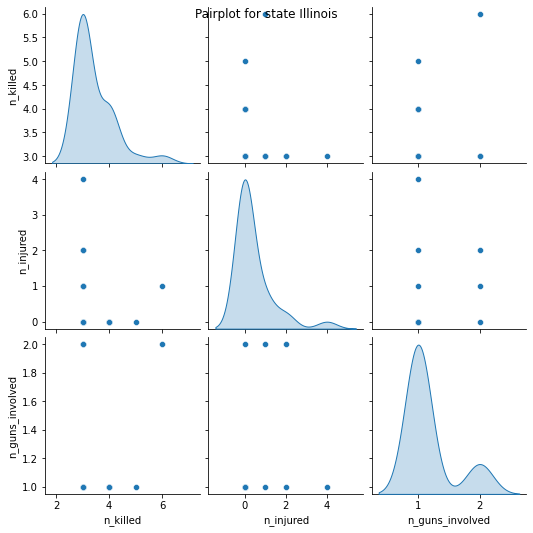

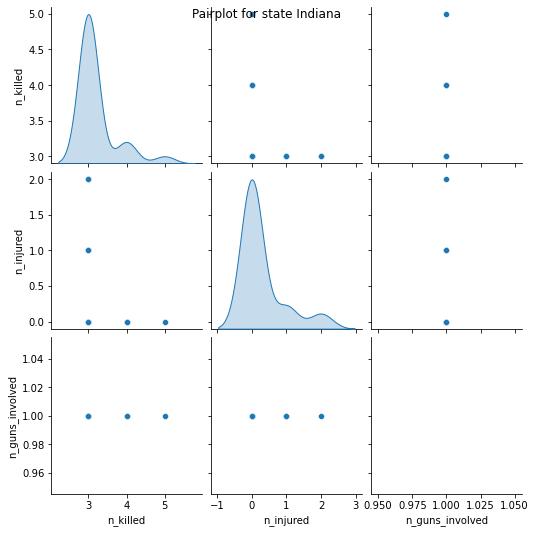

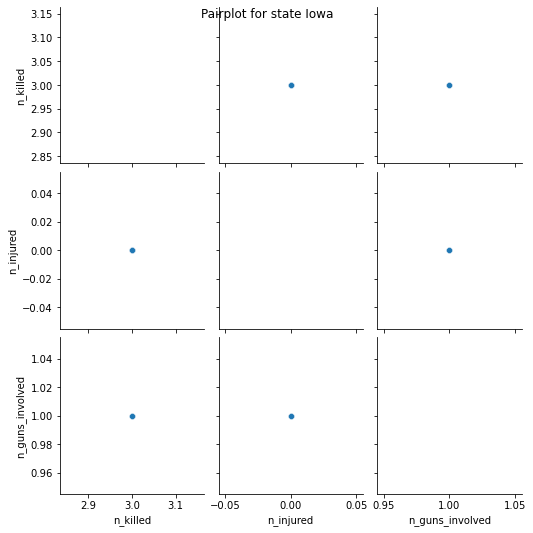

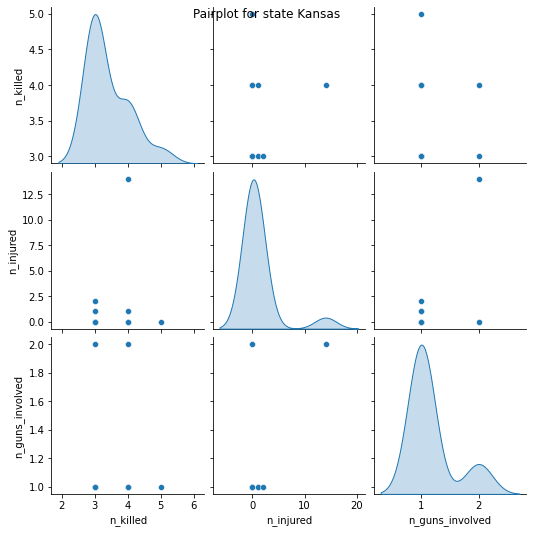

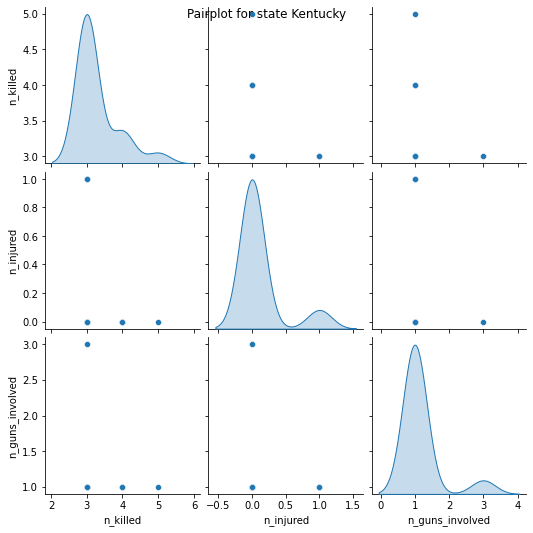

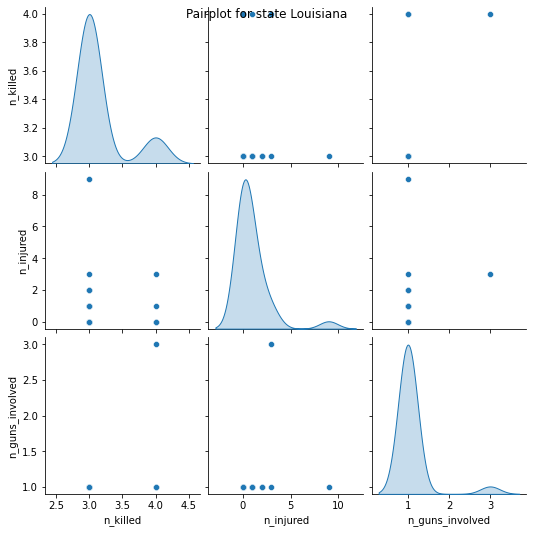

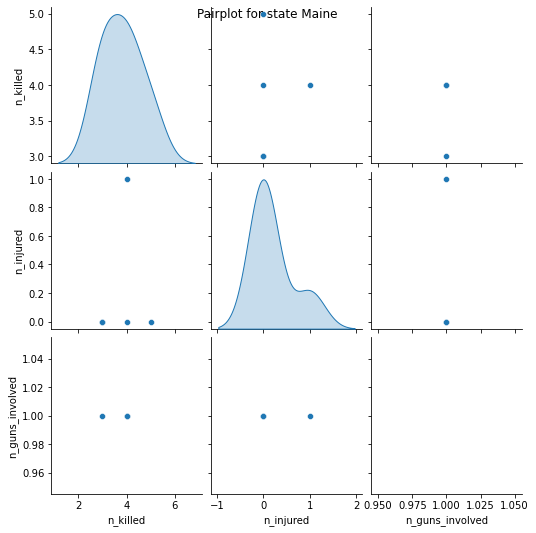

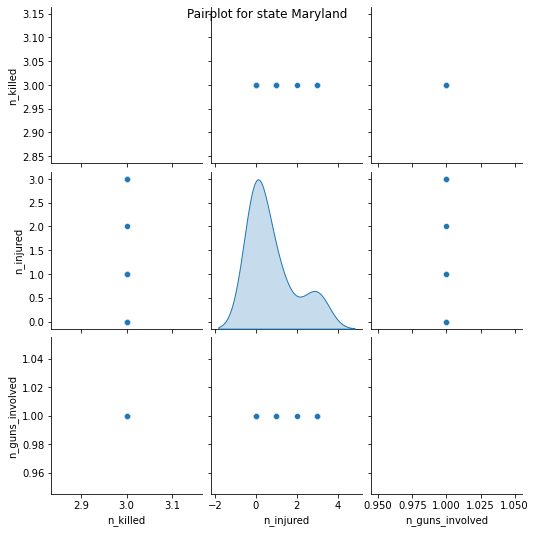

C:\Users\15599\Anaconda\lib\site-packages\seaborn\axisgrid.py:1278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


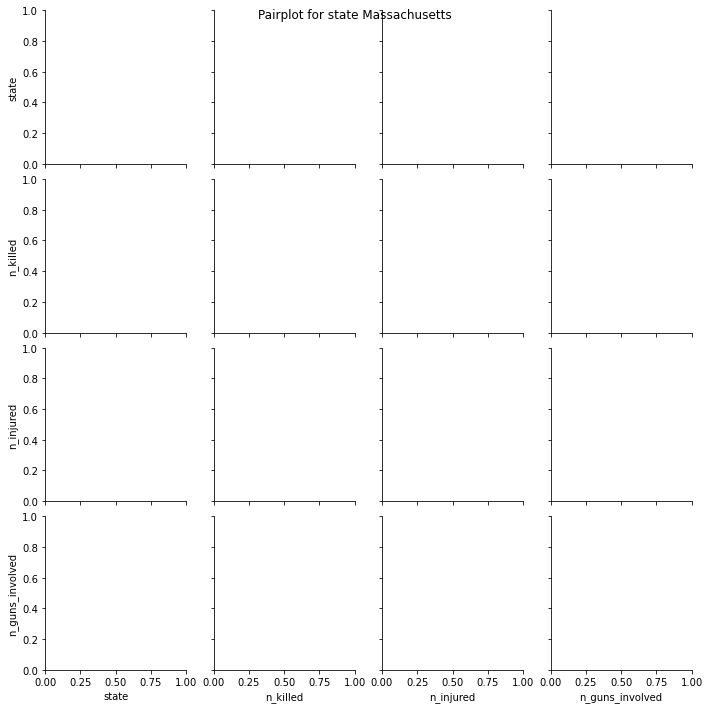

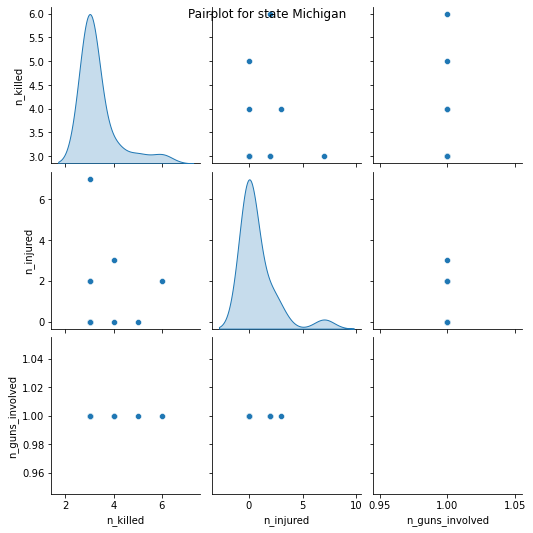

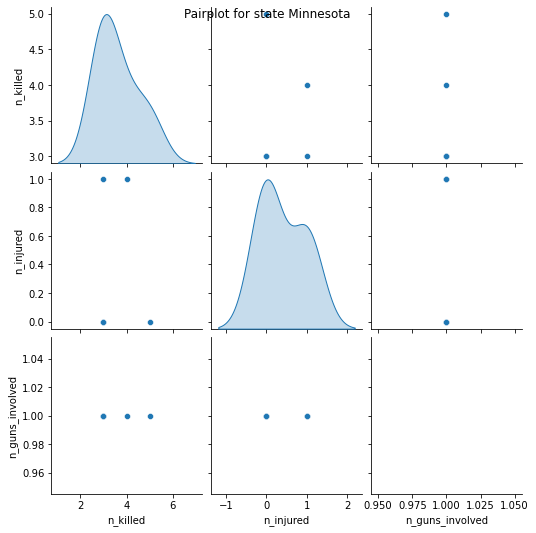

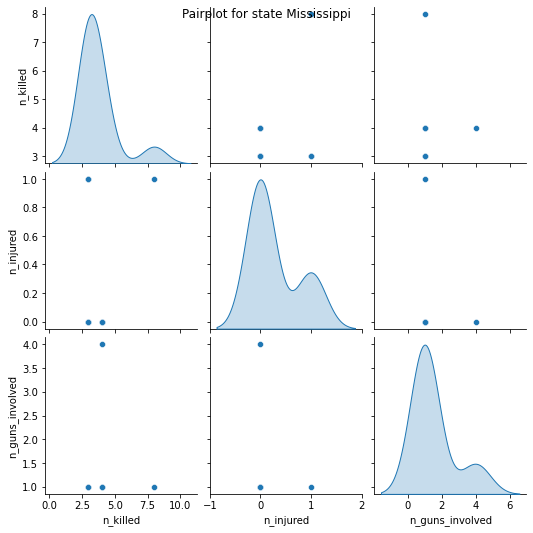

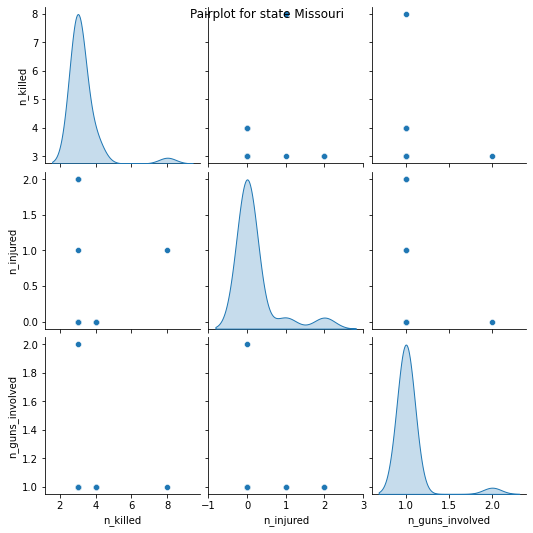

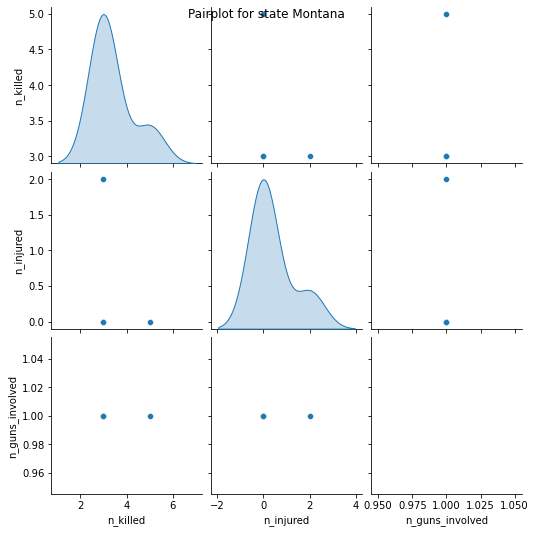

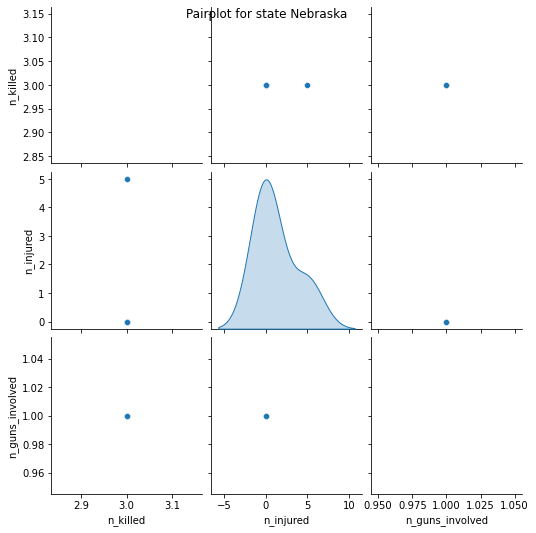

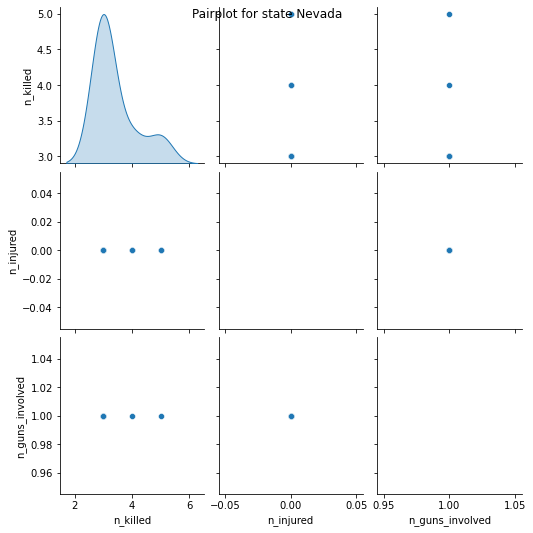

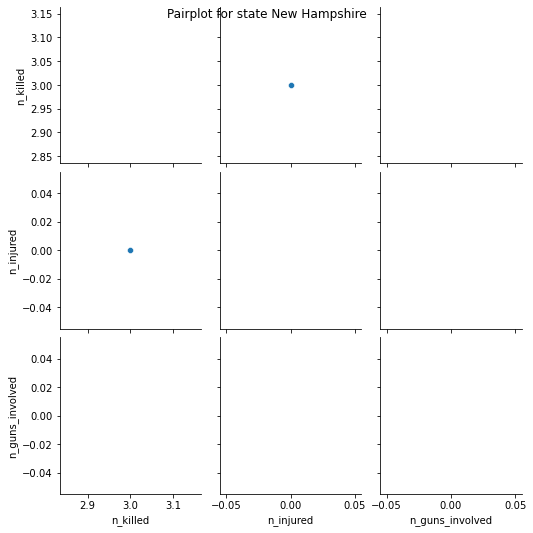

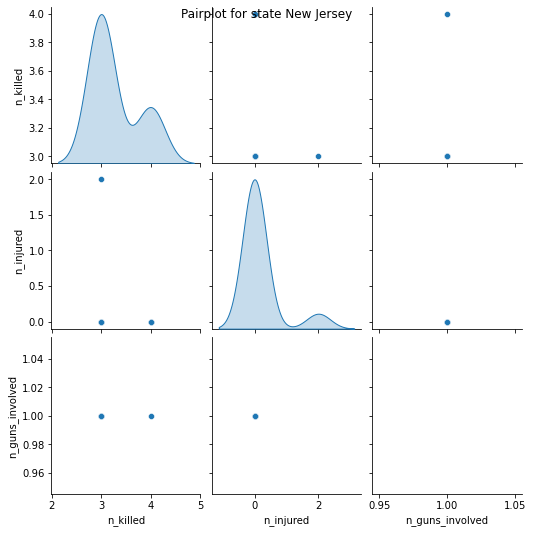

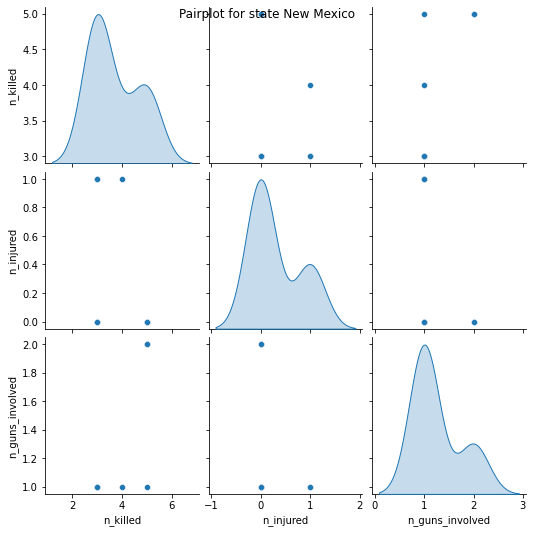

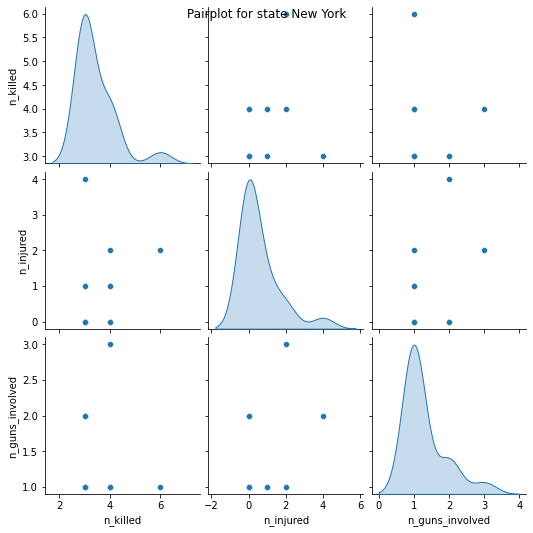

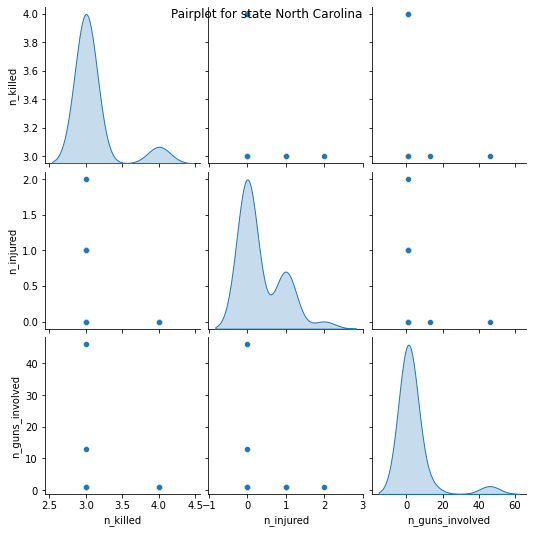

C:\Users\15599\Anaconda\lib\site-packages\seaborn\axisgrid.py:1278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


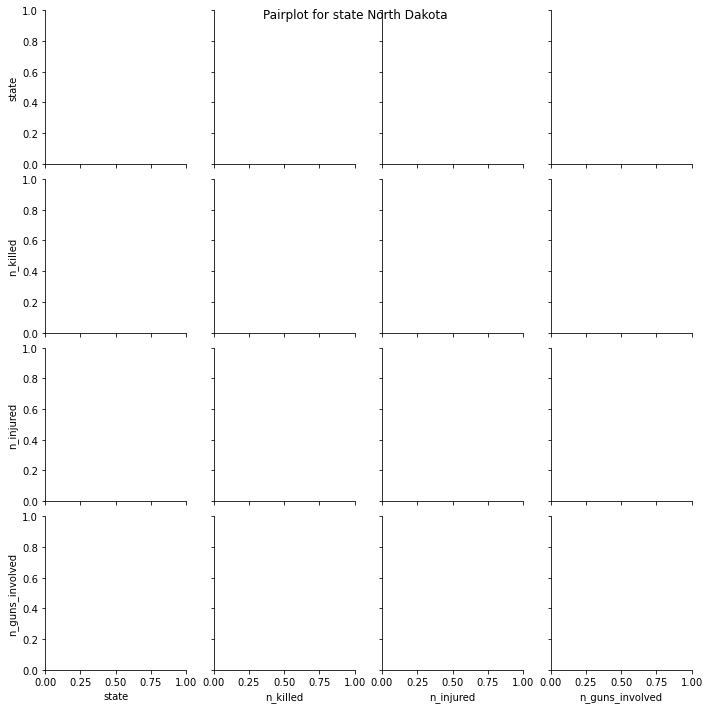

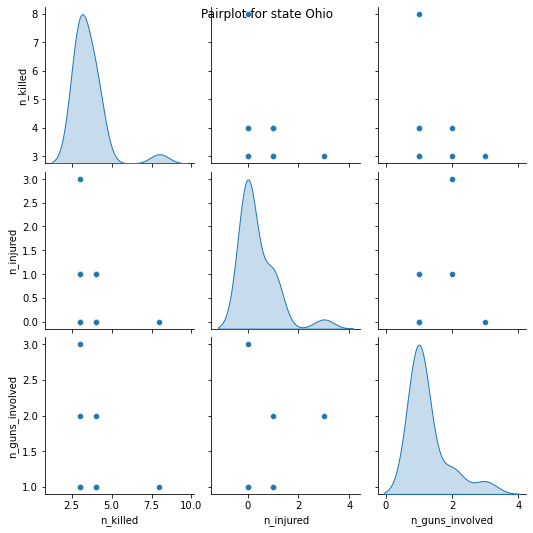

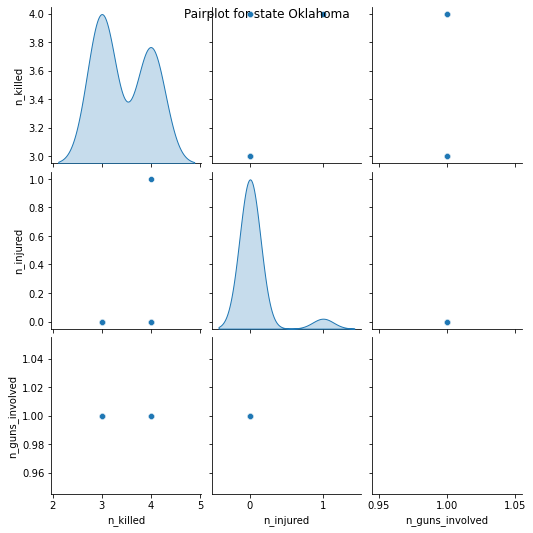

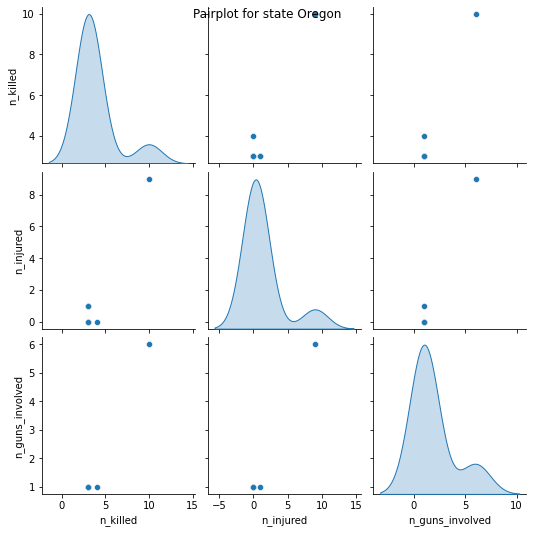

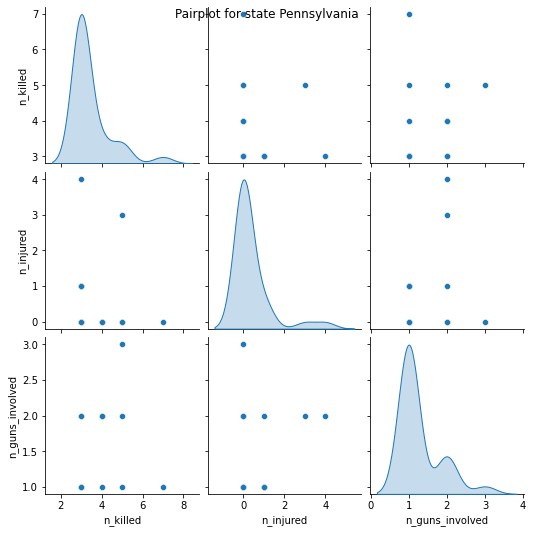

C:\Users\15599\Anaconda\lib\site-packages\seaborn\axisgrid.py:1278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


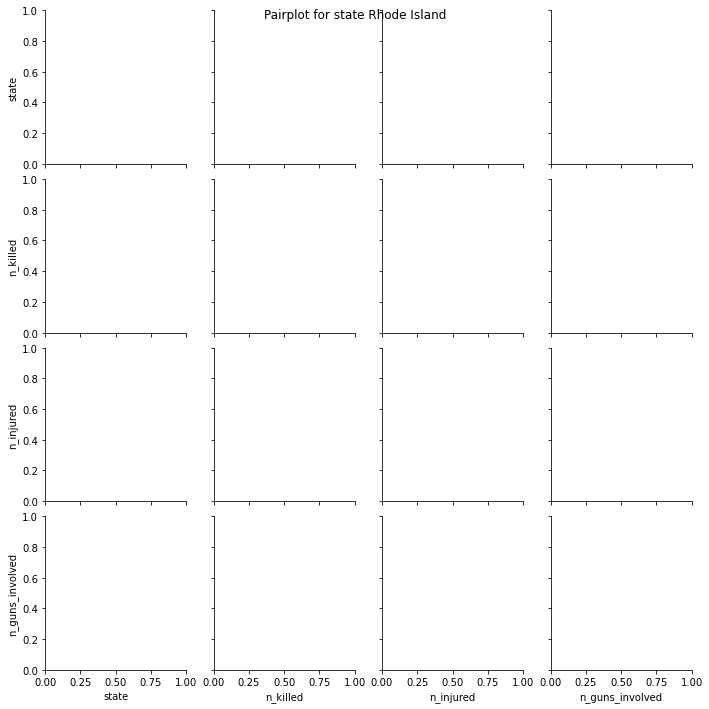

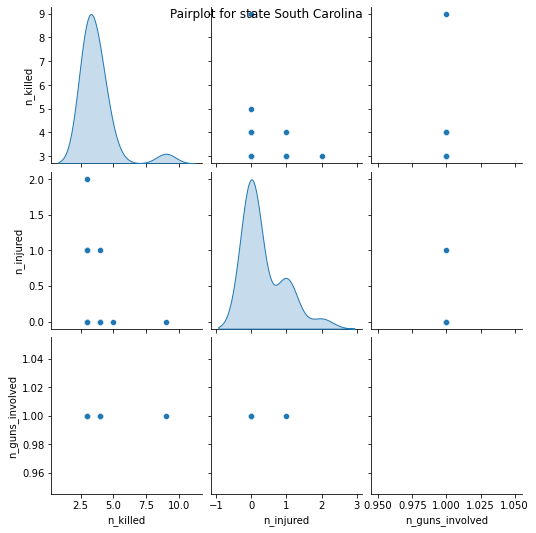

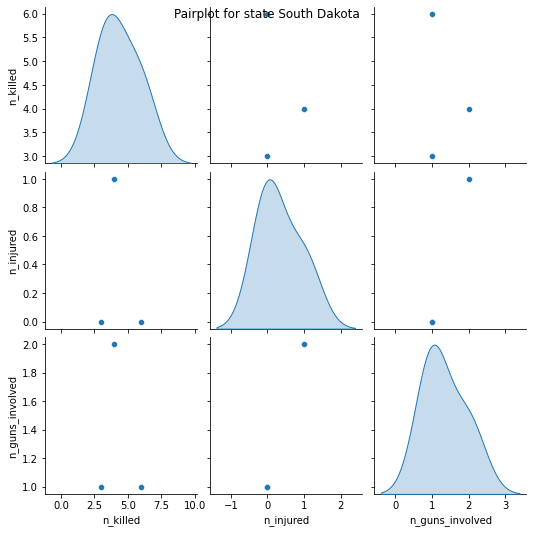

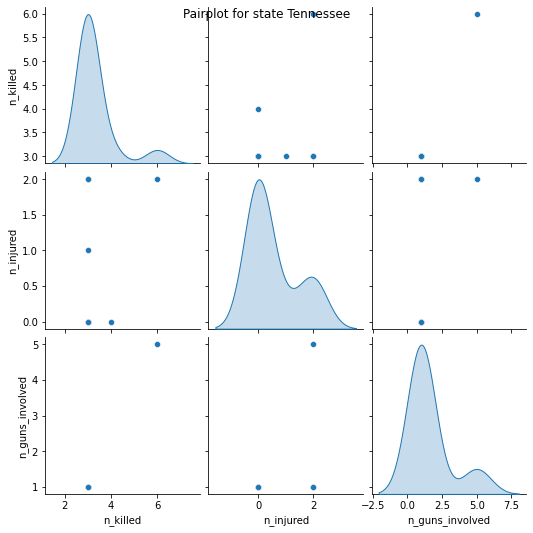

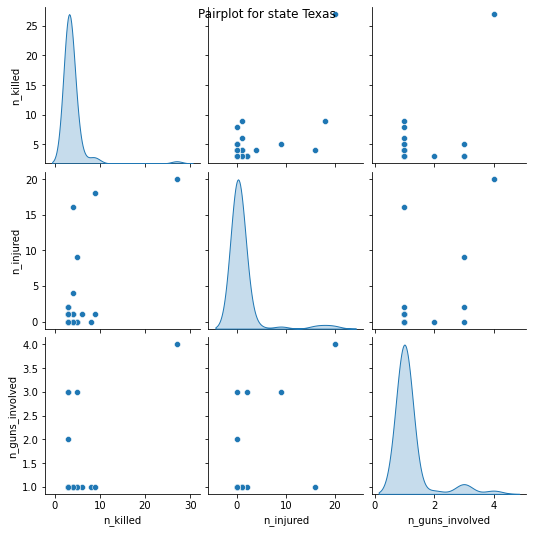

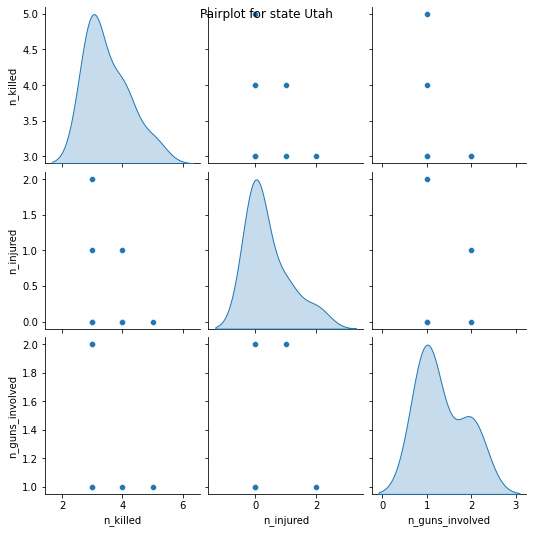

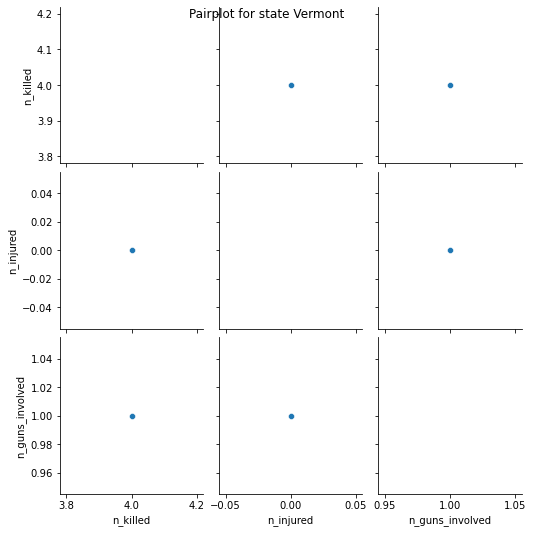

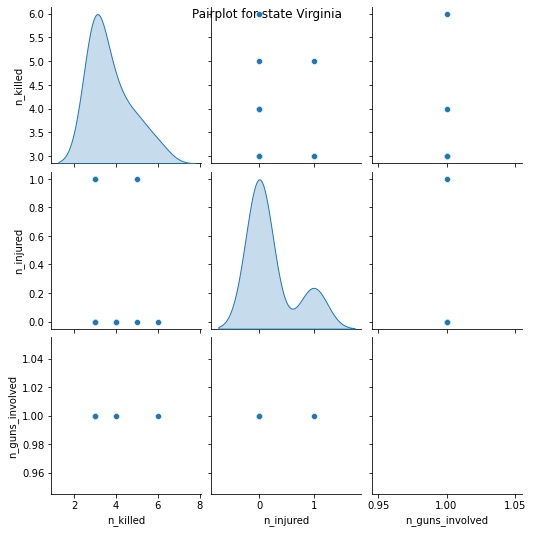

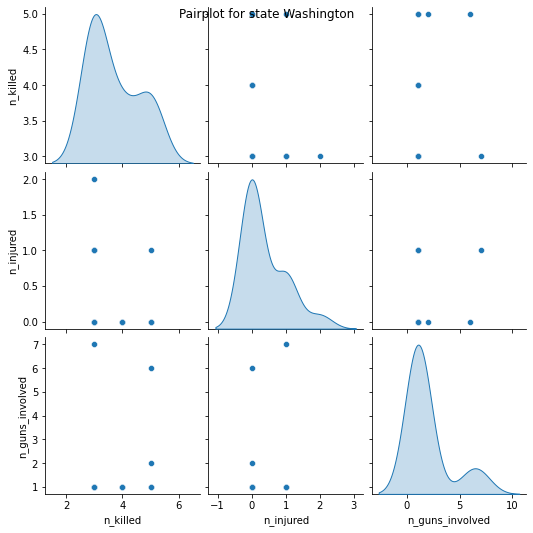

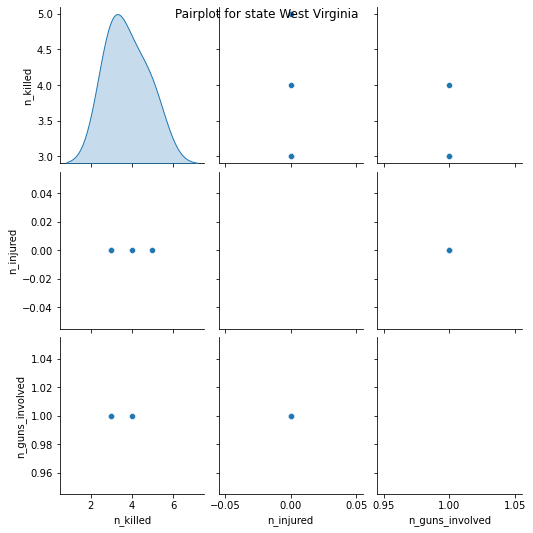

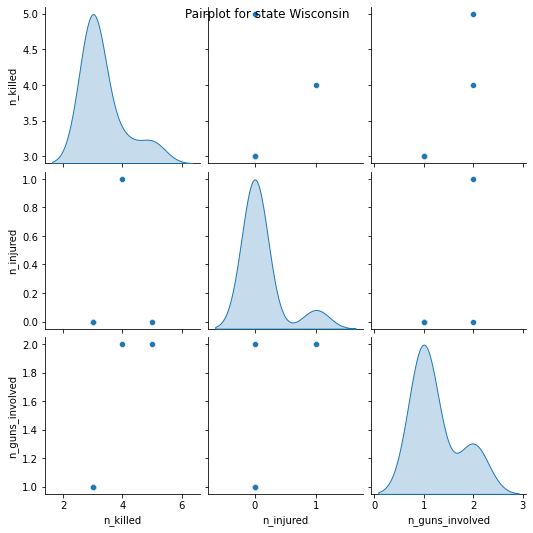

C:\Users\15599\Anaconda\lib\site-packages\seaborn\axisgrid.py:1278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.hue_vals = pd.Series(["_nolegend_"] * len(data),


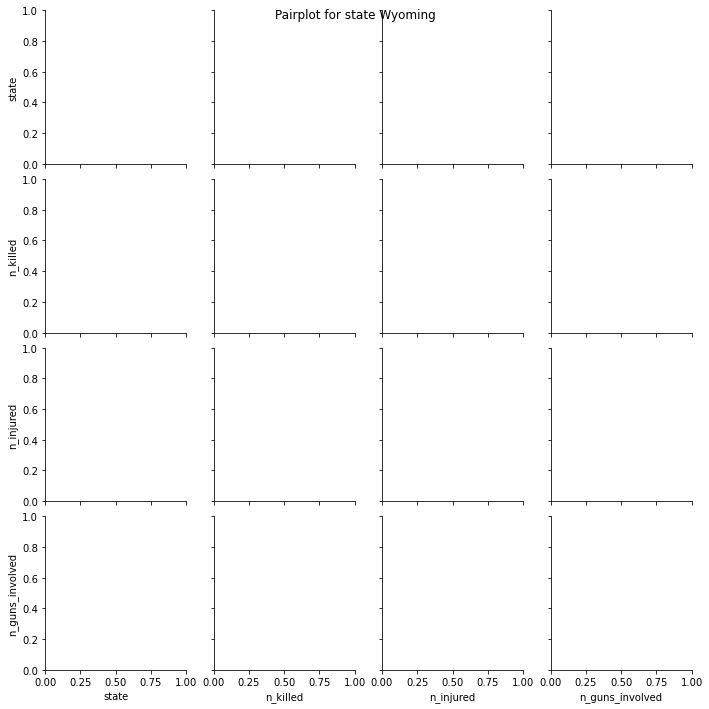

In [156]:
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", 
               "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", 
               "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", 
               "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", 
               "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
               "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", 
               "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
for state in sorted(state_names) :
    sns.pairplot(pair_df[pair_df['state']==state],kind='scatter',diag_kind='kde')
    plt.suptitle('Pairplot for state {}'.format(state))
    plt.show()

### Histogram of States vs Incidents

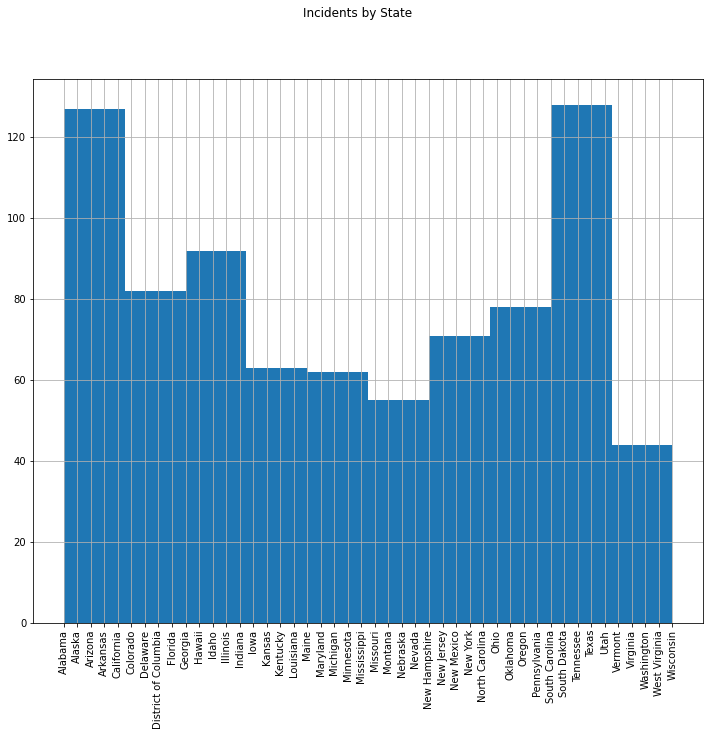

In [42]:
gun_df['state'].hist(xrot=90, figsize=(12.0,10.0))
plt.suptitle("Incidents by State")
plt.show()

### Histogram of Guns by Type

In [31]:
Guns =["Unknown_Guns", "Handgun", "Shotgun", "Rifle", "Other", "Automatic"]
c=[]
for gun in Guns:
    c.append(gun_df[gun].sum())
dict1 = {'Gun':Guns, 'Count':c}
gun_typedf=pd.DataFrame.from_dict(dict1)

Text(0.5, 0, 'Gun Type')

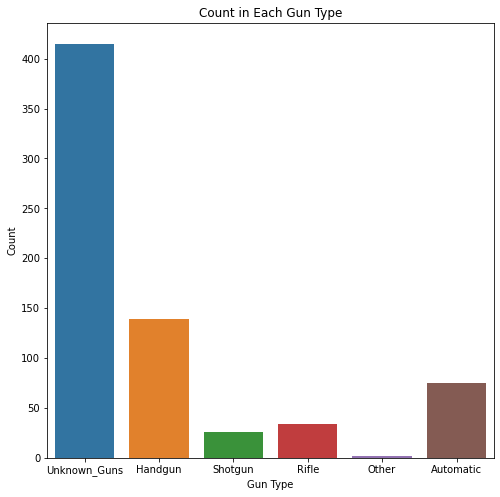

In [34]:
plt.figure(figsize= (8,8))
sns.barplot(x="Gun", y = "Count", data = gun_typedf).set(title="Count in Each Gun Type")
plt.xlabel("Gun Type")


### Longitude vs Latitude by Number Killed

#### USA Map

Text(0.5, 0.98, 'Comparison of Number of Killed by Longitude and Latitude')

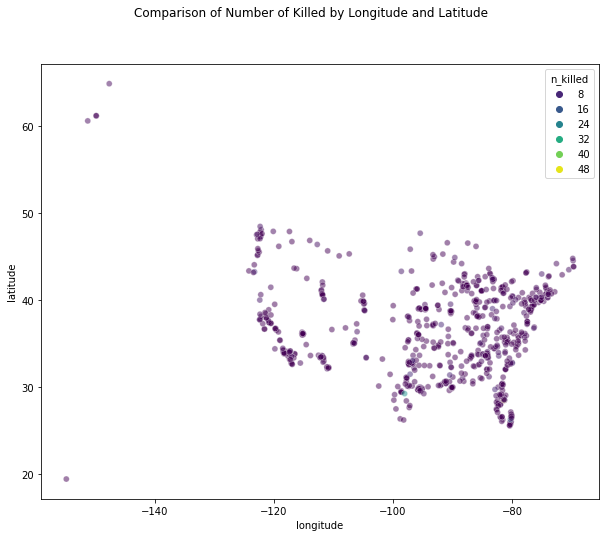

In [37]:
plt.figure(figsize= (10,8))
sns.scatterplot(data = gun_df, x="longitude", y="latitude", hue="n_killed",
                    palette="viridis", alpha=0.5)
plt.suptitle(f"Comparison of Number of Killed by Longitude and Latitude")

#### By State

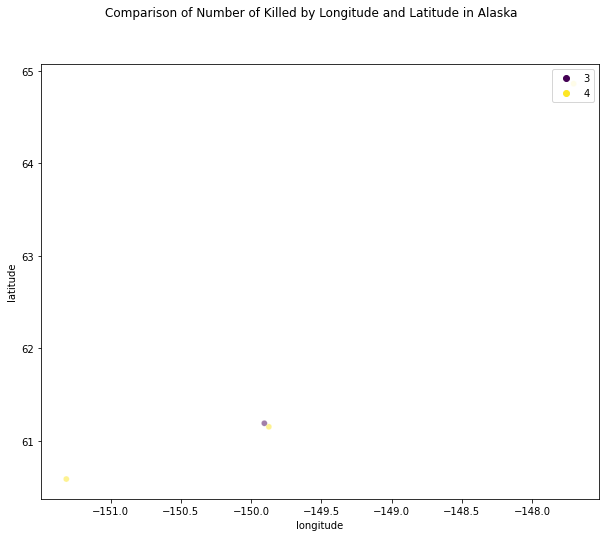

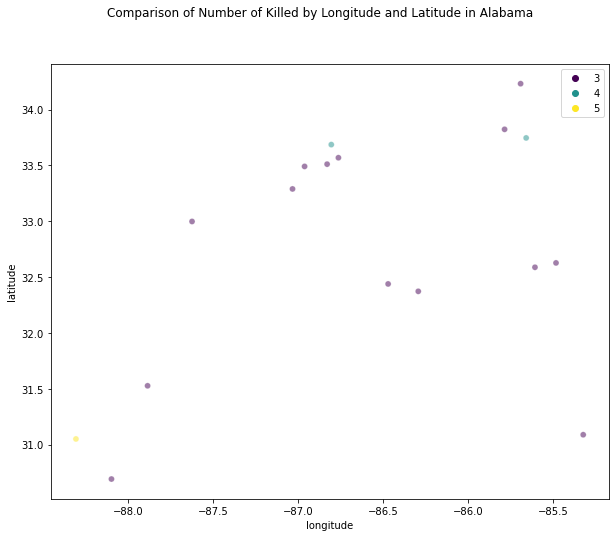

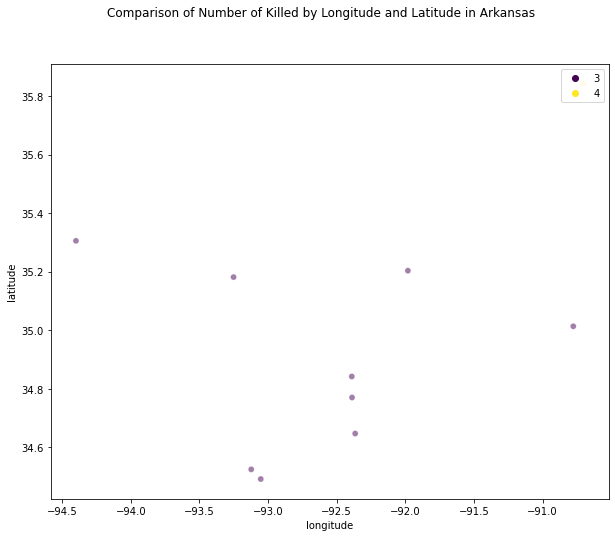

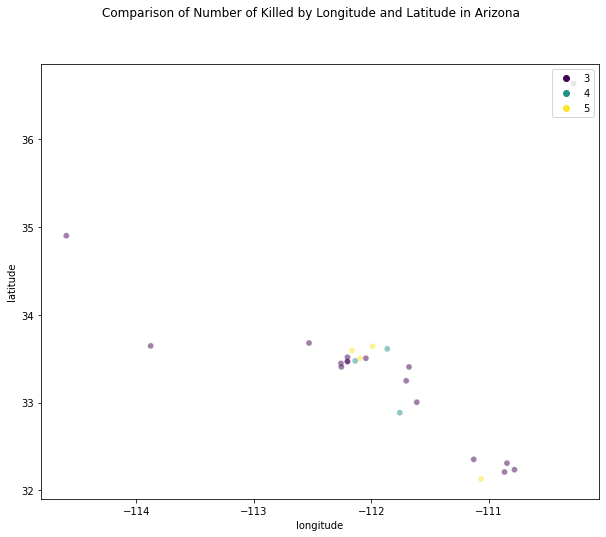

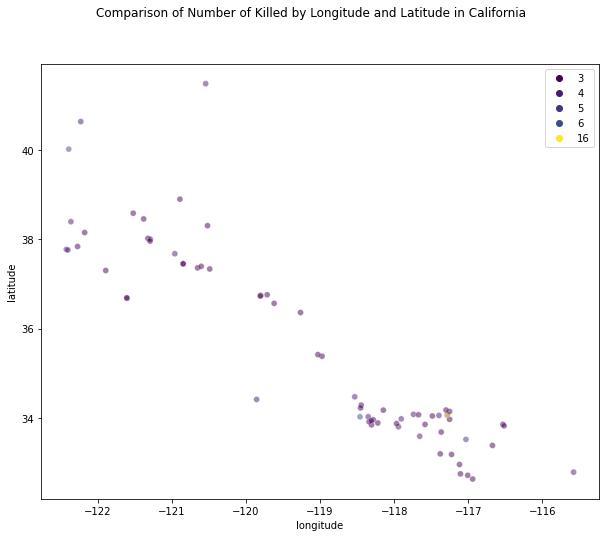

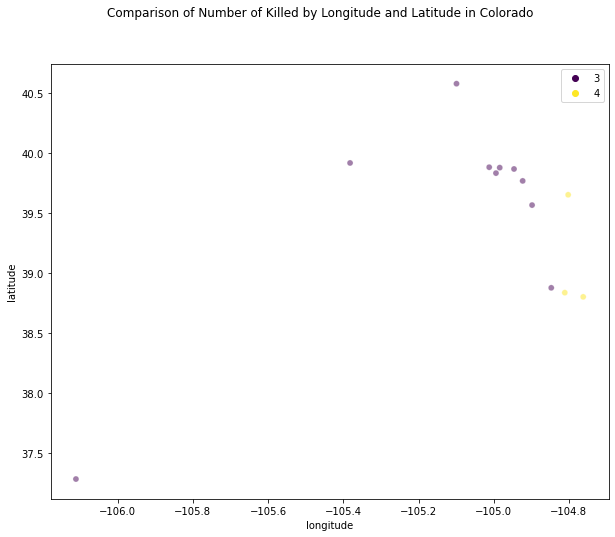

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


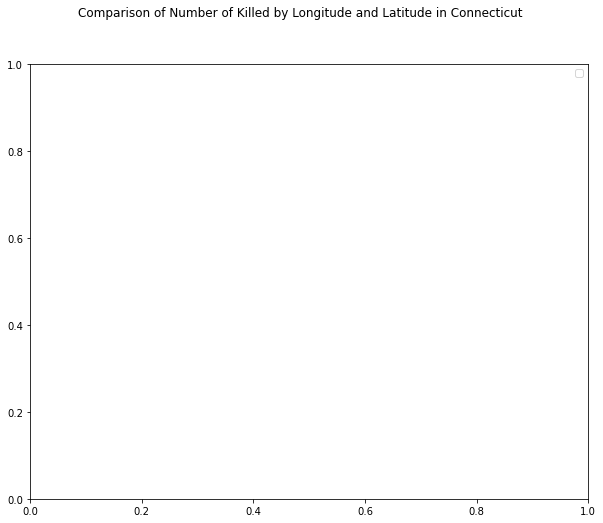

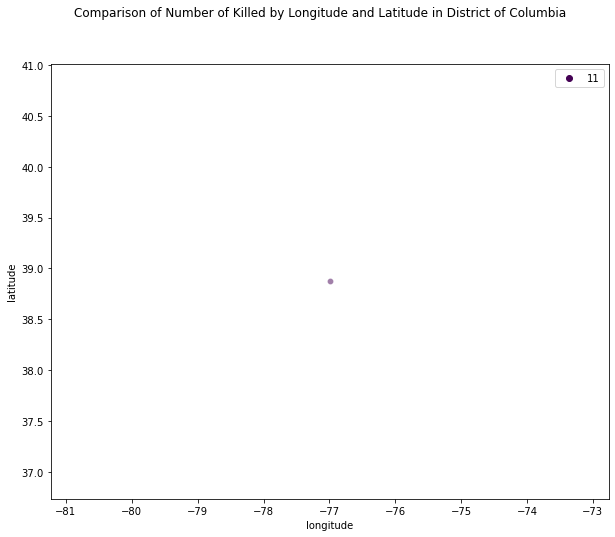

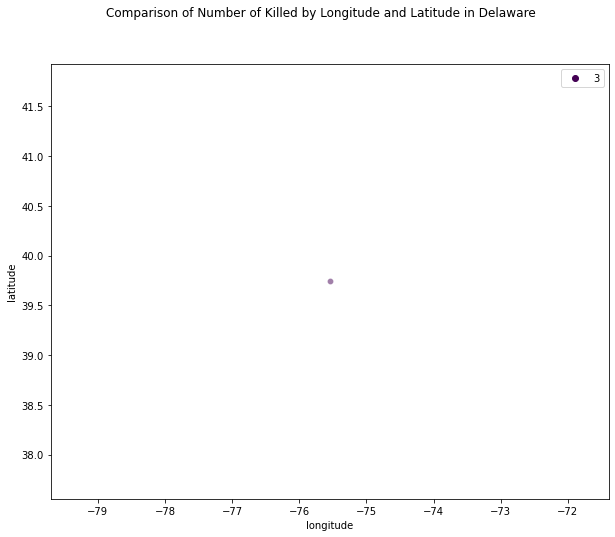

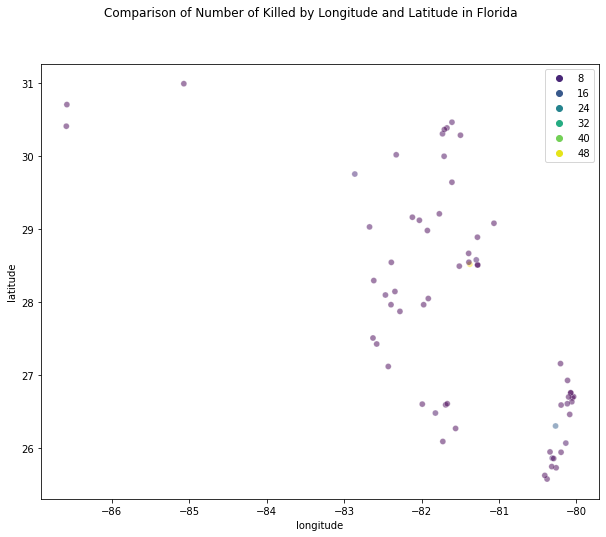

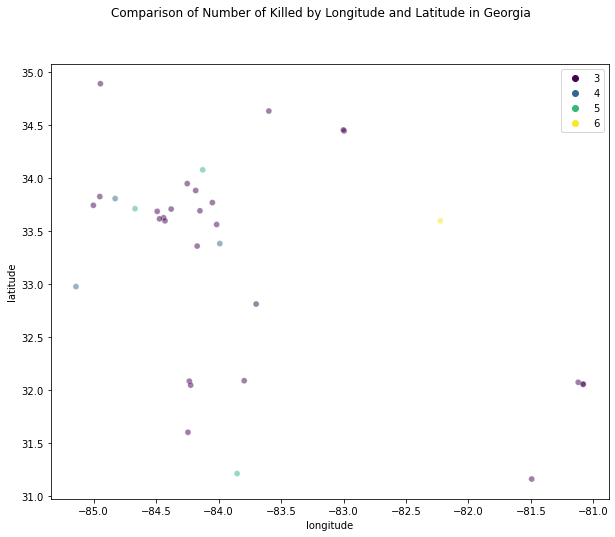

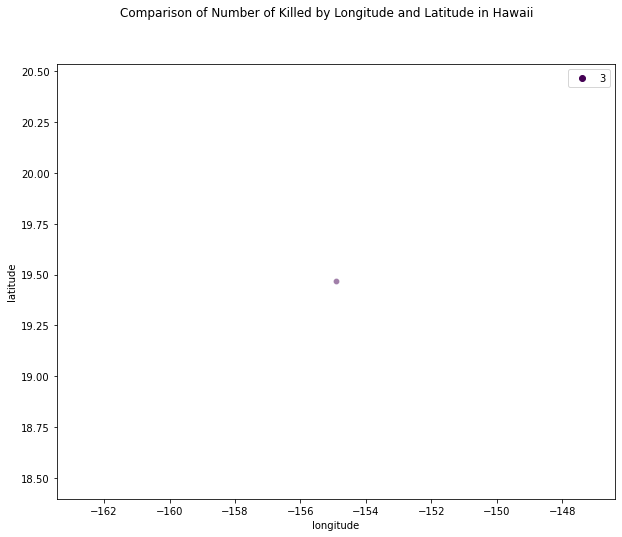

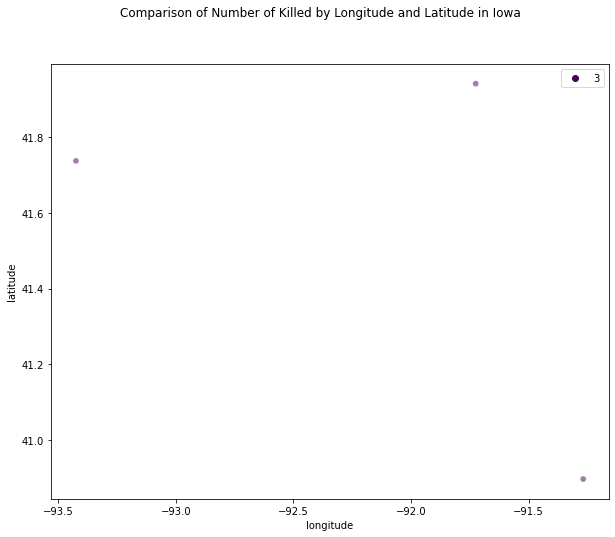

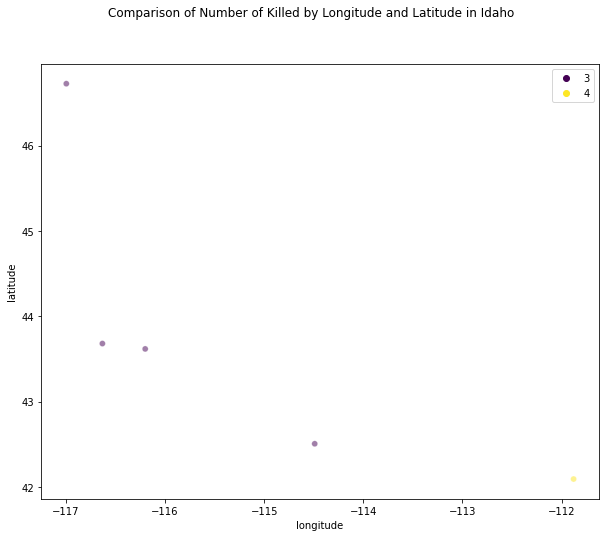

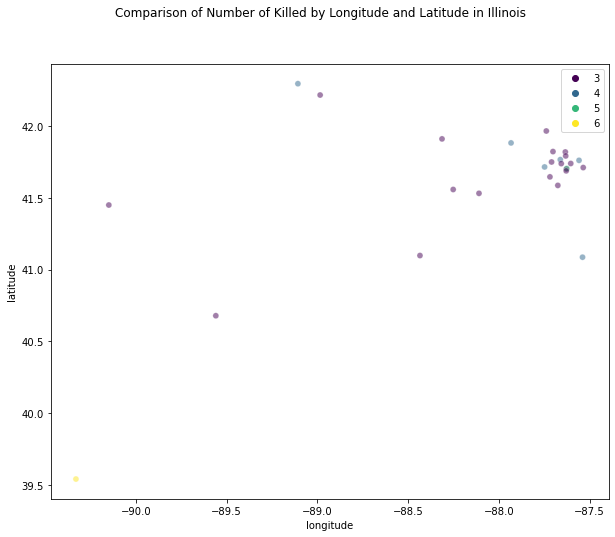

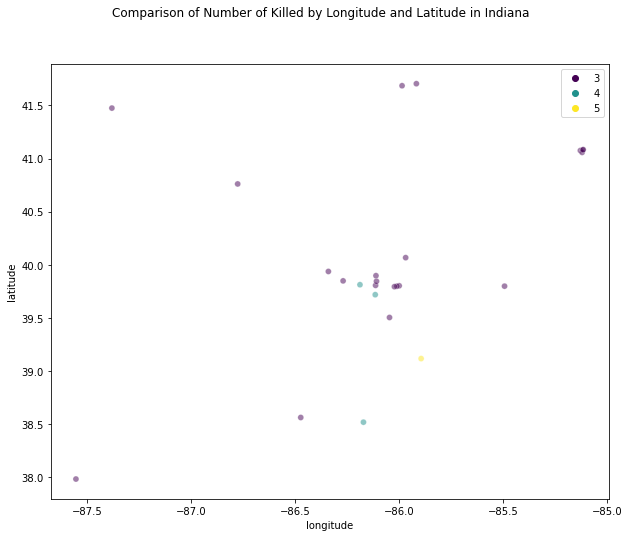

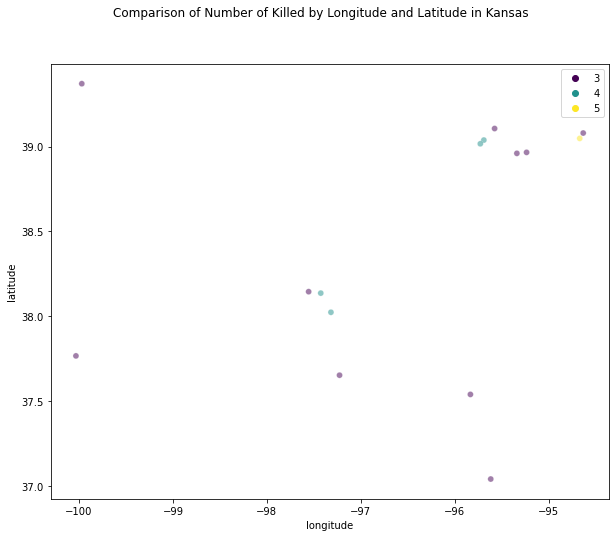

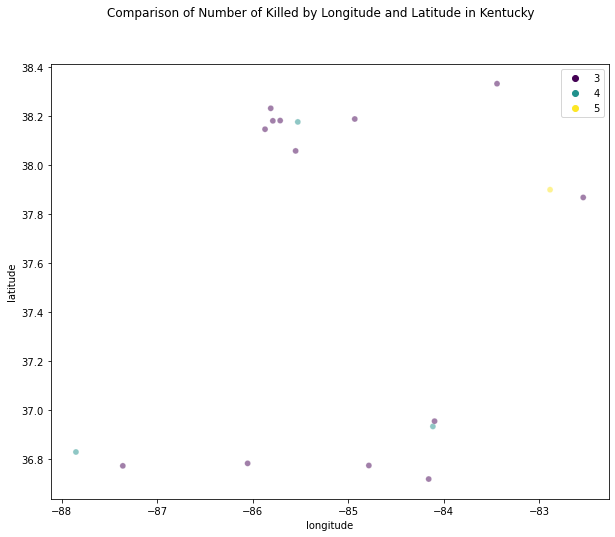

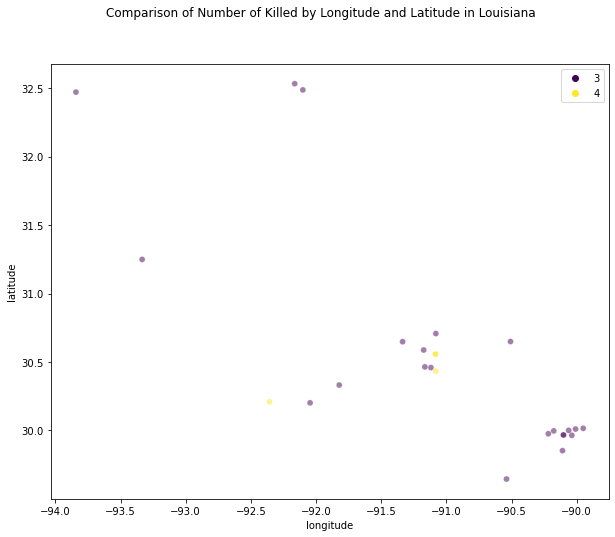

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


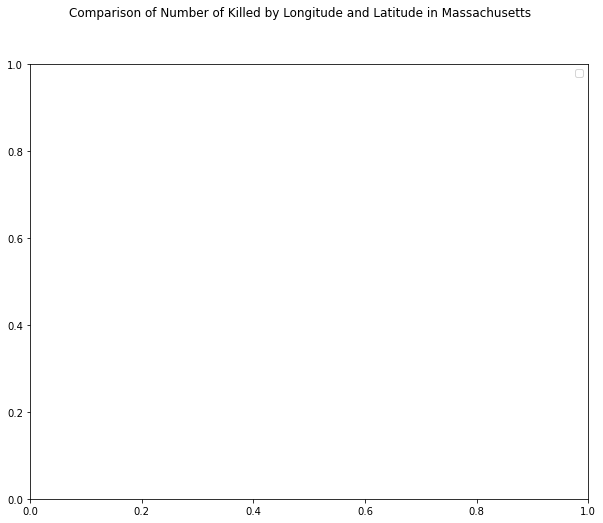

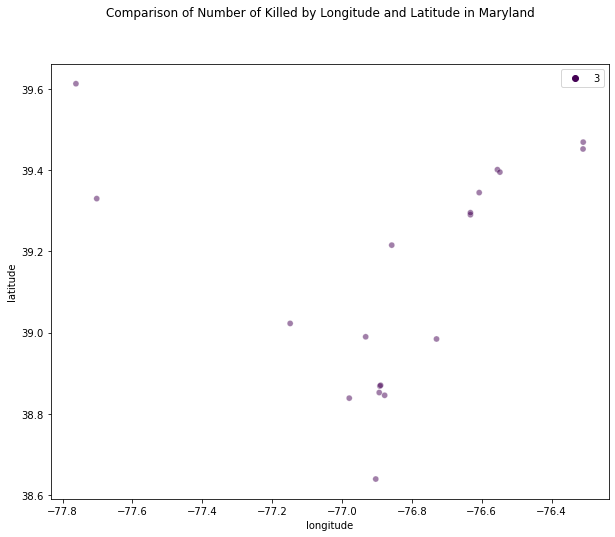

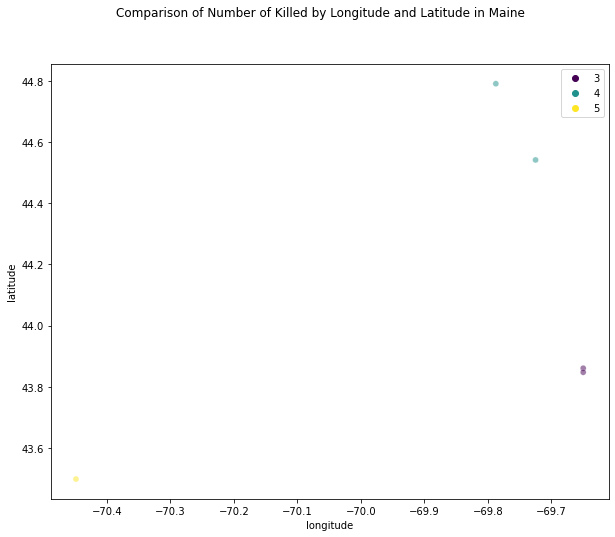

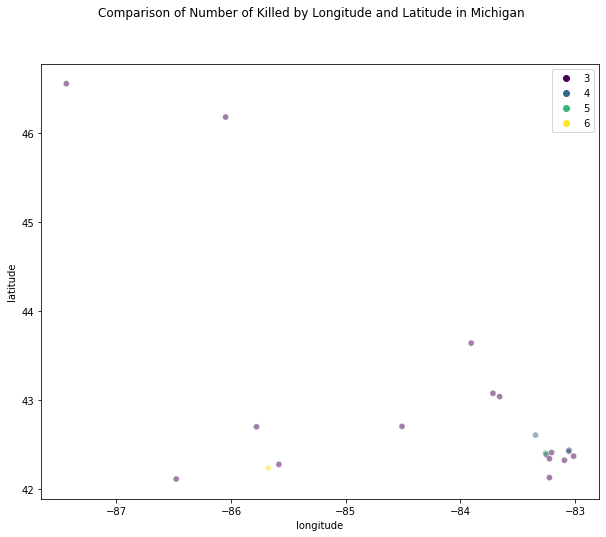

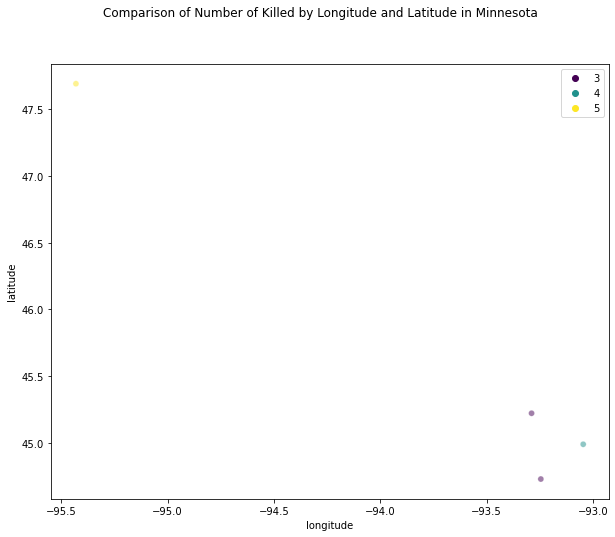

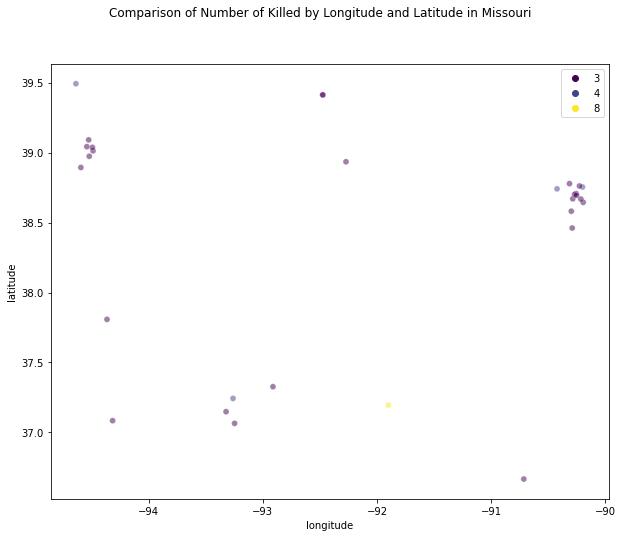

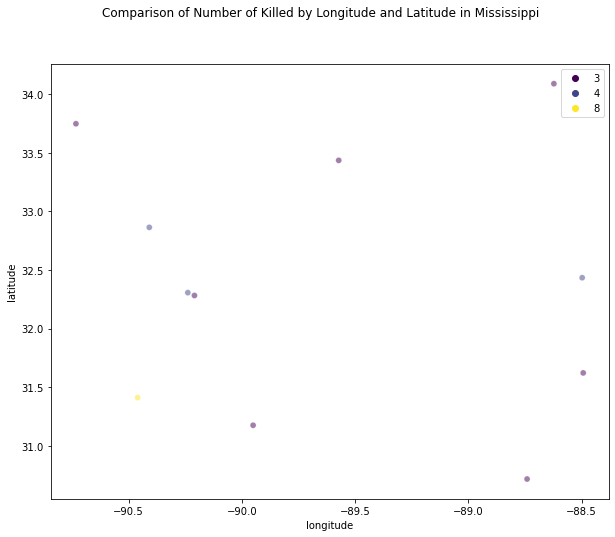

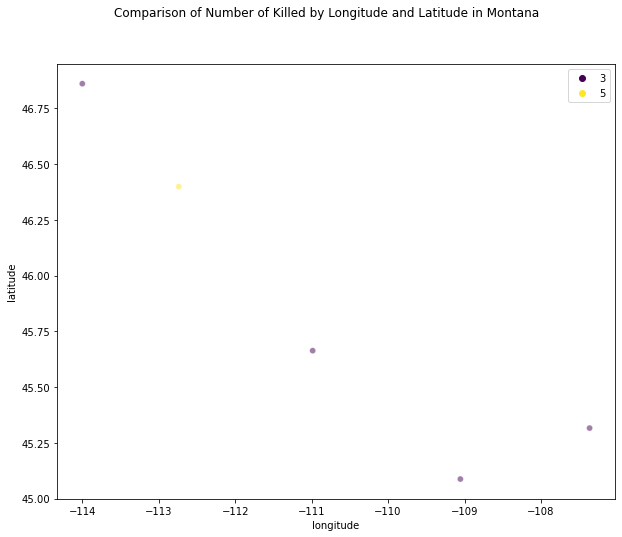

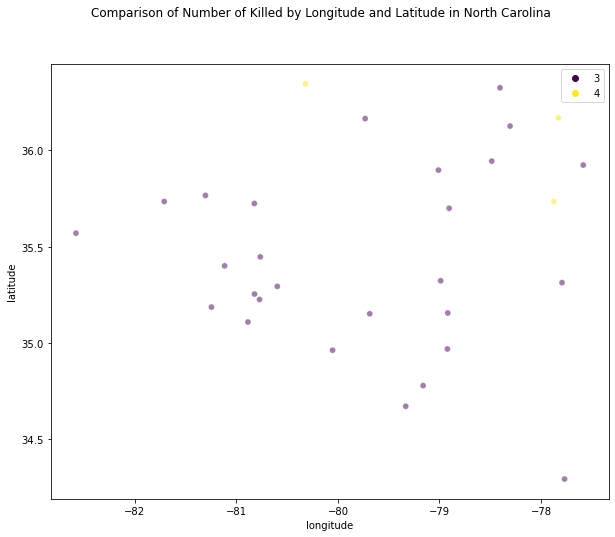

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


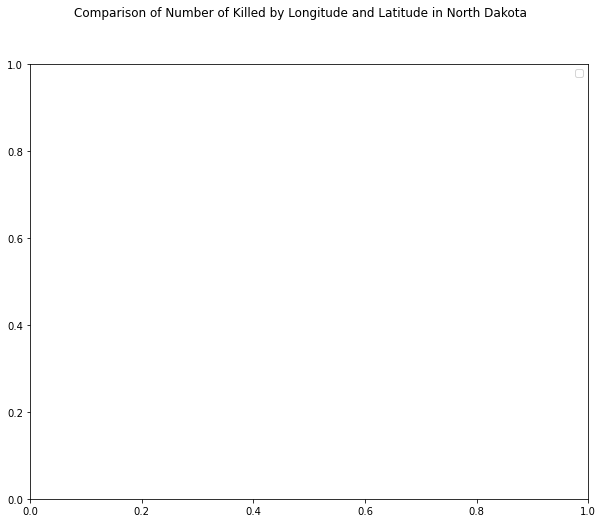

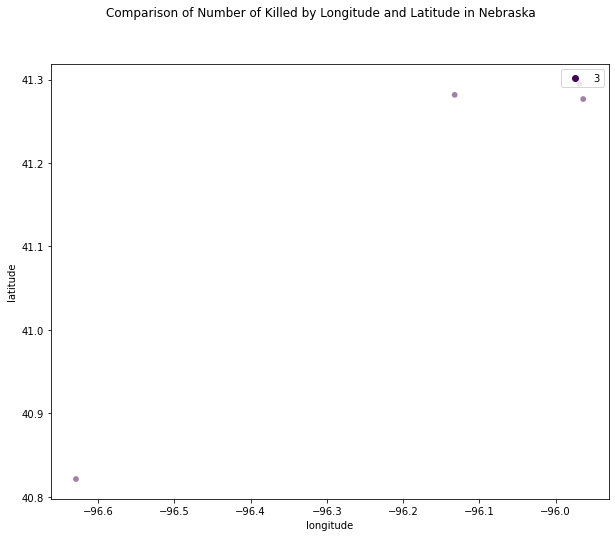

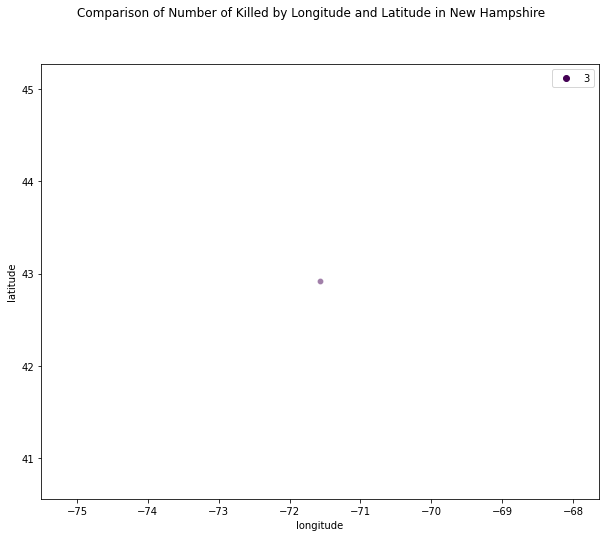

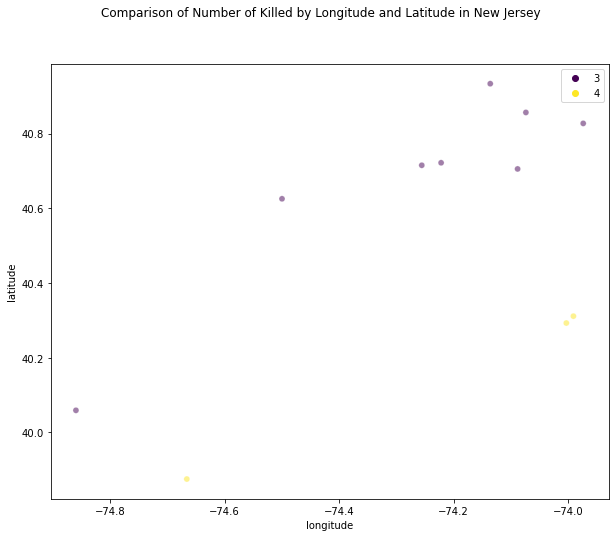

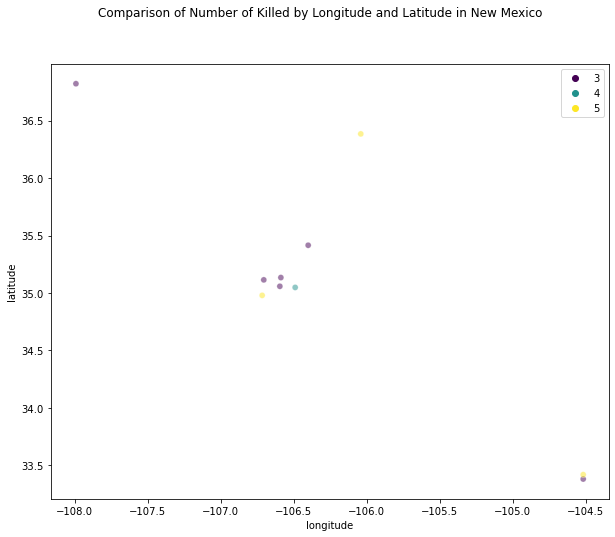

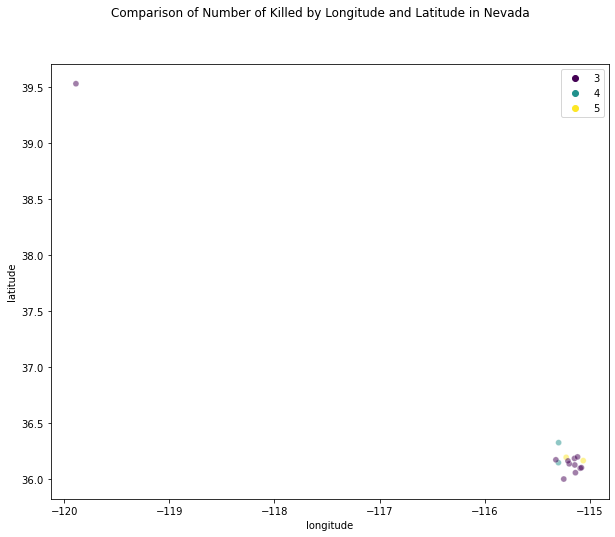

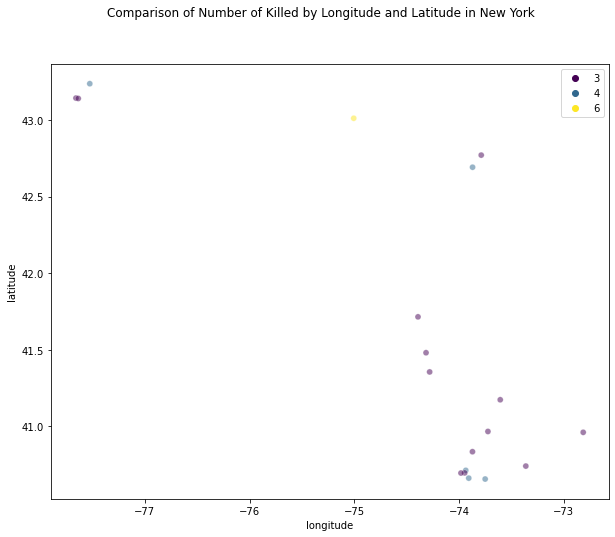

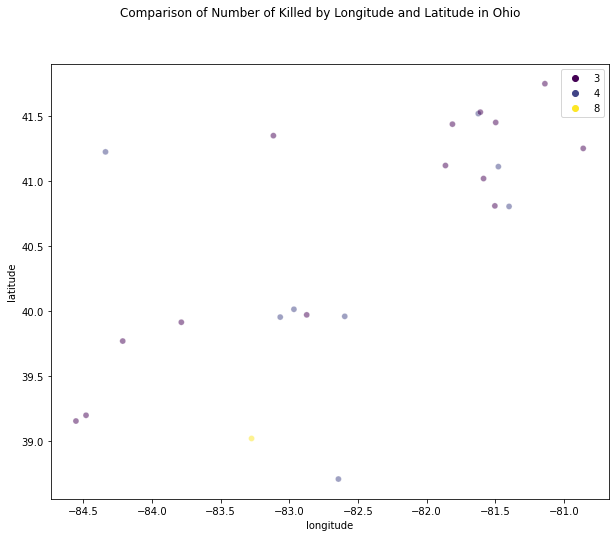

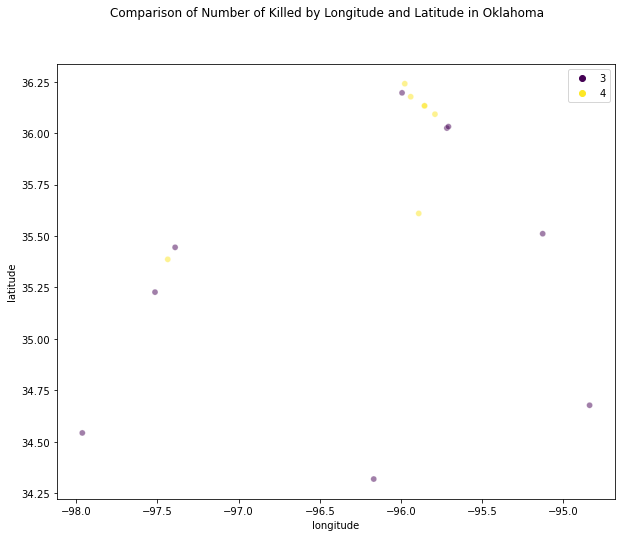

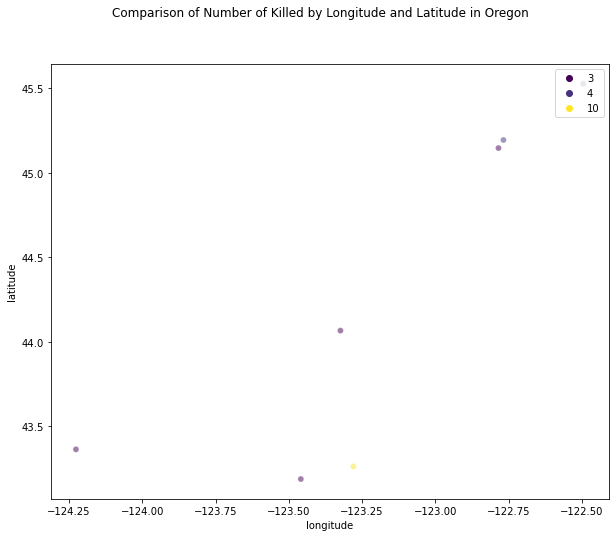

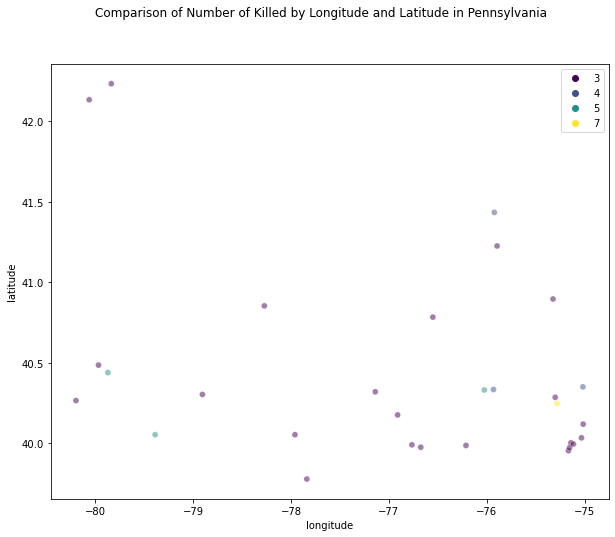

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


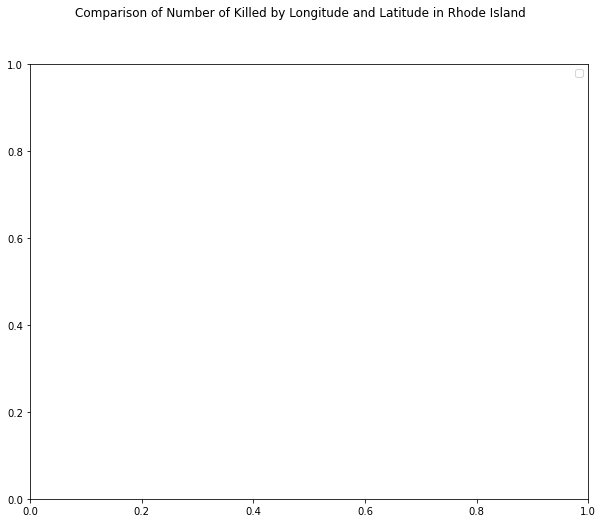

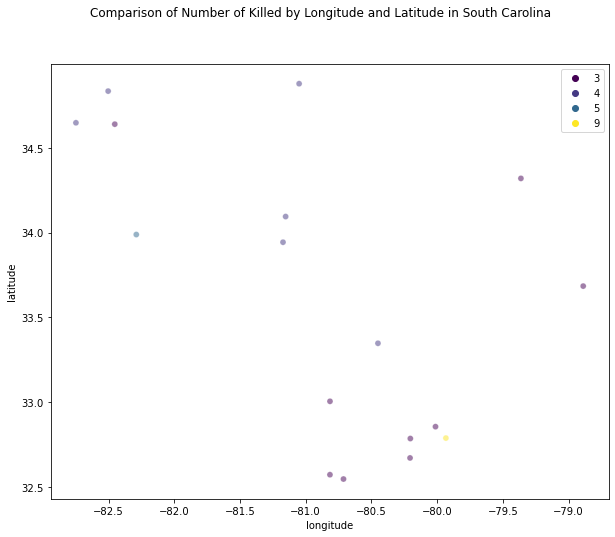

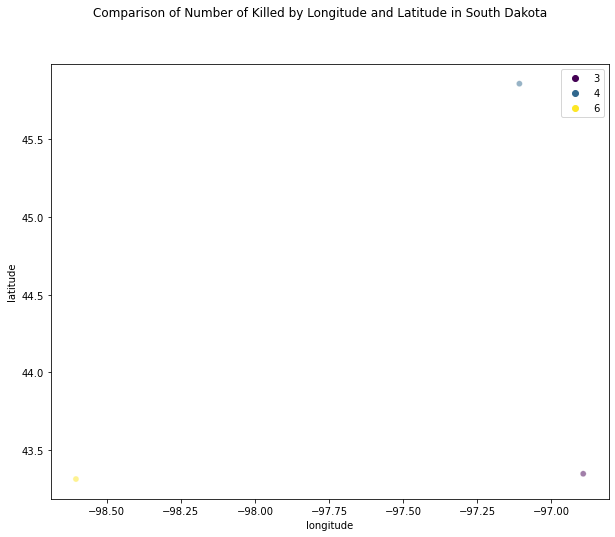

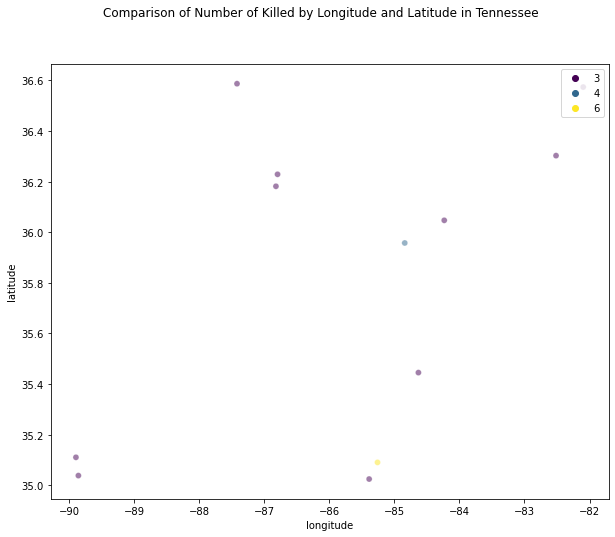

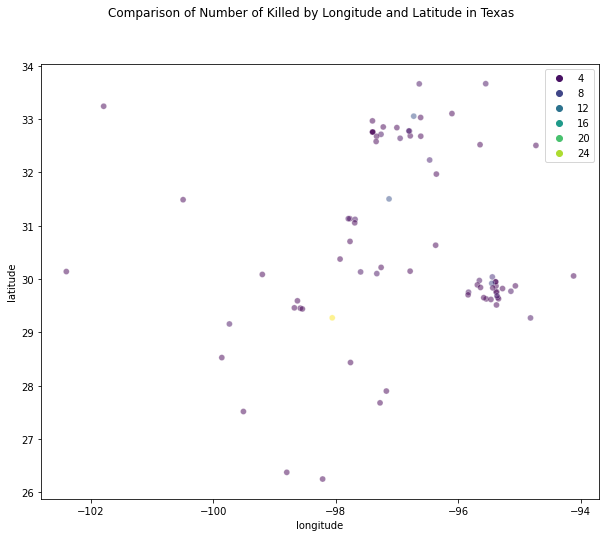

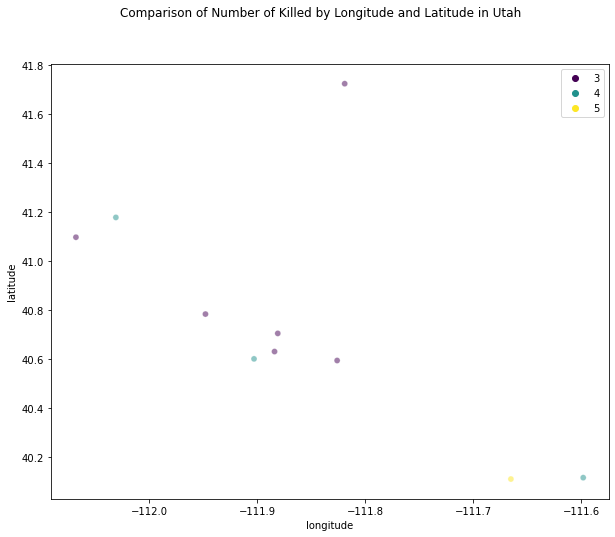

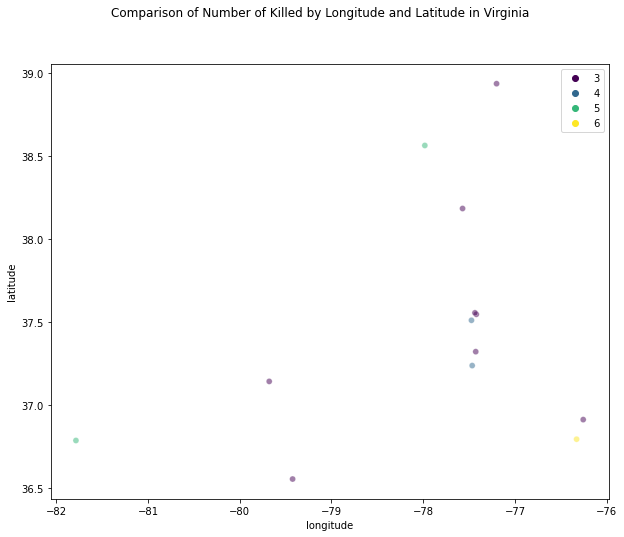

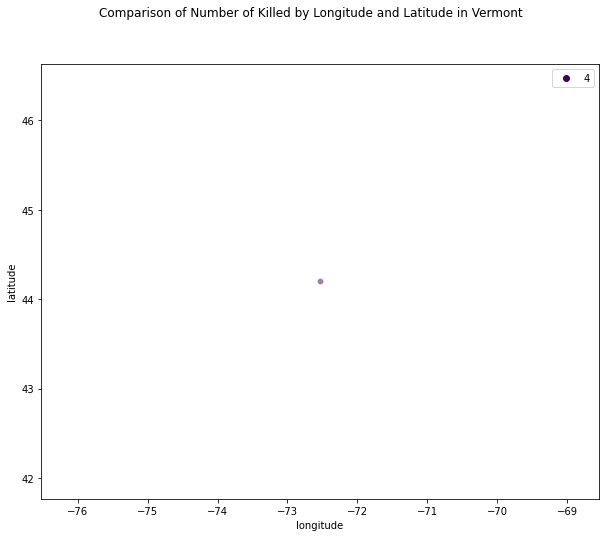

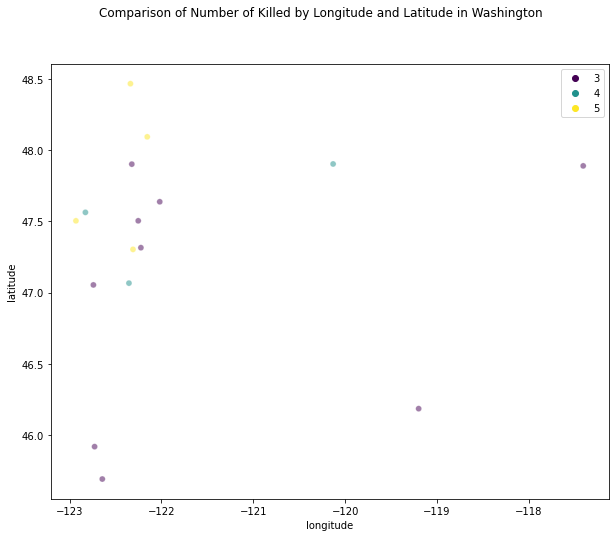

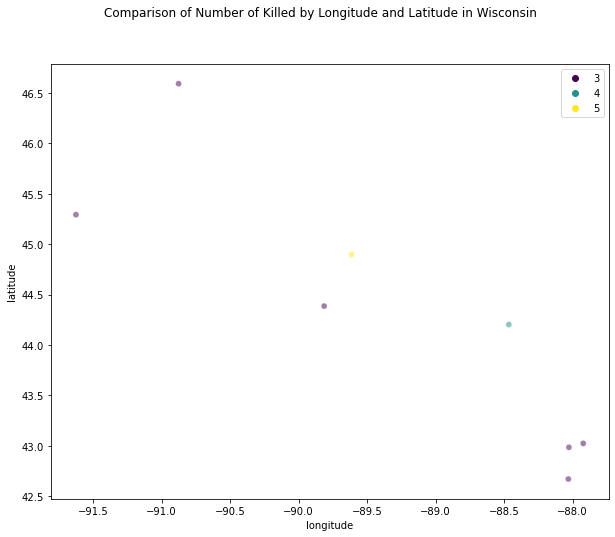

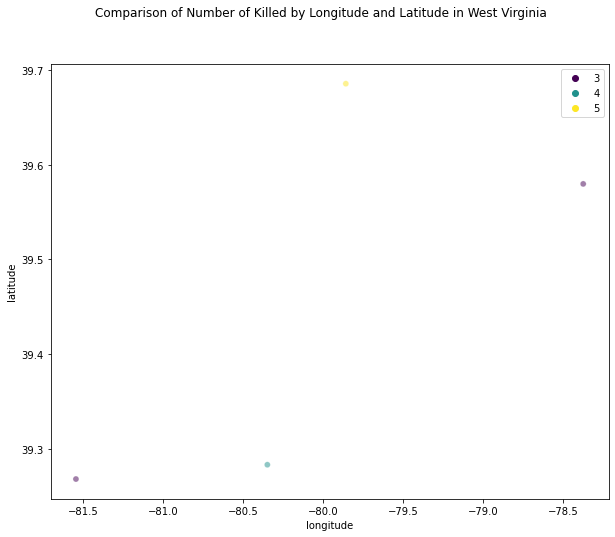

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


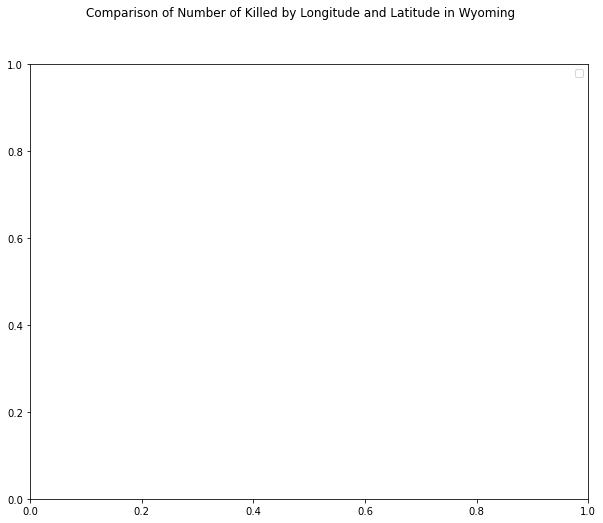

In [43]:
for state in state_names:
    plt.figure(figsize= (10,8))
    sns.scatterplot(data = gun_df[gun_df['state']==state], x="longitude", y="latitude", hue="n_killed",
                    palette="viridis", alpha=0.5)
    plt.suptitle(f"Comparison of Number of Killed by Longitude and Latitude in {state}")
    plt.legend(loc = "upper right")
    plt.show()

## Creating an aggregated state dataframe for mapping purposes

First, we have noticed in the longitude/latitude mapping above that five states didn't have any mass shooting in 2013-2018: Connecticut, Massachusetts, North Dakota, Rhode Island, and Wyoming. We will add five records with null values for these states to gun_df dataframe, and then add state abbreviation column for easier merging with USA geoJSON dataframe down the road. Then we will aggregate data by state and plot them using geopandas.

In [157]:
## Let's create a dataframe of columns that we'll focus on for mapping purpose

gun_map_df = gun_df[['incident_id', 'state', 'n_killed', 'n_injured', 'n_guns_involved', 'Male', 'Female', 'Adult', 'Teen', 'Child', 'Victim', 
'Suspect', 'Unknown_Guns', 'Handgun', 'Shotgun', 'Rifle', 'Other', 'Automatic']]

df2 = pd.DataFrame({'incident_id': [None, None, None, None, None],
'state': ['Connecticut', 'Massachusetts', 'North Dakota', 'Rhode Island', 'Wyoming'], 
'n_killed': [None, None, None, None, None],
'n_injured': [None, None, None, None, None],
'n_guns_involved': [None, None, None, None, None],
'n_incidents': [None, None, None, None, None],
'Male': [None, None, None, None, None],
'Female': [None, None, None, None, None],
'Adult': [None, None, None, None, None],
'Teen': [None, None, None, None, None],
'Child': [None, None, None, None, None],
'Victim': [None, None, None, None, None],
'Suspect': [None, None, None, None, None],
'Unknown_Guns': [None, None, None, None, None],
'Handgun': [None, None, None, None, None],
'Shotgun': [None, None, None, None, None],
'Rifle': [None, None, None, None, None],
'Other': [None, None, None, None, None],
'Automatic': [None, None, None, None, None] })

gun_states = pd.concat([gun_map_df, df2], axis = 0, ignore_index = True)

gun_states



incident_id          state n_killed n_injured n_guns_involved  Male  \
0        496668        Alabama        3         5             NaN   8.0   
1        187367        Alabama        3         0             NaN   2.0   
2        195207        Alabama        3         0             NaN   3.0   
3        261048        Alabama        3         0             NaN   2.0   
4        308861        Alabama        3         1             1.0   3.0   
..          ...            ...      ...       ...             ...   ...   
802        None    Connecticut     None      None            None  None   
803        None  Massachusetts     None      None            None  None   
804        None   North Dakota     None      None            None  None   
805        None   Rhode Island     None      None            None  None   
806        None        Wyoming     None      None            None  None   

    Female Adult  Teen Child Victim Suspect Unknown_Guns Handgun Shotgun  \
0      1.0   9.0   0.0   0.0    8.0     2.0          0.0     0.0     0.0   
1      1.0   2.0   0.0   1.0    2.0     1.0          0.0     0.0     0.0   
2      0.0   3.0   0.0   0.0    2.0     1.0          0.0     0.0     0.0   
3      1.0   3.0   0.0   0.0    2.0     1.0          0.0     0.0     0.0   
4      1.0   4.0   0.0   0.0    3.0     1.0          0.0     0.0     0.0   
..     ...   ...   ...   ...    ...     ...          ...     ...     ...   
802   None  None  None  None   None    None         None    None    None   
803   None  None  None  None   None    None         None    None    None   
804   None  None  None  None   None    None         None    None    None   
805   None  None  None  None   None    None         None    None    None   
806   None  None  None  None   None    None         None    None    None   

    Rifle Other Automatic n_incidents  
0     0.0   0.0       0.0         NaN  
1     0.0   0.0       0.0         NaN  
2     0.0   0.0       0.0         NaN  
3     0.0   0.0       0.0         NaN  
4     1.0   0.0       0.0         NaN  
..    ...   ...       ...         ...  
802  None  None      None        None  
803  None  None      None        None  
804  None  None      None        None  
805  None  None      None        None  
806  None  None      None        None  

[807 rows x 19 columns]

In [158]:
## Now's let's add state abbreviation to the dataframe

gun_states['abbrev'] = None

for i in range(len(gun_states)):
    state = gun_states.loc[i, 'state']
    if state == 'Alabama':
        gun_states.at[i, 'abbrev'] = 'AL'
    elif state == 'Alaska':
        gun_states.at[i, 'abbrev'] = 'AK'
    elif state == 'Arizona':
        gun_states.at[i, 'abbrev'] = 'AZ'
    elif state == 'Arkansas':
        gun_states.at[i, 'abbrev'] = 'AR'
    elif state == 'California':
        gun_states.at[i, 'abbrev'] = 'CA'
    elif state == 'Colorado':
        gun_states.at[i, 'abbrev'] = 'CO'
    elif state == 'Connecticut':
        gun_states.at[i, 'abbrev'] = 'CT'
    elif state == 'Delaware':
        gun_states.at[i, 'abbrev'] = 'DE'
    elif state == 'District of Columbia':
        gun_states.at[i, 'abbrev'] = 'DC'
    elif state == 'Florida':
        gun_states.at[i, 'abbrev'] = 'FL'
    elif state == 'Georgia':
        gun_states.at[i, 'abbrev'] = 'GA'
    elif state == 'Hawaii':
        gun_states.at[i, 'abbrev'] = 'HI'
    elif state == 'Idaho':
        gun_states.at[i, 'abbrev'] = 'ID'
    elif state == 'Illinois':
        gun_states.at[i, 'abbrev'] = 'IL'
    elif state == 'Indiana':
        gun_states.at[i, 'abbrev'] = 'IN'
    elif state == 'Iowa':
        gun_states.at[i, 'abbrev'] = 'IA'
    elif state == 'Kansas':
        gun_states.at[i, 'abbrev'] = 'KS'
    elif state == 'Kentucky':
        gun_states.at[i, 'abbrev'] = 'KY'
    elif state == 'Louisiana':
        gun_states.at[i, 'abbrev'] = 'LA'
    elif state == 'Maine':
        gun_states.at[i, 'abbrev'] = 'ME'
    elif state == 'Maryland':
        gun_states.at[i, 'abbrev'] = 'MD'
    elif state == 'Massachusetts':
        gun_states.at[i, 'abbrev'] = 'MA'
    elif state == 'Michigan':
        gun_states.at[i, 'abbrev'] = 'MI'
    elif state == 'Minnesota':
        gun_states.at[i, 'abbrev'] = 'MN'
    elif state == 'Mississippi':
        gun_states.at[i, 'abbrev'] = 'MS'
    elif state == 'Missouri':
        gun_states.at[i, 'abbrev'] = 'MO'
    elif state == 'Montana':
        gun_states.at[i, 'abbrev'] = 'MT'
    elif state == 'Nebraska':
        gun_states.at[i, 'abbrev'] = 'NE'
    elif state == 'Nevada':
        gun_states.at[i, 'abbrev'] = 'NV'
    elif state == 'New Hampshire':
        gun_states.at[i, 'abbrev'] = 'NH'
    elif state == 'New Jersey':
        gun_states.at[i, 'abbrev'] = 'NJ'
    elif state == 'New Mexico':
        gun_states.at[i, 'abbrev'] = 'NM'
    elif state == 'New York':
        gun_states.at[i, 'abbrev'] = 'NY'
    elif state == 'North Carolina':
        gun_states.at[i, 'abbrev'] = 'NC'
    elif state == 'North Dakota':
        gun_states.at[i, 'abbrev'] = 'ND'
    elif state == 'Ohio':
        gun_states.at[i, 'abbrev'] = 'OH'
    elif state == 'Oklahoma':
        gun_states.at[i, 'abbrev'] = 'OK'
    elif state == 'Oregon':
        gun_states.at[i, 'abbrev'] = 'OR'
    elif state == 'Pennsylvania':
        gun_states.at[i, 'abbrev'] = 'PA'
    elif state == 'Puerto Rico':
        gun_states.at[i, 'abbrev'] = 'PR'
    elif state == 'Rhode Island':
        gun_states.at[i, 'abbrev'] = 'RI'
    elif state == 'South Carolina':
        gun_states.at[i, 'abbrev'] = 'SC'
    elif state == 'South Dakota':
        gun_states.at[i, 'abbrev'] = 'SD'
    elif state == 'Tennessee':
        gun_states.at[i, 'abbrev'] = 'TN'
    elif state == 'Texas':
        gun_states.at[i, 'abbrev'] = 'TX'
    elif state == 'Utah':
        gun_states.at[i, 'abbrev'] = 'UT'
    elif state == 'Vermont':
        gun_states.at[i, 'abbrev'] = 'VT'
    elif state == 'Virginia':
        gun_states.at[i, 'abbrev'] = 'VA'
    elif state == 'Washington':
        gun_states.at[i, 'abbrev'] = 'WA'
    elif state == 'West Virginia':
        gun_states.at[i, 'abbrev'] = 'WV'
    elif state == 'Wisconsin':
        gun_states.at[i, 'abbrev'] = 'WI'
    elif state == 'Wyoming':
        gun_states.at[i, 'abbrev'] = 'WY'

gun_states.sample(n=20)

incident_id           state n_killed n_injured n_guns_involved Male  \
416      262029     Mississippi        3         0             1.0  2.0   
785      661703      Washington        5         0             1.0  2.0   
636      138645  South Carolina        3         1             NaN  4.0   
683      143213           Texas        3         0             1.0  1.0   
746     1022547           Texas        4         0             1.0  3.0   
690      169008           Texas        3         0             NaN  4.0   
444      825022        Missouri        3         0             1.0  3.0   
203     1044234         Florida        3         3             1.0  5.0   
230      579772         Georgia        3         1             2.0  0.0   
79       276459      California        4         0             NaN  4.0   
586      762972        Oklahoma        3         0             1.0  3.0   
779      410852      Washington        4         0             1.0  3.0   
686      150603           Texas        3         0             NaN  5.0   
646      693938  South Carolina        3         0             1.0  2.0   
180      572696         Florida        3         3             1.0  6.0   
519     1024017        New York        3         0             1.0  1.0   
751      158327            Utah        3         0             NaN  2.0   
364      164513           Maine        5         0             NaN  3.0   
491      763628      New Jersey        3         0             1.0  4.0   
575      478948        Oklahoma        4         0             NaN  2.0   

    Female Adult Teen Child Victim Suspect Unknown_Guns Handgun Shotgun Rifle  \
416    1.0   3.0  0.0   0.0    2.0     1.0          1.0     0.0     0.0   0.0   
785    4.0   5.0  1.0   0.0    5.0     1.0          0.0     1.0     0.0   0.0   
636    0.0   4.0  0.0   0.0    4.0     0.0          0.0     0.0     0.0   0.0   
683    3.0   4.0  0.0   0.0    3.0     1.0          1.0     0.0     0.0   0.0   
746    1.0   2.0  0.0   2.0    3.0     1.0          0.0     1.0     0.0   0.0   
690    0.0   1.0  0.0   0.0    3.0     1.0          0.0     0.0     0.0   0.0   
444    0.0   3.0  0.0   0.0    2.0     1.0          1.0     0.0     0.0   0.0   
203    1.0   6.0  0.0   0.0    5.0     1.0          1.0     0.0     0.0   0.0   
230    0.0   0.0  0.0   0.0    2.0     2.0          2.0     0.0     0.0   0.0   
79     0.0   4.0  0.0   0.0    4.0     0.0          0.0     0.0     0.0   0.0   
586    1.0   4.0  0.0   0.0    3.0     1.0          1.0     0.0     0.0   0.0   
779    1.0   4.0  0.0   0.0    3.0     1.0          0.0     0.0     0.0   1.0   
686    0.0   5.0  0.0   0.0    3.0     2.0          0.0     0.0     0.0   0.0   
646    1.0   3.0  0.0   0.0    3.0     0.0          1.0     0.0     0.0   0.0   
180    1.0   6.0  0.0   1.0    6.0     1.0          0.0     0.0     1.0   0.0   
519    2.0   3.0  0.0   0.0    2.0     1.0          1.0     0.0     0.0   0.0   
751    1.0   3.0  0.0   0.0    2.0     1.0          0.0     0.0     0.0   0.0   
364    2.0   2.0  1.0   2.0    5.0     0.0          0.0     0.0     0.0   0.0   
491    1.0   5.0  0.0   0.0    3.0     2.0          1.0     0.0     0.0   0.0   
575    4.0   6.0  0.0   0.0    4.0     2.0          0.0     0.0     0.0   0.0   

    Other Automatic n_incidents abbrev  
416   0.0       0.0         NaN     MS  
785   0.0       0.0         NaN     WA  
636   0.0       0.0         NaN     SC  
683   0.0       0.0         NaN     TX  
746   0.0       0.0         NaN     TX  
690   0.0       0.0         NaN     TX  
444   0.0       0.0         NaN     MO  
203   0.0       0.0         NaN     FL  
230   0.0       0.0         NaN     GA  
79    0.0       0.0         NaN     CA  
586   0.0       0.0         NaN     OK  
779   0.0       0.0         NaN     WA  
686   0.0       0.0         NaN     TX  
646   0.0       0.0         NaN     SC  
180   0.0       0.0         NaN     FL  
519   0.0       0.0         NaN     NY  
751   0.0       0.0         N

In [159]:
gun_state_sum_df = gun_states.groupby('state')[['abbrev']].agg(pd.Series.mode)

gun_state_sum_df['n_killed'] = gun_states.groupby('state')[['n_killed']].sum()

gun_state_sum_df['n_injured'] = gun_states.groupby('state')['n_injured'].sum()

gun_state_sum_df['n_guns_involved'] = gun_states.groupby('state')['n_guns_involved'].sum()

gun_state_sum_df['n_incidents'] = gun_states.groupby('state')['n_killed'].count()

gun_state_sum_df['Male'] = gun_states.groupby('state')['Male'].sum()

gun_state_sum_df['Female'] = gun_states.groupby('state')['Female'].sum()

gun_state_sum_df['Adult'] = gun_states.groupby('state')['Adult'].sum()

gun_state_sum_df['Teen'] = gun_states.groupby('state')['Teen'].sum()

gun_state_sum_df['Child'] = gun_states.groupby('state')['Child'].sum()

gun_state_sum_df['Victim'] = gun_states.groupby('state')['Victim'].sum()

gun_state_sum_df['Suspect'] = gun_states.groupby('state')['Suspect'].sum()

gun_state_sum_df['Unknown_Guns'] = gun_states.groupby('state')['Unknown_Guns'].sum()

gun_state_sum_df['Handgun'] = gun_states.groupby('state')['Handgun'].sum()

gun_state_sum_df['Shotgun'] = gun_states.groupby('state')['Shotgun'].sum()

gun_state_sum_df['Rifle'] = gun_states.groupby('state')['Rifle'].sum()

gun_state_sum_df['Other'] = gun_states.groupby('state')['Other'].sum()

gun_state_sum_df['Automatic'] = gun_states.groupby('state')['Automatic'].sum()

gun_state_sum_df.sample(5) 



abbrev  n_killed n_injured n_guns_involved  n_incidents  \
state                                                                          
Alabama                  AL        55         9             8.0           17   
Alaska                   AK        15         0             3.0            4   
Arizona                  AZ        83         6            19.0           24   
Arkansas                 AR        31         4             9.0           10   
California               CA       252        94            54.0           72   
Colorado                 CO        42        12            12.0           13   
Connecticut              CT         0         0               0            0   
Delaware                 DE         3         2             1.0            1   
District of Columbia     DC        11         3             2.0            1   
Florida                  FL       285        96            44.0           67   
Georgia                  GA       111        18            26.0           33   
Hawaii                   HI         3         0             1.0            1   
Idaho                    ID        16         1             9.0            5   
Illinois                 IL        96        12            21.0           28   
Indiana                  IN        80         7            16.0           25   
Iowa                     IA         9         0             2.0            3   
Kansas                   KS        51        18            14.0           15   
Kentucky                 KY        59         2            14.0           18   
Louisiana                LA        85        25            23.0           27   
Maine                    ME        19         1             3.0            5   
Maryland                 MD        60        15            10.0           20   
Massachusetts            MA         0         0               0            0   
Michigan                 MI        70        16            18.0           21   
Minnesota                MN        18         2             5.0            5   
Mississippi              MS        41         3             9.0           11   
Missouri                 MO       102         6            26.0           31   
Montana                  MT        17         2             5.0            5   
Nebraska                 NE        12         5             2.0            4   
Nevada                   NV        51         0             9.0           15   
New Hampshire            NH         3         0               0            1   
New Jersey               NJ        36         2             6.0           11   
New Mexico               NM        37         3            10.0           10   
New York                 NY        65        11            22.0           19   
North Carolina           NC        93        10            78.0           30   
North Dakota             ND         0         0               0            0   
Ohio                     OH        82         9            19.0           23   
Oklahoma                 OK        55         1             9.0           16   
Oregon                   OR        35        12            11.0            9   
Pennsylvania             PA       103        11            33.0           30   
Rhode Island             RI         0         0               0            0   
South Carolina           SC        78         7            10.0           21   
South Dakota             SD        13         1             4.0            3   
Tennessee                TN        43         7            11.0           13   
Texas                    TX       309        87            61.0           81   
Utah                     UT        35         4             8.0           10   
Vermont                  VT         4         0             1.0            1   
Virginia                 VA        52         3             9.0           14   
Washington               WA        59         6            25.0           16   
West Virginia        

In [160]:
## Let's see how long the dataframe is

len(gun_state_sum_df)

51

## Now let's create geopandas maps!

In [412]:
import geopandas as gpd

# Import the geoJSON file
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/us-states.json"

# Read the file and print it.
geoJSON_df = gpd.read_file(state_geo)
geoJSON_df.sample(5)

id            name                                           geometry
0   AL         Alabama  POLYGON ((-87.35930 35.00118, -85.60667 34.984...
1   AK          Alaska  MULTIPOLYGON (((-131.60202 55.11798, -131.5691...
2   AZ         Arizona  POLYGON ((-109.04250 37.00026, -109.04798 31.3...
3   AR        Arkansas  POLYGON ((-94.47384 36.50186, -90.15254 36.496...
4   CA      California  POLYGON ((-123.23326 42.00619, -122.37885 42.0...
5   CO        Colorado  POLYGON ((-107.91973 41.00391, -105.72895 40.9...
6   CT     Connecticut  POLYGON ((-73.05353 42.03905, -71.79931 42.022...
7   DE        Delaware  POLYGON ((-75.41409 39.80446, -75.50720 39.683...
8   FL         Florida  POLYGON ((-85.49714 30.99754, -85.00421 31.003...
9   GA         Georgia  POLYGON ((-83.10919 35.00118, -83.32279 34.787...
10  HI          Hawaii  MULTIPOLYGON (((-155.63484 18.94827, -155.8813...
11  ID           Idaho  POLYGON ((-116.04751 49.00024, -116.04751 47.9...
12  IL        Illinois  POLYGON ((-90.63998 42.51006, -88.78878 42.493...
13  IN         Indiana  POLYGON ((-85.99006 41.75972, -84.80704 41.759...
14  IA            Iowa  POLYGON ((-91.36842 43.50139, -91.21506 43.501...
15  KS          Kansas  POLYGON ((-101.90605 40.00163, -95.30634 40.00...
16  KY        Kentucky  POLYGON ((-83.90335 38.76931, -83.67879 38.632...
17  LA       Louisiana  POLYGON ((-93.60849 33.01853, -91.16577 33.002...
18  ME           Maine  POLYGON ((-70.70392 43.05776, -70.82441 43.128...
19  MD        Maryland  MULTIPOLYGON (((-75.99465 37.95325, -76.01655 ...
20  MA   Massachusetts  POLYGON ((-70.91752 42.88797, -70.81894 42.871...
21  MI        Michigan  MULTIPOLYGON (((-83.45424 41.73234, -84.80704 ...
22  MN       Minnesota  POLYGON ((-92.01470 46.70540, -92.09137 46.749...
23  MS     Mississippi  POLYGON ((-88.47111 34.99570, -88.20274 34.995...
24  MO        Missouri  POLYGON ((-91.83396 40.60957, -91.72989 40.615...
25  MT         Montana  POLYGON ((-104.04753 49.00024, -104.04206 47.8...
26  NE        Nebraska  POLYGON ((-103.32458 43.00299, -101.62673 42.9...
27  NV          Nevada  POLYGON ((-117.02788 42.00071, -114.04295 41.9...
28  NH   New Hampshire  POLYGON ((-71.08183 45.30330, -71.03254 44.657...
29  NJ      New Jersey  POLYGON ((-74.23655 41.14083, -73.90245 40.998...
30  NM      New Mexico  POLYGON ((-107.42133 37.00026, -106.86816 36.9...
31  NY        New York  POLYGON ((-73.34381 45.01303, -73.33285 44.804...
32  NC  North Carolina  POLYGON ((-80.97866 36.56211, -80.29404 36.545...
33  ND    North Dakota  POLYGON ((-97.22874 49.00024, -97.09730 48.682...
34  OH            Ohio  POLYGON ((-80.51860 41.97880, -80.51860 40.636...
35  OK        Oklahoma  POLYGON ((-100.08771 37.00026, -94.61624 37.00...
36  OR          Oregon  POLYGON ((-123.21135 46.17414, -123.11824 46.1...
37  PA    Pennsylvania  POLYGON ((-79.76278 42.25265, -79.76278 42.000...
38  RI    Rhode Island  MULTIPOLYGON (((-71.19684 41.67757, -71.12017 ...
39  SC  South Carolina  POLYGON ((-82.76414 35.06690, -82.55054 35.160...
40  SD    South Dakota  POLYGON ((-104.04753 45.94411, -96.56056 45.93...
41  TN       Tennessee  POLYGON ((-88.05487 36.49638, -88.07130 36.677...
42  TX           Texas  POLYGON ((-101.81294 36.50186, -100.00007 36.5...
43  UT            Utah  POLYGON ((-112.16436 41.99523, -111.04706 42.0...
44  VT         Vermont  POLYGON ((-71.50355 45.01303, -71.49260 44.914...
45  VA        Virginia  MULTIPOLYGON (((-75.39766 38.01350, -75.24430 ...
46  WA      Washington  MULTIPOLYGON (((-117.03336 49.00024, -117.0443...
47  WV   West Virginia  POLYGON ((-80.51860 40.63695, -80.51860 39.722...
48  WI       Wisconsin  POLYGON ((-90.41543 46.56848, -90.22921 46.508...
49  WY         Wyoming  POLYGON ((-109.08084 45.00207, -105.91517 45.0...

In [419]:

## Since the geoJSON_states do not have District of Columbia, we will remove DC from our gun_state_sum_df

gun_state_noDC_df = gun_state_sum_df.drop(index='District of Columbia')

gun_state_noDC_df.sample(5)


abbrev  n_killed n_injured  n_guns_involved  n_incidents  \
state                                                                     
Alabama            AL        55         9              8.0           17   
Alaska             AK        15         0              3.0            4   
Arizona            AZ        83         6             19.0           24   
Arkansas           AR        31         4              9.0           10   
California         CA       252        94             54.0           72   
Colorado           CO        42        12             12.0           13   
Connecticut        CT         0         0              0.0            0   
Delaware           DE         3         2              1.0            1   
Florida            FL       285        96             44.0           67   
Georgia            GA       111        18             26.0           33   
Hawaii             HI         3         0              1.0            1   
Idaho              ID        16         1              9.0            5   
Illinois           IL        96        12             21.0           28   
Indiana            IN        80         7             16.0           25   
Iowa               IA         9         0              2.0            3   
Kansas             KS        51        18             14.0           15   
Kentucky           KY        59         2             14.0           18   
Louisiana          LA        85        25             23.0           27   
Maine              ME        19         1              3.0            5   
Maryland           MD        60        15             10.0           20   
Massachusetts      MA         0         0              0.0            0   
Michigan           MI        70        16             18.0           21   
Minnesota          MN        18         2              5.0            5   
Mississippi        MS        41         3              9.0           11   
Missouri           MO       102         6             26.0           31   
Montana            MT        17         2              5.0            5   
Nebraska           NE        12         5              2.0            4   
Nevada             NV        51         0              9.0           15   
New Hampshire      NH         3         0              0.0            1   
New Jersey         NJ        36         2              6.0           11   
New Mexico         NM        37         3             10.0           10   
New York           NY        65        11             22.0           19   
North Carolina     NC        93        10             78.0           30   
North Dakota       ND         0         0              0.0            0   
Ohio               OH        82         9             19.0           23   
Oklahoma           OK        55         1              9.0           16   
Oregon             OR        35        12             11.0            9   
Pennsylvania       PA       103        11             33.0           30   
Rhode Island       RI         0         0              0.0            0   
South Carolina     SC        78         7             10.0           21   
South Dakota       SD        13         1              4.0            3   
Tennessee          TN        43         7             11.0           13   
Texas              TX       309        87             61.0           81   
Utah               UT        35         4              8.0           10   
Vermont            VT         4         0              1.0            1   
Virginia           VA        52         3              9.0           14   
Washington         WA        59         6             25.0           16   
West Virginia      WV        15         0              3.0            4   
Wisconsin          WI        30         1             10.0            9   
Wyoming            WY         0         0              0.0            0   

                 Male  Female  Adult  Teen  Child  Victim  Suspect  \
state                                       

In [427]:
# we rename the column from id to state in the geoJSON_df so we can merge the two data frames.
geoJSON_df = geoJSON_df.rename(columns = {"id":"abbrev"})

# Next we merge the gun_state_noDC_df dataframe and the geoJSON data frame on the key id.
state_df = geoJSON_df.merge(gun_state_noDC_df, on = "abbrev")

state_df = state_df.rename(columns = {"abbrev":"state"})
state_df['n_killed'] = state_df['n_killed'].replace(0, np.nan)
state_df['n_injured'] = state_df['n_injured'].replace(0, np.nan)
state_df['n_guns_involved'] = state_df['n_guns_involved'].replace(0, np.nan)
state_df['n_incidents'] = state_df['n_incidents'].replace(0, np.nan)
# state_df['Male'] = state_df['Male'].replace(0, np.nan)
# state_df['Female'] = state_df['Female'].replace(0, np.nan)
# state_df['Adult'] = state_df['Adult'].replace(0, np.nan)
# state_df['Teen'] = state_df['Teen'].replace(0, np.nan)
# state_df['Child'] = state_df['Child'].replace(0, np.nan)
# state_df['Victim'] = state_df['n_killed'].replace(0, np.nan)


state_df.sample(5)

state            name                                           geometry  \
0     AL         Alabama  POLYGON ((-87.35930 35.00118, -85.60667 34.984...   
1     AK          Alaska  MULTIPOLYGON (((-131.60202 55.11798, -131.5691...   
2     AZ         Arizona  POLYGON ((-109.04250 37.00026, -109.04798 31.3...   
3     AR        Arkansas  POLYGON ((-94.47384 36.50186, -90.15254 36.496...   
4     CA      California  POLYGON ((-123.23326 42.00619, -122.37885 42.0...   
5     CO        Colorado  POLYGON ((-107.91973 41.00391, -105.72895 40.9...   
6     CT     Connecticut  POLYGON ((-73.05353 42.03905, -71.79931 42.022...   
7     DE        Delaware  POLYGON ((-75.41409 39.80446, -75.50720 39.683...   
8     FL         Florida  POLYGON ((-85.49714 30.99754, -85.00421 31.003...   
9     GA         Georgia  POLYGON ((-83.10919 35.00118, -83.32279 34.787...   
10    HI          Hawaii  MULTIPOLYGON (((-155.63484 18.94827, -155.8813...   
11    ID           Idaho  POLYGON ((-116.04751 49.00024, -116.04751 47.9...   
12    IL        Illinois  POLYGON ((-90.63998 42.51006, -88.78878 42.493...   
13    IN         Indiana  POLYGON ((-85.99006 41.75972, -84.80704 41.759...   
14    IA            Iowa  POLYGON ((-91.36842 43.50139, -91.21506 43.501...   
15    KS          Kansas  POLYGON ((-101.90605 40.00163, -95.30634 40.00...   
16    KY        Kentucky  POLYGON ((-83.90335 38.76931, -83.67879 38.632...   
17    LA       Louisiana  POLYGON ((-93.60849 33.01853, -91.16577 33.002...   
18    ME           Maine  POLYGON ((-70.70392 43.05776, -70.82441 43.128...   
19    MD        Maryland  MULTIPOLYGON (((-75.99465 37.95325, -76.01655 ...   
20    MA   Massachusetts  POLYGON ((-70.91752 42.88797, -70.81894 42.871...   
21    MI        Michigan  MULTIPOLYGON (((-83.45424 41.73234, -84.80704 ...   
22    MN       Minnesota  POLYGON ((-92.01470 46.70540, -92.09137 46.749...   
23    MS     Mississippi  POLYGON ((-88.47111 34.99570, -88.20274 34.995...   
24    MO        Missouri  POLYGON ((-91.83396 40.60957, -91.72989 40.615...   
25    MT         Montana  POLYGON ((-104.04753 49.00024, -104.04206 47.8...   
26    NE        Nebraska  POLYGON ((-103.32458 43.00299, -101.62673 42.9...   
27    NV          Nevada  POLYGON ((-117.02788 42.00071, -114.04295 41.9...   
28    NH   New Hampshire  POLYGON ((-71.08183 45.30330, -71.03254 44.657...   
29    NJ      New Jersey  POLYGON ((-74.23655 41.14083, -73.90245 40.998...   
30    NM      New Mexico  POLYGON ((-107.42133 37.00026, -106.86816 36.9...   
31    NY        New York  POLYGON ((-73.34381 45.01303, -73.33285 44.804...   
32    NC  North Carolina  POLYGON ((-80.97866 36.56211, -80.29404 36.545...   
33    ND    North Dakota  POLYGON ((-97.22874 49.00024, -97.09730 48.682...   
34    OH            Ohio  POLYGON ((-80.51860 41.97880, -80.51860 40.636...   
35    OK        Oklahoma  POLYGON ((-100.08771 37.00026, -94.61624 37.00...   
36    OR          Oregon  POLYGON ((-123.21135 46.17414, -123.11824 46.1...   
37    PA    Pennsylvania  POLYGON ((-79.76278 42.25265, -79.76278 42.000...   
38    RI    Rhode Island  MULTIPOLYGON (((-71.19684 41.67757, -71.12017 ...   
39    SC  South Carolina  POLYGON ((-82.76414 35.06690, -82.55054 35.160...   
40    SD    South Dakota  POLYGON ((-104.04753 45.94411, -96.56056 45.93...   
41    TN       Tennessee  POLYGON ((-88.05487 36.49638, -88.07130 36.677...   
42    TX           Texas  POLYGON ((-101.81294 36.50186, -100.00007 36.5...   
43    UT            Utah  POLYGON ((-112.16436 41.99523, -111.04706 42.0...   
44    VT         Vermont  POLYGON ((-71.50355 45.01303, -71.49260 44.914...   
45    VA        Virginia  MULTIPOLYGON (((-75.39766 38.01350, -75.24430 ...   
46    WA      Washington  MULTIPOLYGON (((-117.03336 49.00024, -117.0443...   
47    WV   West Virginia  POLYGON ((-80.51860 40.63695, -80.51860 39.722...   
48    WI       Wisconsin  POLYGON ((-90.41543 46.56848, -90.22921 46.508...   
49    WY         Wyoming  POLYGON ((-109.08084 45.002

In [428]:
## Set up Choropleth map for Number of People Killed

killed_map = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
geo_data=state_df,
data=state_df,
columns=['state',"n_killed"],
key_on="feature.properties.state",
fill_color='YlGnBu',
fill_opacity=1,
line_opacity=0.2,
legend_name="n_killed",
smooth_factor=0,
Highlight= True,
line_color = "#0000",
name = "Number of people killed",
show=True,
overlay=True,
nan_fill_color = "White"
).add_to(killed_map)

## Adding a hover functionality
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = state_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['state','n_killed'],
        aliases=['state','n_killed'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
killed_map.add_child(NIL)
killed_map.keep_in_front(NIL)

## Add cross-hatching (crossing lines) to display the Null values.
nans = state_df[state_df["n_killed"].isnull()]['state'].values
gdf_nans = state_df[state_df['state'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(killed_map)
folium.features.GeoJson(name="States with no Mass Shootings",data=gdf_nans, style_function=lambda x :{'fillPattern': sp},show=True).add_to(killed_map)

## Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(killed_map)

## Add a title to the map
title_html = ''' 
    <h align="center" style="font-size:18px"><b>People Killed in Mass Shootings in 2013-2018</b></h3>
'''

killed_map.get_root().html.add_child(folium.Element(title_html))

killed_map

['CT' 'MA' 'ND' 'RI' 'WY']
   state           name                                           geometry  \
6     CT    Connecticut  POLYGON ((-73.05353 42.03905, -71.79931 42.022...   
20    MA  Massachusetts  POLYGON ((-70.91752 42.88797, -70.81894 42.871...   
33    ND   North Dakota  POLYGON ((-97.22874 49.00024, -97.09730 48.682...   
38    RI   Rhode Island  MULTIPOLYGON (((-71.19684 41.67757, -71.12017 ...   
49    WY        Wyoming  POLYGON ((-109.08084 45.00207, -105.91517 45.0...   

    n_killed  n_injured  n_guns_involved  n_incidents  Male  Female  Adult  \
6        NaN        NaN              NaN          NaN   0.0     0.0    0.0   
20       NaN        NaN              NaN          NaN   0.0     0.0    0.0   
33       NaN        NaN              NaN          NaN   0.0     0.0    0.0   
38       NaN        NaN              NaN          NaN   0.0     0.0    0.0   
49       NaN        NaN              NaN          NaN   0.0     0.0    0.0   

    Teen  Child  Victim  Suspect  U

In [429]:
## Set up Choropleth map for Number of People Injured

injured_map = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
geo_data=state_df,
data=state_df,
columns=['state',"n_injured"],
key_on="feature.properties.state",
fill_color='PuRd',
fill_opacity=1,
line_opacity=0.2,
legend_name="n_injured",
smooth_factor=0,
Highlight= True,
line_color = "#0000",
name = "Number of people injured",
show=True,
overlay=True,
nan_fill_color = "White"
).add_to(injured_map)

## Adding a hover functionality
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = state_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['state','n_injured'],
        aliases=['state','n_injured'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
injured_map.add_child(NIL)
injured_map.keep_in_front(NIL)

## Add cross-hatching (crossing lines) to display the Null values.
nans = state_df[state_df["n_injured"].isnull()]['state'].values
gdf_nans = state_df[state_df['state'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(injured_map)
folium.features.GeoJson(name="States with no Injuries",data=gdf_nans, style_function=lambda x :{'fillPattern': sp},show=True).add_to(injured_map)

## Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(injured_map)

## Add a title to the map
title_html = ''' 
    <h align="center" style="font-size:18px"><b>People Injured in Mass Shootings in 2013-2018</b></h3>
'''

injured_map.get_root().html.add_child(folium.Element(title_html))

injured_map

In [432]:
## Set up Choropleth map for Number of Guns Involved

guns_map = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
geo_data=state_df,
data=state_df,
columns=['state',"n_guns_involved"],
key_on="feature.properties.state",
fill_color='BuPu',
fill_opacity=1,
line_opacity=0.2,
legend_name="n_guns",
smooth_factor=0,
Highlight= True,
line_color = "#0000",
name = "Number of guns involved",
show=True,
overlay=True,
nan_fill_color = "White"
).add_to(guns_map)

## Adding a hover functionality
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = state_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['state','n_guns_involved'],
        aliases=['state','n_guns_involved'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
guns_map.add_child(NIL)
guns_map.keep_in_front(NIL)

## Add cross-hatching (crossing lines) to display the Null values.
nans = state_df[state_df["n_guns_involved"].isnull()]['state'].values
gdf_nans = state_df[state_df['state'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(guns_map)
folium.features.GeoJson(name="States with No Guns Involved",data=gdf_nans, style_function=lambda x :{'fillPattern': sp},show=True).add_to(guns_map)

## Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(guns_map)

## Add a title to the map
title_html = ''' 
    <h align="center" style="font-size:18px"><b>Number of Guns used in Mass Shootings in 2013-2018</b></h3>
'''

guns_map.get_root().html.add_child(folium.Element(title_html))

guns_map

In [434]:
## Set up Choropleth map for Number of Mass Shootings

shootings_map = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
geo_data=state_df,
data=state_df,
columns=['state',"n_incidents"],
key_on="feature.properties.state",
fill_color='YlOrRd',
fill_opacity=1,
line_opacity=0.2,
legend_name="n_incidents",
smooth_factor=0,
Highlight= True,
line_color = "#0000",
name = "Number of Mass Shootings",
show=True,
overlay=True,
nan_fill_color = "White"
).add_to(shootings_map)

## Adding a hover functionality
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = state_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['state','n_incidents'],
        aliases=['state','n_incidents'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
shootings_map.add_child(NIL)
shootings_map.keep_in_front(NIL)

## Add cross-hatching (crossing lines) to display the Null values.
nans = state_df[state_df["n_incidents"].isnull()]['state'].values
gdf_nans = state_df[state_df['state'].isin(nans)]
sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(shootings_map)
folium.features.GeoJson(name="States with no Mass Shootings",data=gdf_nans, style_function=lambda x :{'fillPattern': sp},show=True).add_to(shootings_map)

## Add a layer controller. 
folium.LayerControl(collapsed=False).add_to(shootings_map)

## Add a title to the map
title_html = ''' 
    <h align="center" style="font-size:18px"><b>Mass Shootings in 2013-2018</b></h3>
'''

shootings_map.get_root().html.add_child(folium.Element(title_html))

shootings_map

## Barplots and Pie Graphs


#### Number of incidents for each state

/Users/teresavail/.pyenv/versions/3.10.5/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 [Text(0, 0, 'Alabama'),
  Text(1, 0, 'Alaska'),
  Text(2, 0, 'Arizona'),
  Text(3, 0, 'Arkansas'),
  Text(4, 0, 'California'),
  Text(5, 0, 'Colorado'),
  Text(6, 0, 'Delaware'),
  Text(7, 0, 'District of Columbia'),
  Text(8, 0, 'Florida'),
  Text(9, 0, 'Georgia'),
  Text(10, 0, 'Hawaii'),
  Text(11, 0, 'Idaho'),
  Text(12, 0, 'Illinois'),
  Text(13, 0, 'Indiana'),
  Text(14, 0, 'Iowa'),
  Text(15, 0, 'Kansas'),
  Text(16, 0, 'Kentucky'),
  Text(17, 0, 'Louisiana'),
  Text(18, 0, 'Maine'),
  Text(19, 0, 'Maryland'),
  Text(20, 0, 'Michigan'),
  Text(21, 0, 'Minnesota'),
  Text(22, 0, 'Mississippi'),
  Text(23, 0, 'Missouri'),
  Text(24, 0, 'Montana'),
  Text(25, 0, 'Nebraska'),
  Text(26, 0, 'Nevada'),
  Text(27, 0, 'New Hampshire'),
  Text(28, 0, 'New Jersey'),
  Text(29, 0, '

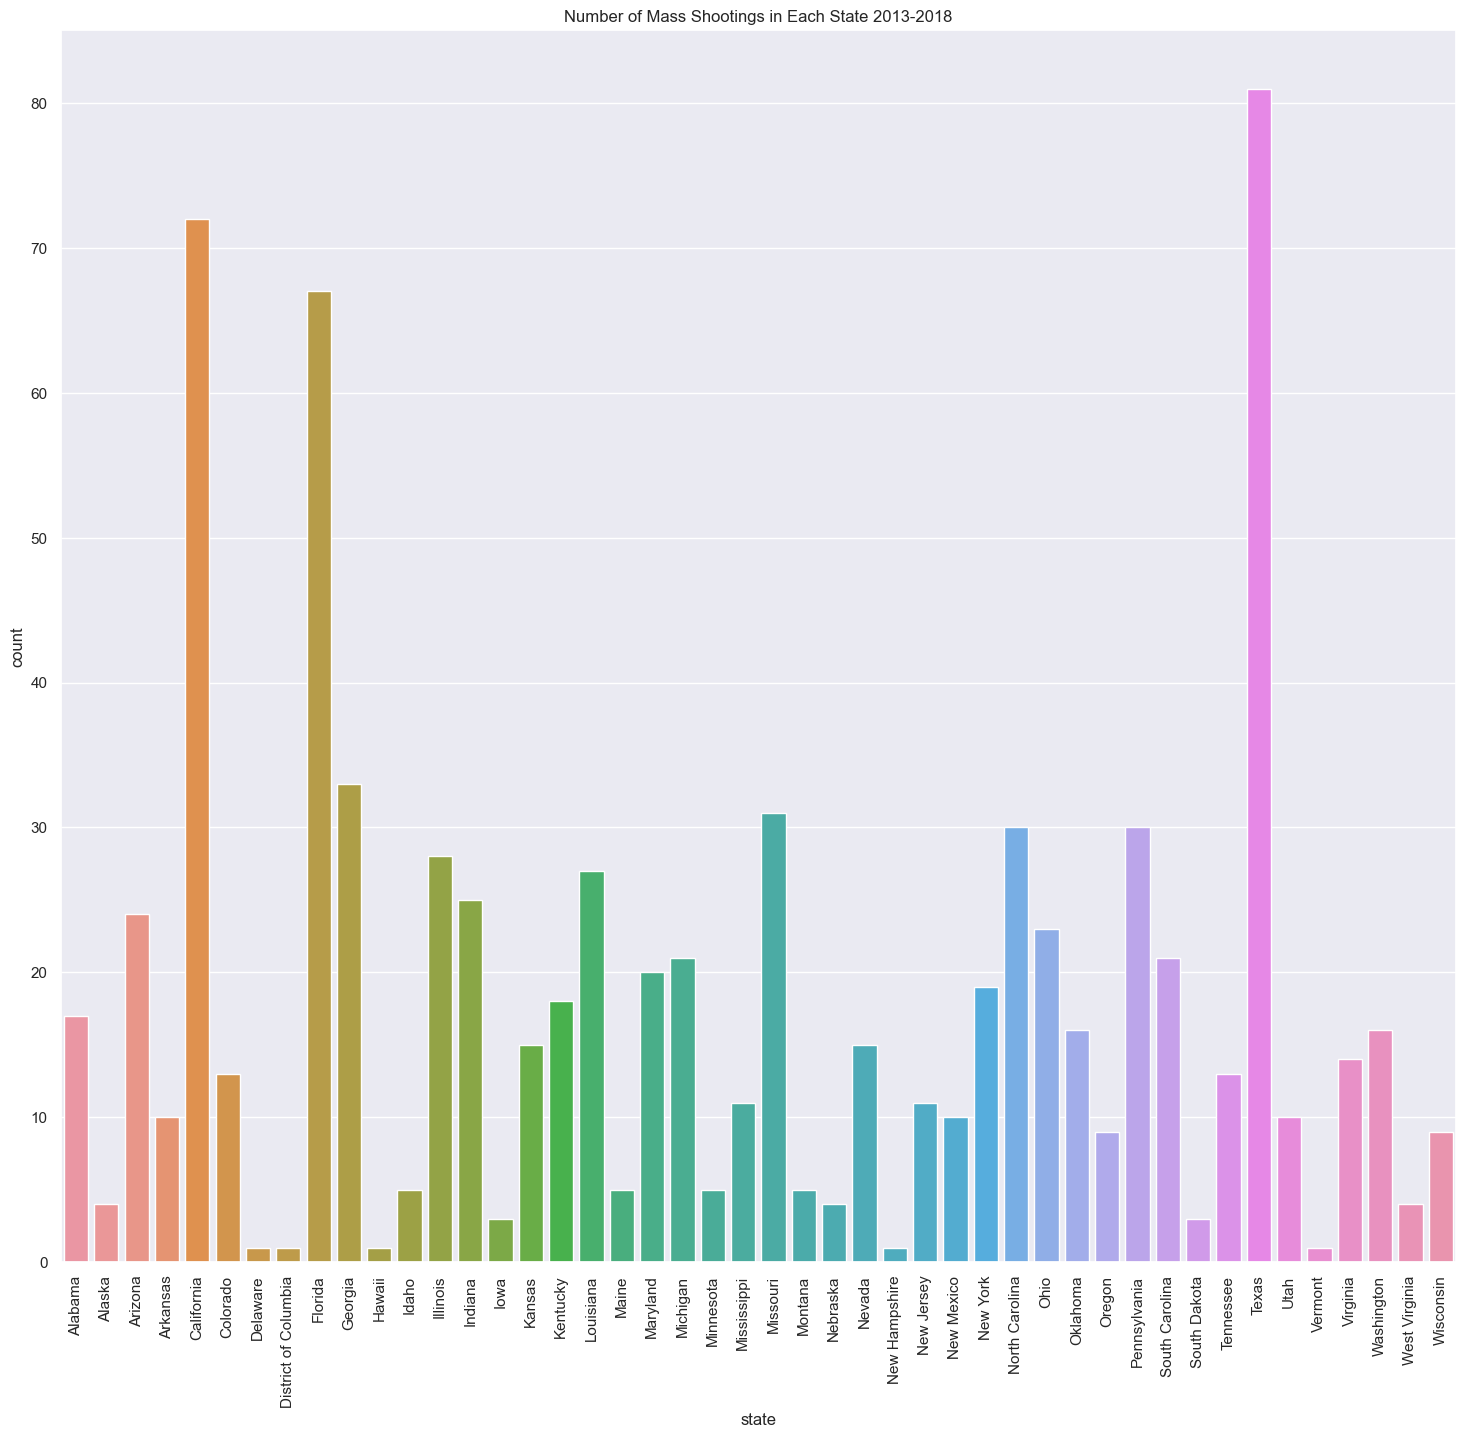

In [310]:
sns.set(rc={'figure.figsize': (18, 16)})
sns.countplot(gun_df.state).set(title='Number of Mass Shootings in Each State 2013-2018')
plt.xticks(rotation =90)

#### Number of people killed for each state

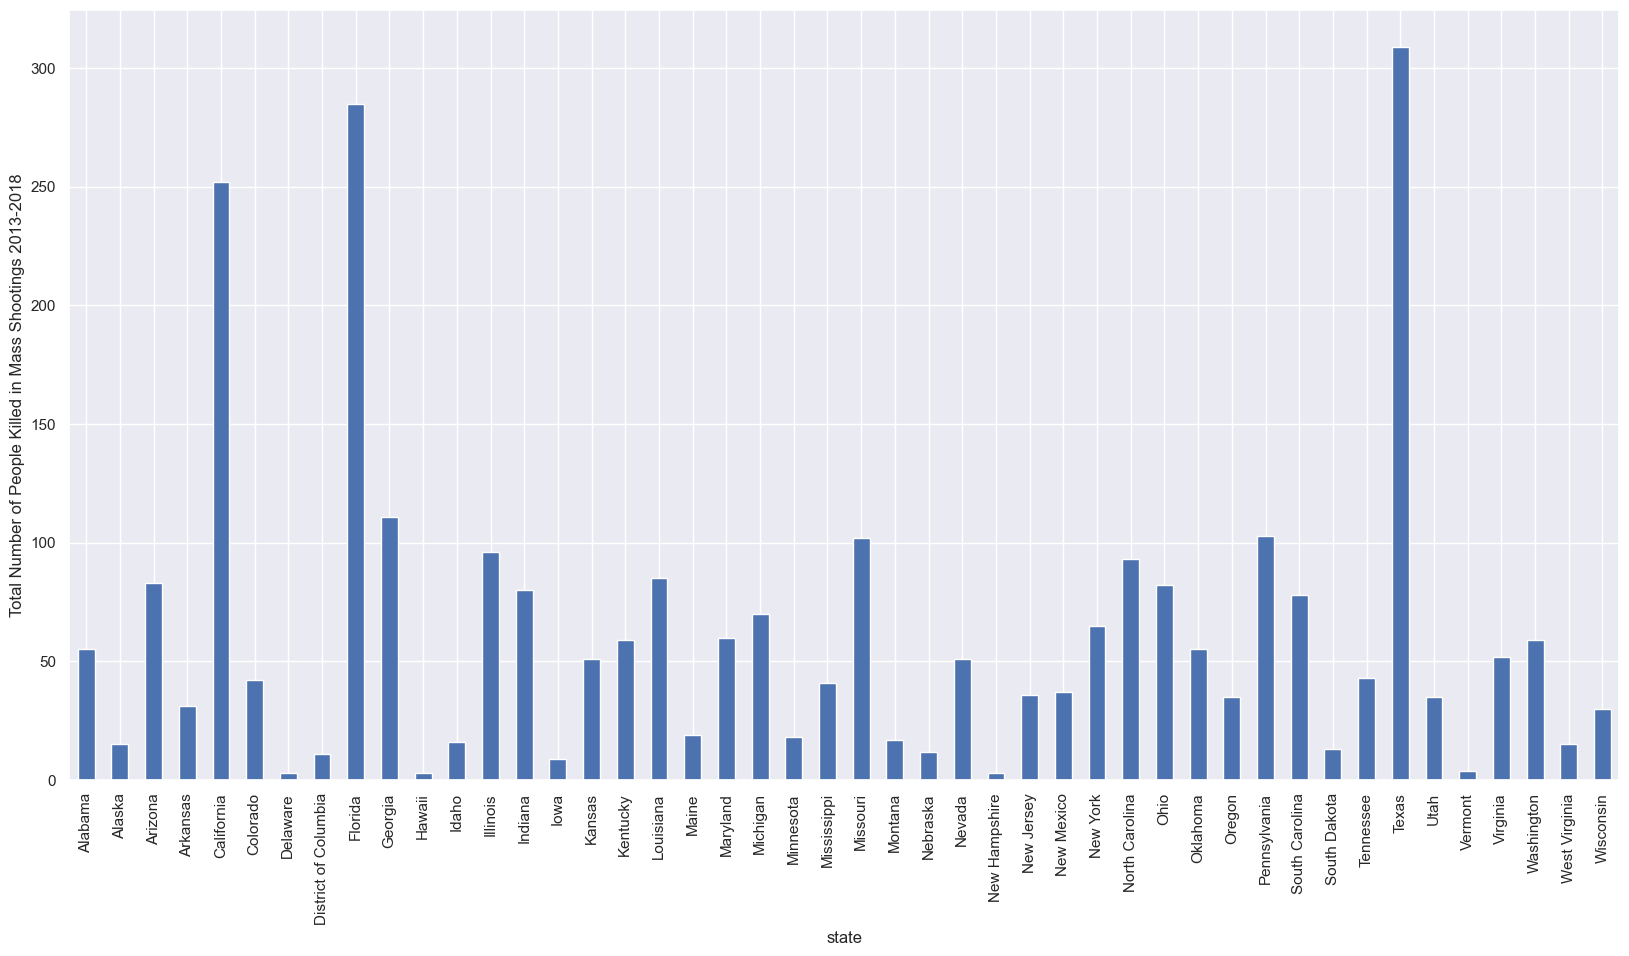

In [392]:
killed_df = gun_df.groupby('state')['n_killed'].sum()

ax = killed_df.plot.bar(figsize=(20,10), ylabel = "Total Number of People Killed in Mass Shootings 2013-2018")
plt.show()

#### Average number of people killed per incident for each state

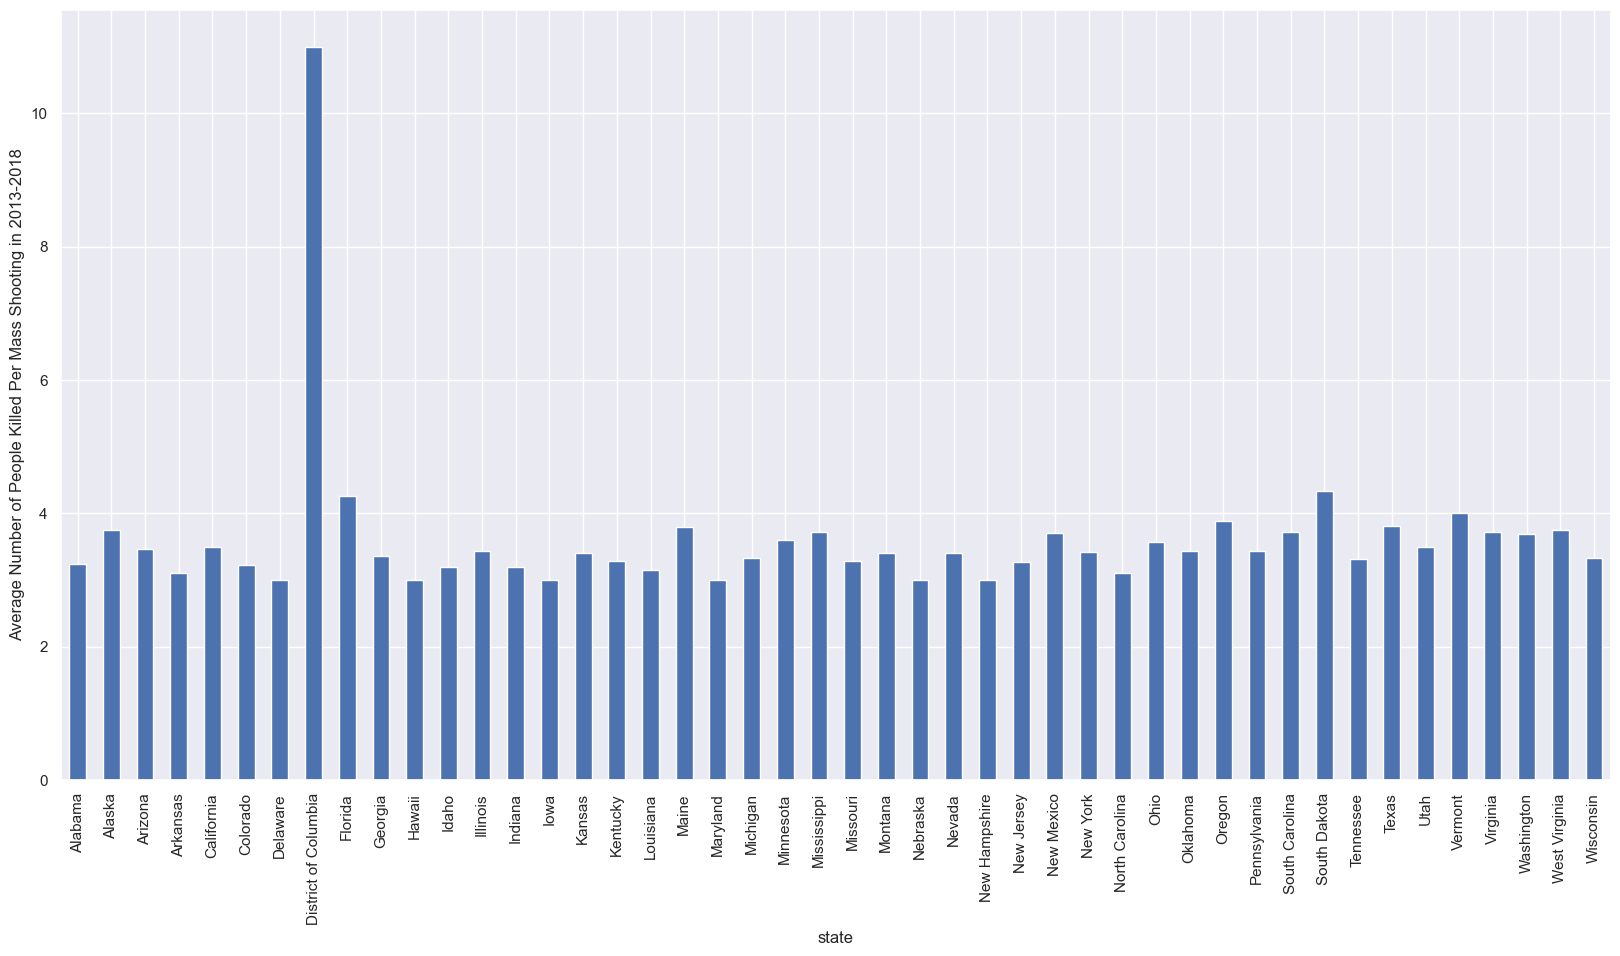

In [311]:
killed_avg_df = gun_df.groupby('state')['n_killed'].mean()

ax = killed_avg_df.plot.bar(figsize=(20,10), ylabel = "Average Number of People Killed Per Mass Shooting in 2013-2018")
plt.show()

#### Number of people injured for each state

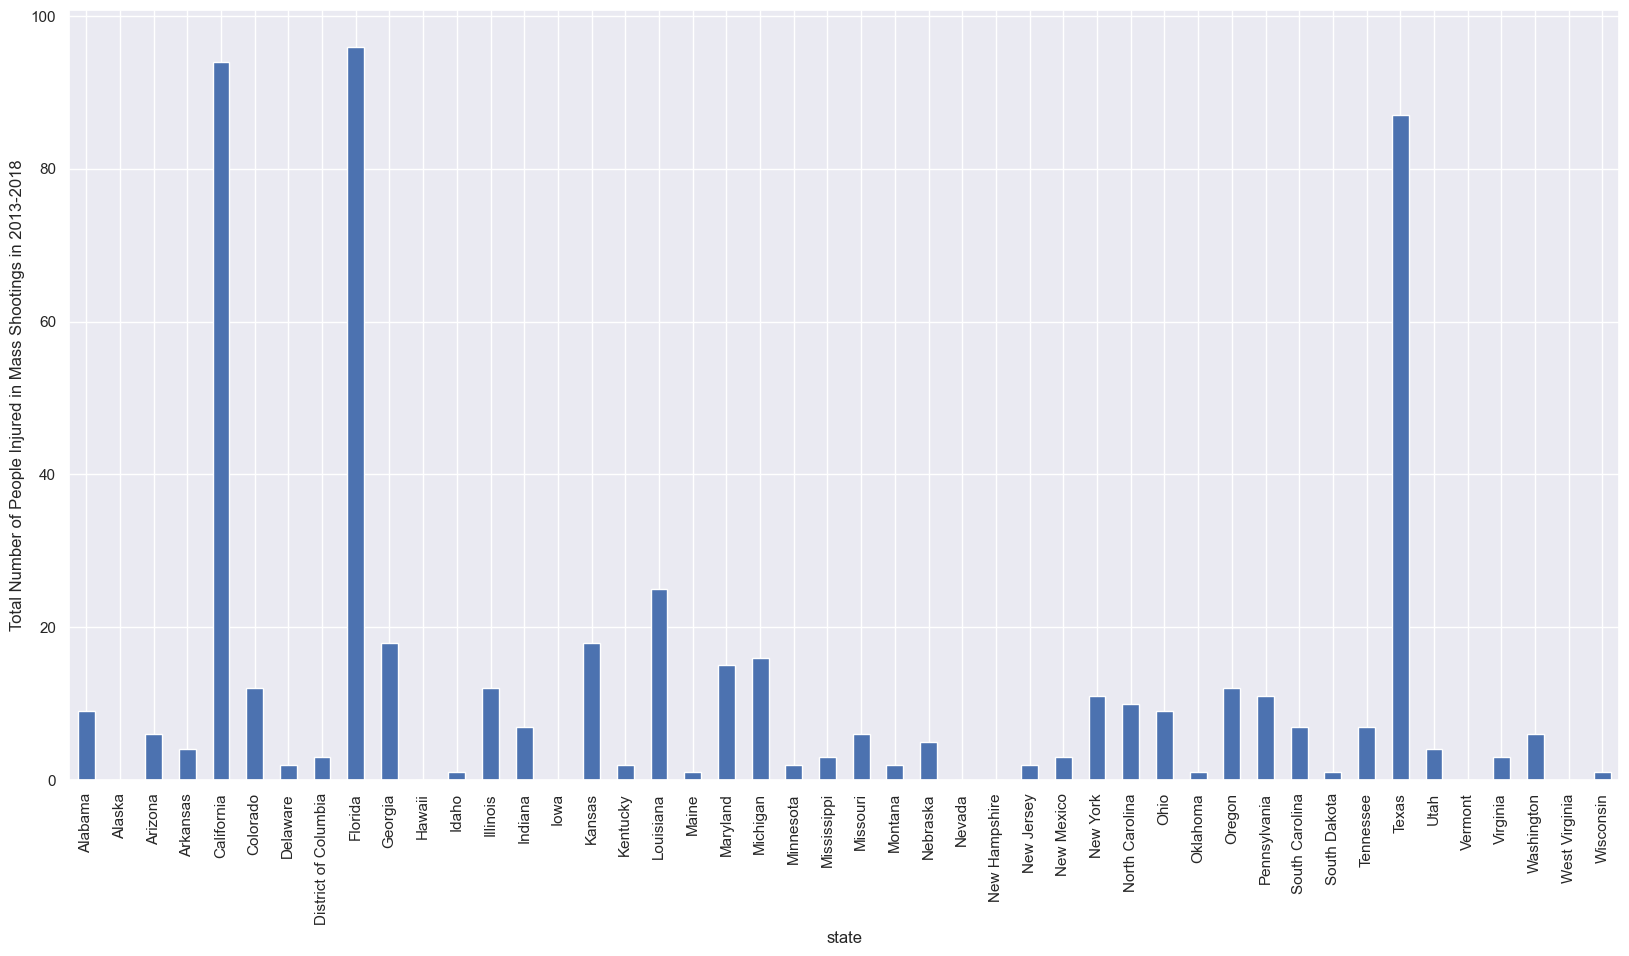

In [312]:
injured_df = gun_df.groupby('state')['n_injured'].sum()

ax = injured_df.plot.bar(figsize=(20,10), ylabel = "Total Number of People Injured in Mass Shootings in 2013-2018")
plt.show()

#### Average number of people injured per incident for each state

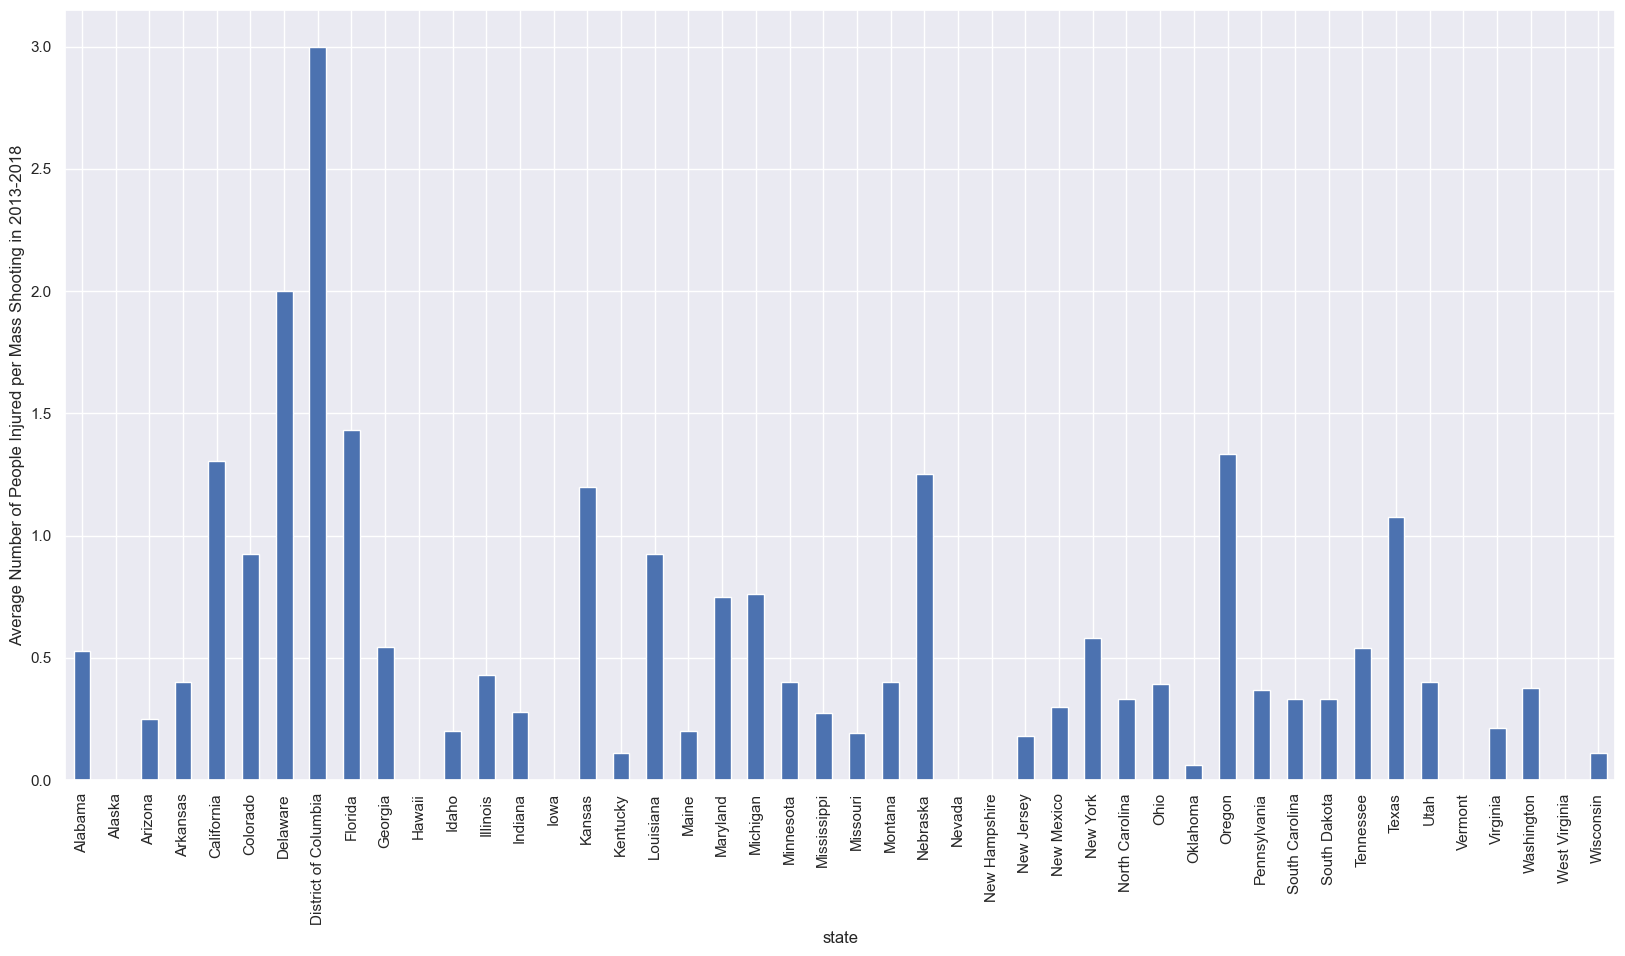

In [313]:
injured_avg_df = gun_df.groupby('state')['n_injured'].mean()

ax = injured_avg_df.plot.bar(figsize=(20,10), ylabel = "Average Number of People Injured per Mass Shooting in 2013-2018")
plt.show()

## Regression Models

In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [188]:
labelencoder=LabelEncoder()
gun_mute = gun_state_sum_df.copy()
gun_mute['abbrev'] = labelencoder.fit_transform(gun_mute['abbrev'])
gun_mute = gun_mute.fillna(0)
gun_mute.sample(5)

abbrev  n_killed  n_injured  n_guns_involved  \
state                                                                
South Dakota              41        13          1              4.0   
Texas                     43       309         87             61.0   
District of Columbia       7        11          3              2.0   
Utah                      44        35          4              8.0   
Minnesota                 23        18          2              5.0   

                      n_incidents   Male  Female  Adult  Teen  Child  Victim  \
state                                                                          
South Dakota                    3    7.0     7.0    5.0   2.0    3.0    11.0   
Texas                          81  240.0   133.0  309.0  21.0   54.0   348.0   
District of Columbia            1   11.0     5.0   16.0   0.0    0.0    15.0   
Utah                           10   25.0    17.0   28.0   3.0   11.0    32.0   
Minnesota                       5   10.0    11.0   14.0   5.0    2.0    16.0   

                      Suspect  Unknown_Guns  Handgun  Shotgun  Rifle  Other  \
state                                                                         
South Dakota              3.0           0.0      1.0      1.0    0.0    0.0   
Texas                    73.0          39.0     10.0      2.0    4.0    0.0   
District of Columbia      1.0           0.0      1.0      1.0    0.0    0.0   
Utah                     10.0           5.0      3.0      0.0    0.0    0.0   
Minnesota                 5.0           3.0      1.0      1.0    0.0    0.0   

                      Automatic  
state                            
South Dakota                2.0  
Texas                       5.0  
District of Columbia        0.0  
Utah                        0.0  
Minnesota                   0.0

### Number Killed as Response Variable

In [196]:
y = gun_mute['n_killed']
X = gun_mute.drop(columns = ['n_killed'])

In [197]:
import random
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')

random.seed(3254)
models = [LinearRegression(), DecisionTreeRegressor(random_state=42), 
          RandomForestRegressor(random_state=42),
          Lasso(),
          Ridge()]

for model in models:
    print()
    print(model)
    model.fit(X, y)
    mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    scores = cross_val_score(model, X, y, scoring='r2', cv=10)
    rmse_scores = np.sqrt(-mse_scores)
    print("r2 mean:\n", scores.mean())
    print("RMSE mean:\n", rmse_scores.mean())


LinearRegression()
r2 mean:
 0.9965566328062053
RMSE mean:
 1.8420097957360906

DecisionTreeRegressor(random_state=42)
r2 mean:
 0.9268234733030623
RMSE mean:
 10.626848250651868

RandomForestRegressor(random_state=42)
r2 mean:
 0.9402784853712701
RMSE mean:
 10.88937548903946

Lasso()
r2 mean:
 0.992847465772499
RMSE mean:
 2.8551898869573638

Ridge()
r2 mean:
 0.9955014773836671
RMSE mean:
 2.0827286395186535


From the models, we see that linear regression is the best choice as a model where number of killed is the response variable. We obtained an R2 value of 0.9965 and an RSME value of 1.842.

In [198]:
best_model = LinearRegression().fit(X,y)
y_pred=best_model.predict(X)

In [199]:
## Accuracy of model
from sklearn.metrics import r2_score
Accuracy=r2_score(y,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 99.98


#### Predicted vs Actual - Number of Killed

Text(0.5, 0.98, 'Predicted vs Actual')

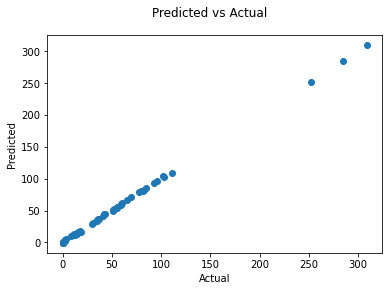

In [200]:
plt.scatter(y,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.suptitle("Predicted vs Actual")

### Number of Suspects as Response Variable

In [201]:
y = gun_mute['Suspect']
X = gun_mute.drop(columns = ['Suspect'])

In [202]:
random.seed(3654)
for model in models:
    print()
    print(model)
    model.fit(X, y)
    mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    scores = cross_val_score(model, X, y, scoring='r2', cv=10)
    rmse_scores = np.sqrt(-mse_scores)
    print("r2 mean:\n", scores.mean())
    print("RMSE mean:\n", rmse_scores.mean())


LinearRegression()
r2 mean:
 0.8922194489202842
RMSE mean:
 4.033503658091629

DecisionTreeRegressor(random_state=42)
r2 mean:
 0.7825329139197567
RMSE mean:
 5.128338168729526

RandomForestRegressor(random_state=42)
r2 mean:
 0.898218940346438
RMSE mean:
 3.8745232105086993

Lasso()
r2 mean:
 0.9424417394171034
RMSE mean:
 2.69301133501026

Ridge()
r2 mean:
 0.9312801125374902
RMSE mean:
 3.1568712594188044


From the models, we see that Lasso Regression is the best choice as a model where number of suspects is the response variable. We obtained an R2 value of 0.942 and an RSME value of 2.693.

In [203]:
best_model = LinearRegression().fit(X,y)
y_pred=best_model.predict(X)

In [204]:
## Accuracy of model
from sklearn.metrics import r2_score
Accuracy=r2_score(y,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 99.49


#### Predicted vs Actual - Number of Suspects

Text(0.5, 0.98, 'Predicted vs Actual')

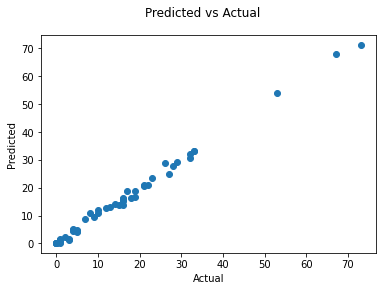

In [205]:
plt.scatter(y,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.suptitle("Predicted vs Actual")

### Number of Injured as Response Variable

In [206]:
y = gun_mute['n_injured']
X = gun_mute.drop(columns = ['n_injured'])

In [207]:
random.seed(12)
for model in models:
    print()
    print(model)
    model.fit(X, y)
    mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    scores = cross_val_score(model, X, y, scoring='r2', cv=10)
    rmse_scores = np.sqrt(-mse_scores)
    print("r2 mean:\n", scores.mean())
    print("RMSE mean:\n", rmse_scores.mean())


LinearRegression()
r2 mean:
 0.7185962405800772
RMSE mean:
 3.4855910119040585

DecisionTreeRegressor(random_state=42)
r2 mean:
 -0.14460360339814932
RMSE mean:
 5.570457093950436

RandomForestRegressor(random_state=42)
r2 mean:
 -0.41659170430513087
RMSE mean:
 6.8574971147484005

Lasso()
r2 mean:
 0.8448613957816855
RMSE mean:
 2.3317394555137847

Ridge()
r2 mean:
 0.8867135691367019
RMSE mean:
 1.8128296047272792


From the models, we see that Ridge Regression is the best choice as a model where number of injured is the response variable. We obtained an R2 value of 0.887 and an RSME value of 1.8128.

In [208]:
best_model = LinearRegression().fit(X,y)
y_pred=best_model.predict(X)

In [209]:
## Accuracy of model
from sklearn.metrics import r2_score
Accuracy=r2_score(y,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 99.73


#### Predicted vs Actual - Number of Injured

Text(0.5, 0.98, 'Predicted vs Actual')

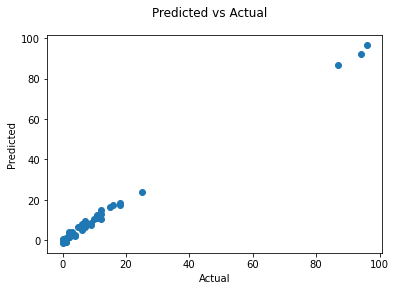

In [210]:
plt.scatter(y,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.suptitle("Predicted vs Actual")

### Number of Incidents as Response Variable

In [211]:
y = gun_mute['n_incidents']
X = gun_mute.drop(columns = ['n_incidents'])

In [212]:
random.seed(12)
for model in models:
    print()
    print(model)
    model.fit(X, y)
    mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
    scores = cross_val_score(model, X, y, scoring='r2', cv=10)
    rmse_scores = np.sqrt(-mse_scores)
    print("r2 mean:\n", scores.mean())
    print("RMSE mean:\n", rmse_scores.mean())


LinearRegression()
r2 mean:
 0.8774513165384471
RMSE mean:
 3.3271510446907344

DecisionTreeRegressor(random_state=42)
r2 mean:
 0.9467886143433457
RMSE mean:
 2.443258892010001

RandomForestRegressor(random_state=42)
r2 mean:
 0.9396335503063158
RMSE mean:
 2.942186388829498

Lasso()
r2 mean:
 0.9666961003111423
RMSE mean:
 1.8105368927185268

Ridge()
r2 mean:
 0.9264087436899018
RMSE mean:
 2.6079766017406527


From the models, we see that Lasso Regression is the best choice as a model where number of incidents is the response variable. We obtained an R2 value of 0.967 and an RSME value of 1.8105.

In [213]:
best_model = LinearRegression().fit(X,y)
y_pred=best_model.predict(X)

In [214]:
## Accuracy of model
from sklearn.metrics import r2_score
Accuracy=r2_score(y,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 99.72


#### Predicted vs Actual - Number of Incidents

Text(0.5, 0.98, 'Predicted vs Actual')

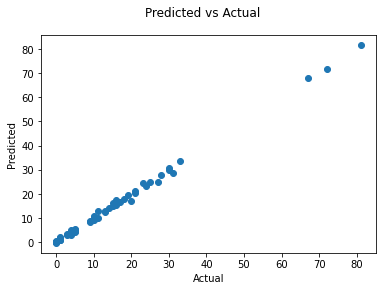

In [215]:
plt.scatter(y,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.suptitle("Predicted vs Actual")